# GM-VAE for SMBA

In [1]:
num_components=6
num_epochs=10000

## Import Libraries

In [2]:
import json

import numpy as np
import argparse
import random
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.utils.data
from scipy.io import loadmat

import sys
sys.path.append('/home/yangz2/projects/gmvae_and_gmmvae/pytorch/')
sys.path.append('../../1906-pcgml/pcgml-gmmVae-exp/modules/')
import vglc_with_path_encodings
sys.path.append('../experiments')

import smba_gmprior_effect_on_rec

from model.GMVAE import *
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Load data

In [6]:
def open_json_as_nparray(json_fname):
    with open(json_fname, 'r') as json_f:
        return np.array(json.load(json_f))

Load SMB.

In [7]:
smb_int = open_json_as_nparray('smbWithPath-allLevels-chunks-int.json')

In [8]:
smb_onehot = np.eye(len(np.unique(smb_int)))[smb_int]
smb_onehot.shape

(2698, 16, 16, 12)

In [9]:
smb_onehot = smb_onehot.reshape(
    smb_onehot.shape[0], 
    smb_onehot.shape[1] * smb_onehot.shape[2] * smb_onehot.shape[3]
)
smb_onehot.shape

(2698, 3072)

In [10]:
np.random.seed(42)
smb_labels = np.random.randint(num_components, size=smb_onehot.shape[0])
smb_labels.shape, smb_labels[:20]

((2698,), array([3, 4, 2, 4, 4, 1, 2, 2, 2, 4, 3, 2, 5, 4, 1, 3, 5, 5, 1, 3]))

In [11]:
chunks, labels = smb_onehot, smb_labels

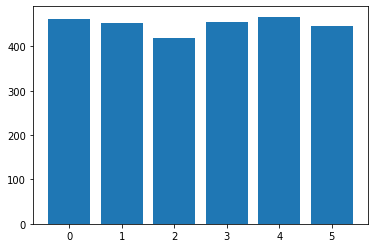

In [12]:
plt.bar(np.arange(num_components), np.bincount(smb_labels))
plt.show()

## Input Parameters

In [13]:
########################################################
## Input Parameters
#########################################################
parser = argparse.ArgumentParser(description='PyTorch Implementation of DGM Clustering')

## Used only in notebooks
parser.add_argument('-f', '--file',
                    help='Path for input file. First line should contain number of lines to search in')

## Dataset
parser.add_argument('--dataset', type=str, choices=['mnist'],
                    default='mnist', help='dataset (default: mnist)')
parser.add_argument('--seed', type=int, default=1, help='random seed (default: 1)')

## GPU
parser.add_argument('--cuda', type=int, default=1,
                    help='use of cuda (default: 1)')
parser.add_argument('--gpuID', type=int, default=0,
                    help='set gpu id to use (default: 0)')

## Training
parser.add_argument('--epochs', type=int, default=num_epochs,
                    help='number of total epochs to run (default: 200)')
parser.add_argument('--batch_size', default=64, type=int,
                    help='mini-batch size (default: 64)')
parser.add_argument('--batch_size_val', default=200, type=int,
                    help='mini-batch size of validation (default: 200)')
parser.add_argument('--learning_rate', default=1e-3, type=float,
                    help='learning rate (default: 0.001)')
parser.add_argument('--decay_epoch', default=-1, type=int, 
                    help='Reduces the learning rate every decay_epoch')
parser.add_argument('--lr_decay', default=0.5, type=float,
                    help='Learning rate decay for training (default: 0.5)')

## Architecture
parser.add_argument('--num_classes', type=int, default=num_components,
                    help='number of classes (default: 10)')  # edited for this task
parser.add_argument('--gaussian_size', default=64, type=int,
                    help='gaussian size (default: 64)')
parser.add_argument('--input_size', default=3072, type=int,
                    help='input size (default: 784)')  # edited for this task

## Partition parameters
parser.add_argument('--train_proportion', default=0.9, type=float,
                    help='proportion of examples to consider for training only (default: 1.0)')

## Gumbel parameters
parser.add_argument('--init_temp', default=1.0, type=float,
                    help='Initial temperature used in gumbel-softmax (recommended 0.5-1.0, default:1.0)')
parser.add_argument('--decay_temp', default=1, type=int, 
                    help='Set 1 to decay gumbel temperature at every epoch (default: 1)')
parser.add_argument('--hard_gumbel', default=0, type=int, 
                    help='Set 1 to use the hard version of gumbel-softmax (default: 1)')
parser.add_argument('--min_temp', default=0.5, type=float, 
                    help='Minimum temperature of gumbel-softmax after annealing (default: 0.5)' )
parser.add_argument('--decay_temp_rate', default=0.013862944, type=float,
                    help='Temperature decay rate at every epoch (default: 0.013862944)')

## Loss function parameters
parser.add_argument('--w_gauss', default=2, type=float,
                    help='weight of gaussian loss (default: 1)')
parser.add_argument('--w_categ', default=1, type=float,
                    help='weight of categorical loss (default: 1)')
parser.add_argument('--w_rec', default=1, type=float,
                    help='weight of reconstruction loss (default: 1)')
parser.add_argument('--rec_type', type=str, choices=['bce', 'mse'],
                    default='bce', help='desired reconstruction loss function (default: bce)')

## Others
parser.add_argument('--verbose', default=0, type=int,
                    help='print extra information at every epoch.(default: 0)')

args = parser.parse_args()

Set random seed in case it was specified in the parameters


In [14]:
## Random Seed
SEED = args.seed
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if args.cuda:
    torch.cuda.manual_seed(SEED)

## Data Partition

We split the training data into train and validation according to the *train_proportion* parameter:

In [15]:
from torch.utils.data import TensorDataset, DataLoader

In [16]:
valid_indices = np.random.randint(len(chunks), size=500)
train_chunks, valid_chunks = chunks, chunks[valid_indices]
train_labels, valid_labels = labels, labels[valid_indices]

train_ds = TensorDataset(torch.from_numpy(train_chunks).float(), torch.from_numpy(train_labels).long())
valid_ds = TensorDataset(torch.from_numpy(valid_chunks).float(), torch.from_numpy(valid_labels).long())

train_dl = DataLoader(train_ds, batch_size=args.batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=args.batch_size_val, shuffle=False)

## Train Model

In [17]:
# Model Initialization
gmvae = GMVAE(args)

In [19]:
# history_loss = gmvae.train(train_dl, valid_dl)

(Epoch 1 / 10000) Train_Loss: 445.854; Val_Loss: 232.004   Train_ACC: 17.383; Val_ACC: 20.400   Train_NMI: 0.088; Val_NMI: 0.839
(Epoch 2 / 10000) Train_Loss: 229.466; Val_Loss: 224.713   Train_ACC: 17.717; Val_ACC: 21.200   Train_NMI: 0.087; Val_NMI: 0.883
(Epoch 3 / 10000) Train_Loss: 226.898; Val_Loss: 222.640   Train_ACC: 18.532; Val_ACC: 22.600   Train_NMI: 0.277; Val_NMI: 1.563
(Epoch 4 / 10000) Train_Loss: 218.378; Val_Loss: 211.711   Train_ACC: 18.681; Val_ACC: 21.600   Train_NMI: 0.408; Val_NMI: 1.124
(Epoch 5 / 10000) Train_Loss: 213.430; Val_Loss: 207.092   Train_ACC: 18.755; Val_ACC: 21.400   Train_NMI: 0.422; Val_NMI: 1.166
(Epoch 6 / 10000) Train_Loss: 209.525; Val_Loss: 201.732   Train_ACC: 18.458; Val_ACC: 20.800   Train_NMI: 0.225; Val_NMI: 1.022
(Epoch 7 / 10000) Train_Loss: 204.814; Val_Loss: 199.444   Train_ACC: 18.755; Val_ACC: 21.200   Train_NMI: 0.218; Val_NMI: 0.757
(Epoch 8 / 10000) Train_Loss: 204.311; Val_Loss: 203.877   Train_ACC: 18.310; Val_ACC: 21.000   T

(Epoch 65 / 10000) Train_Loss: 130.972; Val_Loss: 126.745   Train_ACC: 19.014; Val_ACC: 22.200   Train_NMI: 0.267; Val_NMI: 1.620
(Epoch 66 / 10000) Train_Loss: 129.020; Val_Loss: 126.584   Train_ACC: 18.755; Val_ACC: 23.200   Train_NMI: 0.248; Val_NMI: 2.069
(Epoch 67 / 10000) Train_Loss: 128.710; Val_Loss: 126.261   Train_ACC: 18.829; Val_ACC: 22.800   Train_NMI: 0.247; Val_NMI: 1.964
(Epoch 68 / 10000) Train_Loss: 128.375; Val_Loss: 126.063   Train_ACC: 18.718; Val_ACC: 22.200   Train_NMI: 0.270; Val_NMI: 1.718
(Epoch 69 / 10000) Train_Loss: 127.967; Val_Loss: 124.574   Train_ACC: 18.532; Val_ACC: 22.600   Train_NMI: 0.272; Val_NMI: 1.675
(Epoch 70 / 10000) Train_Loss: 126.753; Val_Loss: 124.843   Train_ACC: 18.606; Val_ACC: 22.800   Train_NMI: 0.240; Val_NMI: 1.905
(Epoch 71 / 10000) Train_Loss: 127.072; Val_Loss: 122.580   Train_ACC: 18.681; Val_ACC: 23.000   Train_NMI: 0.283; Val_NMI: 2.043
(Epoch 72 / 10000) Train_Loss: 125.341; Val_Loss: 122.583   Train_ACC: 19.014; Val_ACC: 22

(Epoch 129 / 10000) Train_Loss: 91.815; Val_Loss: 88.103   Train_ACC: 18.903; Val_ACC: 23.400   Train_NMI: 0.245; Val_NMI: 1.939
(Epoch 130 / 10000) Train_Loss: 90.843; Val_Loss: 89.069   Train_ACC: 18.866; Val_ACC: 22.600   Train_NMI: 0.225; Val_NMI: 1.952
(Epoch 131 / 10000) Train_Loss: 91.723; Val_Loss: 88.704   Train_ACC: 18.681; Val_ACC: 24.600   Train_NMI: 0.236; Val_NMI: 2.155
(Epoch 132 / 10000) Train_Loss: 89.988; Val_Loss: 86.439   Train_ACC: 19.274; Val_ACC: 23.000   Train_NMI: 0.278; Val_NMI: 2.133
(Epoch 133 / 10000) Train_Loss: 90.230; Val_Loss: 86.308   Train_ACC: 19.311; Val_ACC: 22.400   Train_NMI: 0.267; Val_NMI: 1.623
(Epoch 134 / 10000) Train_Loss: 89.282; Val_Loss: 87.857   Train_ACC: 18.903; Val_ACC: 22.000   Train_NMI: 0.215; Val_NMI: 1.370
(Epoch 135 / 10000) Train_Loss: 88.660; Val_Loss: 85.302   Train_ACC: 18.977; Val_ACC: 22.400   Train_NMI: 0.255; Val_NMI: 1.669
(Epoch 136 / 10000) Train_Loss: 90.295; Val_Loss: 87.777   Train_ACC: 18.718; Val_ACC: 22.600   T

(Epoch 193 / 10000) Train_Loss: 79.080; Val_Loss: 73.364   Train_ACC: 18.755; Val_ACC: 22.400   Train_NMI: 0.235; Val_NMI: 1.484
(Epoch 194 / 10000) Train_Loss: 75.309; Val_Loss: 67.229   Train_ACC: 19.236; Val_ACC: 22.400   Train_NMI: 0.244; Val_NMI: 1.585
(Epoch 195 / 10000) Train_Loss: 72.199; Val_Loss: 69.751   Train_ACC: 18.866; Val_ACC: 21.400   Train_NMI: 0.201; Val_NMI: 1.521
(Epoch 196 / 10000) Train_Loss: 70.547; Val_Loss: 65.693   Train_ACC: 19.088; Val_ACC: 21.800   Train_NMI: 0.227; Val_NMI: 1.537
(Epoch 197 / 10000) Train_Loss: 69.358; Val_Loss: 66.813   Train_ACC: 18.940; Val_ACC: 22.400   Train_NMI: 0.226; Val_NMI: 1.500
(Epoch 198 / 10000) Train_Loss: 69.993; Val_Loss: 67.612   Train_ACC: 18.681; Val_ACC: 21.600   Train_NMI: 0.188; Val_NMI: 1.287
(Epoch 199 / 10000) Train_Loss: 70.573; Val_Loss: 66.098   Train_ACC: 18.977; Val_ACC: 21.400   Train_NMI: 0.203; Val_NMI: 1.425
(Epoch 200 / 10000) Train_Loss: 69.112; Val_Loss: 66.889   Train_ACC: 18.977; Val_ACC: 22.400   T

(Epoch 257 / 10000) Train_Loss: 58.314; Val_Loss: 54.801   Train_ACC: 19.348; Val_ACC: 22.800   Train_NMI: 0.288; Val_NMI: 1.793
(Epoch 258 / 10000) Train_Loss: 58.373; Val_Loss: 55.871   Train_ACC: 19.162; Val_ACC: 21.400   Train_NMI: 0.269; Val_NMI: 1.394
(Epoch 259 / 10000) Train_Loss: 57.708; Val_Loss: 52.942   Train_ACC: 19.088; Val_ACC: 23.000   Train_NMI: 0.237; Val_NMI: 1.780
(Epoch 260 / 10000) Train_Loss: 57.821; Val_Loss: 56.069   Train_ACC: 18.940; Val_ACC: 22.400   Train_NMI: 0.217; Val_NMI: 1.880
(Epoch 261 / 10000) Train_Loss: 58.008; Val_Loss: 55.782   Train_ACC: 19.051; Val_ACC: 23.000   Train_NMI: 0.237; Val_NMI: 2.013
(Epoch 262 / 10000) Train_Loss: 58.501; Val_Loss: 55.796   Train_ACC: 18.866; Val_ACC: 21.600   Train_NMI: 0.215; Val_NMI: 1.430
(Epoch 263 / 10000) Train_Loss: 60.002; Val_Loss: 56.313   Train_ACC: 18.792; Val_ACC: 21.800   Train_NMI: 0.242; Val_NMI: 1.304
(Epoch 264 / 10000) Train_Loss: 58.821; Val_Loss: 55.657   Train_ACC: 18.866; Val_ACC: 22.800   T

(Epoch 321 / 10000) Train_Loss: 52.435; Val_Loss: 48.886   Train_ACC: 18.903; Val_ACC: 22.400   Train_NMI: 0.195; Val_NMI: 1.536
(Epoch 322 / 10000) Train_Loss: 56.244; Val_Loss: 51.288   Train_ACC: 19.088; Val_ACC: 22.000   Train_NMI: 0.216; Val_NMI: 1.312
(Epoch 323 / 10000) Train_Loss: 54.010; Val_Loss: 50.925   Train_ACC: 18.829; Val_ACC: 22.200   Train_NMI: 0.235; Val_NMI: 1.693
(Epoch 324 / 10000) Train_Loss: 53.306; Val_Loss: 50.564   Train_ACC: 18.643; Val_ACC: 22.000   Train_NMI: 0.207; Val_NMI: 1.547
(Epoch 325 / 10000) Train_Loss: 53.139; Val_Loss: 48.757   Train_ACC: 19.236; Val_ACC: 22.600   Train_NMI: 0.280; Val_NMI: 1.531
(Epoch 326 / 10000) Train_Loss: 51.339; Val_Loss: 47.670   Train_ACC: 19.311; Val_ACC: 22.400   Train_NMI: 0.276; Val_NMI: 1.507
(Epoch 327 / 10000) Train_Loss: 49.424; Val_Loss: 47.482   Train_ACC: 18.829; Val_ACC: 22.200   Train_NMI: 0.207; Val_NMI: 1.412
(Epoch 328 / 10000) Train_Loss: 51.423; Val_Loss: 46.850   Train_ACC: 19.274; Val_ACC: 23.200   T

(Epoch 385 / 10000) Train_Loss: 48.383; Val_Loss: 46.343   Train_ACC: 18.792; Val_ACC: 22.000   Train_NMI: 0.211; Val_NMI: 1.540
(Epoch 386 / 10000) Train_Loss: 48.990; Val_Loss: 46.391   Train_ACC: 19.014; Val_ACC: 22.600   Train_NMI: 0.239; Val_NMI: 1.523
(Epoch 387 / 10000) Train_Loss: 46.495; Val_Loss: 45.759   Train_ACC: 18.829; Val_ACC: 21.400   Train_NMI: 0.201; Val_NMI: 1.141
(Epoch 388 / 10000) Train_Loss: 44.905; Val_Loss: 43.324   Train_ACC: 18.829; Val_ACC: 22.200   Train_NMI: 0.271; Val_NMI: 1.274
(Epoch 389 / 10000) Train_Loss: 44.430; Val_Loss: 42.610   Train_ACC: 18.755; Val_ACC: 22.600   Train_NMI: 0.215; Val_NMI: 1.704
(Epoch 390 / 10000) Train_Loss: 43.265; Val_Loss: 40.627   Train_ACC: 18.977; Val_ACC: 22.800   Train_NMI: 0.223; Val_NMI: 1.736
(Epoch 391 / 10000) Train_Loss: 43.317; Val_Loss: 44.513   Train_ACC: 19.014; Val_ACC: 22.800   Train_NMI: 0.215; Val_NMI: 1.572
(Epoch 392 / 10000) Train_Loss: 44.736; Val_Loss: 42.961   Train_ACC: 18.977; Val_ACC: 22.400   T

(Epoch 449 / 10000) Train_Loss: 44.778; Val_Loss: 43.016   Train_ACC: 19.162; Val_ACC: 22.800   Train_NMI: 0.273; Val_NMI: 1.664
(Epoch 450 / 10000) Train_Loss: 46.653; Val_Loss: 43.747   Train_ACC: 18.866; Val_ACC: 21.000   Train_NMI: 0.234; Val_NMI: 1.127
(Epoch 451 / 10000) Train_Loss: 46.112; Val_Loss: 46.031   Train_ACC: 19.236; Val_ACC: 22.400   Train_NMI: 0.237; Val_NMI: 1.577
(Epoch 452 / 10000) Train_Loss: 46.899; Val_Loss: 44.136   Train_ACC: 19.162; Val_ACC: 23.000   Train_NMI: 0.294; Val_NMI: 1.620
(Epoch 453 / 10000) Train_Loss: 47.703; Val_Loss: 46.431   Train_ACC: 19.088; Val_ACC: 23.000   Train_NMI: 0.244; Val_NMI: 2.029
(Epoch 454 / 10000) Train_Loss: 46.272; Val_Loss: 42.466   Train_ACC: 19.014; Val_ACC: 22.600   Train_NMI: 0.270; Val_NMI: 1.888
(Epoch 455 / 10000) Train_Loss: 44.769; Val_Loss: 43.120   Train_ACC: 19.274; Val_ACC: 20.800   Train_NMI: 0.252; Val_NMI: 1.561
(Epoch 456 / 10000) Train_Loss: 44.348; Val_Loss: 41.805   Train_ACC: 19.088; Val_ACC: 22.200   T

(Epoch 513 / 10000) Train_Loss: 37.844; Val_Loss: 35.724   Train_ACC: 19.236; Val_ACC: 21.600   Train_NMI: 0.280; Val_NMI: 1.313
(Epoch 514 / 10000) Train_Loss: 38.754; Val_Loss: 36.764   Train_ACC: 18.977; Val_ACC: 22.000   Train_NMI: 0.243; Val_NMI: 1.329
(Epoch 515 / 10000) Train_Loss: 39.725; Val_Loss: 37.888   Train_ACC: 19.348; Val_ACC: 21.800   Train_NMI: 0.301; Val_NMI: 1.580
(Epoch 516 / 10000) Train_Loss: 42.839; Val_Loss: 41.249   Train_ACC: 18.977; Val_ACC: 21.400   Train_NMI: 0.224; Val_NMI: 1.552
(Epoch 517 / 10000) Train_Loss: 42.754; Val_Loss: 39.836   Train_ACC: 18.792; Val_ACC: 23.000   Train_NMI: 0.230; Val_NMI: 1.740
(Epoch 518 / 10000) Train_Loss: 40.250; Val_Loss: 38.826   Train_ACC: 19.088; Val_ACC: 22.600   Train_NMI: 0.247; Val_NMI: 1.612
(Epoch 519 / 10000) Train_Loss: 39.584; Val_Loss: 36.464   Train_ACC: 19.348; Val_ACC: 21.800   Train_NMI: 0.260; Val_NMI: 1.569
(Epoch 520 / 10000) Train_Loss: 40.845; Val_Loss: 38.601   Train_ACC: 19.274; Val_ACC: 22.800   T

(Epoch 577 / 10000) Train_Loss: 37.879; Val_Loss: 36.052   Train_ACC: 19.199; Val_ACC: 22.200   Train_NMI: 0.295; Val_NMI: 1.532
(Epoch 578 / 10000) Train_Loss: 38.086; Val_Loss: 37.986   Train_ACC: 18.681; Val_ACC: 22.600   Train_NMI: 0.226; Val_NMI: 1.677
(Epoch 579 / 10000) Train_Loss: 42.156; Val_Loss: 42.395   Train_ACC: 18.903; Val_ACC: 22.400   Train_NMI: 0.219; Val_NMI: 1.999
(Epoch 580 / 10000) Train_Loss: 51.472; Val_Loss: 51.392   Train_ACC: 19.014; Val_ACC: 23.200   Train_NMI: 0.222; Val_NMI: 1.716
(Epoch 581 / 10000) Train_Loss: 46.075; Val_Loss: 42.965   Train_ACC: 19.088; Val_ACC: 22.400   Train_NMI: 0.241; Val_NMI: 1.884
(Epoch 582 / 10000) Train_Loss: 41.290; Val_Loss: 38.920   Train_ACC: 19.014; Val_ACC: 23.800   Train_NMI: 0.252; Val_NMI: 1.911
(Epoch 583 / 10000) Train_Loss: 39.300; Val_Loss: 36.630   Train_ACC: 19.014; Val_ACC: 23.000   Train_NMI: 0.219; Val_NMI: 1.805
(Epoch 584 / 10000) Train_Loss: 37.994; Val_Loss: 35.866   Train_ACC: 18.718; Val_ACC: 21.800   T

(Epoch 641 / 10000) Train_Loss: 53.805; Val_Loss: 54.195   Train_ACC: 19.199; Val_ACC: 21.800   Train_NMI: 0.263; Val_NMI: 1.408
(Epoch 642 / 10000) Train_Loss: 50.586; Val_Loss: 47.743   Train_ACC: 19.125; Val_ACC: 21.400   Train_NMI: 0.290; Val_NMI: 1.529
(Epoch 643 / 10000) Train_Loss: 45.055; Val_Loss: 38.122   Train_ACC: 19.125; Val_ACC: 22.200   Train_NMI: 0.226; Val_NMI: 1.607
(Epoch 644 / 10000) Train_Loss: 38.874; Val_Loss: 36.365   Train_ACC: 18.903; Val_ACC: 22.000   Train_NMI: 0.236; Val_NMI: 1.449
(Epoch 645 / 10000) Train_Loss: 37.688; Val_Loss: 35.461   Train_ACC: 19.088; Val_ACC: 21.400   Train_NMI: 0.233; Val_NMI: 1.446
(Epoch 646 / 10000) Train_Loss: 36.080; Val_Loss: 34.217   Train_ACC: 18.643; Val_ACC: 22.400   Train_NMI: 0.220; Val_NMI: 1.702
(Epoch 647 / 10000) Train_Loss: 36.133; Val_Loss: 33.904   Train_ACC: 19.088; Val_ACC: 21.600   Train_NMI: 0.219; Val_NMI: 1.399
(Epoch 648 / 10000) Train_Loss: 36.802; Val_Loss: 35.621   Train_ACC: 19.236; Val_ACC: 21.600   T

(Epoch 705 / 10000) Train_Loss: 36.102; Val_Loss: 33.637   Train_ACC: 19.274; Val_ACC: 21.000   Train_NMI: 0.262; Val_NMI: 1.292
(Epoch 706 / 10000) Train_Loss: 34.758; Val_Loss: 32.895   Train_ACC: 19.199; Val_ACC: 23.200   Train_NMI: 0.228; Val_NMI: 1.955
(Epoch 707 / 10000) Train_Loss: 35.477; Val_Loss: 34.943   Train_ACC: 18.829; Val_ACC: 23.400   Train_NMI: 0.203; Val_NMI: 1.826
(Epoch 708 / 10000) Train_Loss: 35.242; Val_Loss: 37.182   Train_ACC: 19.274; Val_ACC: 22.000   Train_NMI: 0.249; Val_NMI: 1.519
(Epoch 709 / 10000) Train_Loss: 36.005; Val_Loss: 33.403   Train_ACC: 18.903; Val_ACC: 22.400   Train_NMI: 0.215; Val_NMI: 1.608
(Epoch 710 / 10000) Train_Loss: 38.008; Val_Loss: 36.265   Train_ACC: 18.866; Val_ACC: 21.400   Train_NMI: 0.236; Val_NMI: 1.704
(Epoch 711 / 10000) Train_Loss: 37.037; Val_Loss: 35.347   Train_ACC: 19.162; Val_ACC: 23.400   Train_NMI: 0.274; Val_NMI: 1.862
(Epoch 712 / 10000) Train_Loss: 37.020; Val_Loss: 35.548   Train_ACC: 18.940; Val_ACC: 21.000   T

(Epoch 769 / 10000) Train_Loss: 37.705; Val_Loss: 35.433   Train_ACC: 18.903; Val_ACC: 22.000   Train_NMI: 0.251; Val_NMI: 1.595
(Epoch 770 / 10000) Train_Loss: 35.987; Val_Loss: 35.225   Train_ACC: 19.274; Val_ACC: 22.800   Train_NMI: 0.290; Val_NMI: 1.902
(Epoch 771 / 10000) Train_Loss: 34.590; Val_Loss: 32.668   Train_ACC: 18.866; Val_ACC: 22.000   Train_NMI: 0.328; Val_NMI: 1.550
(Epoch 772 / 10000) Train_Loss: 34.127; Val_Loss: 32.899   Train_ACC: 18.829; Val_ACC: 21.800   Train_NMI: 0.226; Val_NMI: 1.622
(Epoch 773 / 10000) Train_Loss: 34.030; Val_Loss: 35.636   Train_ACC: 18.681; Val_ACC: 21.800   Train_NMI: 0.260; Val_NMI: 1.387
(Epoch 774 / 10000) Train_Loss: 43.506; Val_Loss: 39.223   Train_ACC: 19.051; Val_ACC: 23.000   Train_NMI: 0.231; Val_NMI: 1.806
(Epoch 775 / 10000) Train_Loss: 41.687; Val_Loss: 37.974   Train_ACC: 18.866; Val_ACC: 22.000   Train_NMI: 0.211; Val_NMI: 1.462
(Epoch 776 / 10000) Train_Loss: 37.810; Val_Loss: 35.767   Train_ACC: 18.977; Val_ACC: 21.000   T

(Epoch 833 / 10000) Train_Loss: 33.127; Val_Loss: 32.685   Train_ACC: 19.311; Val_ACC: 23.200   Train_NMI: 0.264; Val_NMI: 1.973
(Epoch 834 / 10000) Train_Loss: 32.691; Val_Loss: 32.501   Train_ACC: 18.866; Val_ACC: 22.200   Train_NMI: 0.237; Val_NMI: 1.823
(Epoch 835 / 10000) Train_Loss: 33.298; Val_Loss: 32.522   Train_ACC: 18.866; Val_ACC: 23.000   Train_NMI: 0.225; Val_NMI: 1.856
(Epoch 836 / 10000) Train_Loss: 35.340; Val_Loss: 34.031   Train_ACC: 19.162; Val_ACC: 22.600   Train_NMI: 0.238; Val_NMI: 1.755
(Epoch 837 / 10000) Train_Loss: 36.389; Val_Loss: 36.589   Train_ACC: 19.236; Val_ACC: 23.000   Train_NMI: 0.280; Val_NMI: 1.853
(Epoch 838 / 10000) Train_Loss: 39.664; Val_Loss: 36.294   Train_ACC: 19.125; Val_ACC: 23.200   Train_NMI: 0.224; Val_NMI: 1.729
(Epoch 839 / 10000) Train_Loss: 37.111; Val_Loss: 34.835   Train_ACC: 18.940; Val_ACC: 21.800   Train_NMI: 0.262; Val_NMI: 1.593
(Epoch 840 / 10000) Train_Loss: 35.968; Val_Loss: 33.899   Train_ACC: 19.051; Val_ACC: 22.400   T

(Epoch 897 / 10000) Train_Loss: 34.306; Val_Loss: 32.610   Train_ACC: 18.643; Val_ACC: 22.400   Train_NMI: 0.229; Val_NMI: 1.780
(Epoch 898 / 10000) Train_Loss: 33.257; Val_Loss: 31.326   Train_ACC: 19.422; Val_ACC: 22.600   Train_NMI: 0.281; Val_NMI: 1.956
(Epoch 899 / 10000) Train_Loss: 32.359; Val_Loss: 32.202   Train_ACC: 19.051; Val_ACC: 22.400   Train_NMI: 0.280; Val_NMI: 1.829
(Epoch 900 / 10000) Train_Loss: 32.938; Val_Loss: 31.617   Train_ACC: 19.088; Val_ACC: 23.200   Train_NMI: 0.267; Val_NMI: 2.091
(Epoch 901 / 10000) Train_Loss: 32.362; Val_Loss: 33.083   Train_ACC: 18.940; Val_ACC: 21.800   Train_NMI: 0.249; Val_NMI: 1.559
(Epoch 902 / 10000) Train_Loss: 32.406; Val_Loss: 31.292   Train_ACC: 19.236; Val_ACC: 22.400   Train_NMI: 0.269; Val_NMI: 2.054
(Epoch 903 / 10000) Train_Loss: 32.106; Val_Loss: 32.540   Train_ACC: 19.125; Val_ACC: 22.600   Train_NMI: 0.298; Val_NMI: 1.991
(Epoch 904 / 10000) Train_Loss: 32.697; Val_Loss: 31.493   Train_ACC: 19.014; Val_ACC: 23.200   T

(Epoch 961 / 10000) Train_Loss: 31.909; Val_Loss: 31.099   Train_ACC: 19.274; Val_ACC: 22.600   Train_NMI: 0.267; Val_NMI: 1.853
(Epoch 962 / 10000) Train_Loss: 31.298; Val_Loss: 30.201   Train_ACC: 18.718; Val_ACC: 22.800   Train_NMI: 0.210; Val_NMI: 1.626
(Epoch 963 / 10000) Train_Loss: 32.268; Val_Loss: 32.578   Train_ACC: 18.866; Val_ACC: 23.000   Train_NMI: 0.256; Val_NMI: 2.007
(Epoch 964 / 10000) Train_Loss: 35.768; Val_Loss: 32.172   Train_ACC: 19.385; Val_ACC: 22.200   Train_NMI: 0.301; Val_NMI: 1.505
(Epoch 965 / 10000) Train_Loss: 34.159; Val_Loss: 32.157   Train_ACC: 19.422; Val_ACC: 21.800   Train_NMI: 0.298; Val_NMI: 1.557
(Epoch 966 / 10000) Train_Loss: 34.035; Val_Loss: 35.440   Train_ACC: 19.162; Val_ACC: 22.800   Train_NMI: 0.272; Val_NMI: 1.794
(Epoch 967 / 10000) Train_Loss: 35.929; Val_Loss: 33.233   Train_ACC: 19.311; Val_ACC: 21.400   Train_NMI: 0.269; Val_NMI: 1.399
(Epoch 968 / 10000) Train_Loss: 34.034; Val_Loss: 31.675   Train_ACC: 19.199; Val_ACC: 22.400   T

(Epoch 1025 / 10000) Train_Loss: 34.917; Val_Loss: 32.640   Train_ACC: 19.496; Val_ACC: 22.200   Train_NMI: 0.291; Val_NMI: 1.476
(Epoch 1026 / 10000) Train_Loss: 32.794; Val_Loss: 30.430   Train_ACC: 19.311; Val_ACC: 23.600   Train_NMI: 0.319; Val_NMI: 2.318
(Epoch 1027 / 10000) Train_Loss: 31.400; Val_Loss: 29.461   Train_ACC: 19.162; Val_ACC: 22.800   Train_NMI: 0.255; Val_NMI: 1.864
(Epoch 1028 / 10000) Train_Loss: 31.593; Val_Loss: 31.467   Train_ACC: 19.199; Val_ACC: 22.000   Train_NMI: 0.268; Val_NMI: 1.610
(Epoch 1029 / 10000) Train_Loss: 32.396; Val_Loss: 33.767   Train_ACC: 19.162; Val_ACC: 22.400   Train_NMI: 0.243; Val_NMI: 1.706
(Epoch 1030 / 10000) Train_Loss: 34.215; Val_Loss: 32.564   Train_ACC: 19.274; Val_ACC: 22.200   Train_NMI: 0.283; Val_NMI: 1.627
(Epoch 1031 / 10000) Train_Loss: 33.103; Val_Loss: 30.682   Train_ACC: 19.162; Val_ACC: 23.200   Train_NMI: 0.258; Val_NMI: 2.313
(Epoch 1032 / 10000) Train_Loss: 31.902; Val_Loss: 30.273   Train_ACC: 19.385; Val_ACC: 22

(Epoch 1089 / 10000) Train_Loss: 31.234; Val_Loss: 30.195   Train_ACC: 19.236; Val_ACC: 22.800   Train_NMI: 0.274; Val_NMI: 1.662
(Epoch 1090 / 10000) Train_Loss: 31.271; Val_Loss: 30.209   Train_ACC: 18.903; Val_ACC: 22.800   Train_NMI: 0.279; Val_NMI: 1.760
(Epoch 1091 / 10000) Train_Loss: 30.849; Val_Loss: 30.423   Train_ACC: 19.088; Val_ACC: 22.400   Train_NMI: 0.265; Val_NMI: 1.536
(Epoch 1092 / 10000) Train_Loss: 32.378; Val_Loss: 31.439   Train_ACC: 19.088; Val_ACC: 22.000   Train_NMI: 0.278; Val_NMI: 1.654
(Epoch 1093 / 10000) Train_Loss: 35.713; Val_Loss: 33.244   Train_ACC: 18.977; Val_ACC: 22.800   Train_NMI: 0.245; Val_NMI: 1.746
(Epoch 1094 / 10000) Train_Loss: 35.835; Val_Loss: 34.400   Train_ACC: 19.162; Val_ACC: 22.800   Train_NMI: 0.295; Val_NMI: 1.855
(Epoch 1095 / 10000) Train_Loss: 36.789; Val_Loss: 39.577   Train_ACC: 19.014; Val_ACC: 22.400   Train_NMI: 0.304; Val_NMI: 1.726
(Epoch 1096 / 10000) Train_Loss: 37.486; Val_Loss: 33.428   Train_ACC: 19.088; Val_ACC: 22

(Epoch 1153 / 10000) Train_Loss: 32.623; Val_Loss: 31.025   Train_ACC: 19.014; Val_ACC: 22.400   Train_NMI: 0.274; Val_NMI: 1.625
(Epoch 1154 / 10000) Train_Loss: 31.448; Val_Loss: 31.076   Train_ACC: 19.162; Val_ACC: 21.800   Train_NMI: 0.247; Val_NMI: 1.563
(Epoch 1155 / 10000) Train_Loss: 31.024; Val_Loss: 29.837   Train_ACC: 19.199; Val_ACC: 22.600   Train_NMI: 0.266; Val_NMI: 1.791
(Epoch 1156 / 10000) Train_Loss: 30.852; Val_Loss: 29.942   Train_ACC: 18.903; Val_ACC: 22.800   Train_NMI: 0.236; Val_NMI: 2.042
(Epoch 1157 / 10000) Train_Loss: 32.565; Val_Loss: 31.106   Train_ACC: 19.459; Val_ACC: 22.200   Train_NMI: 0.297; Val_NMI: 1.606
(Epoch 1158 / 10000) Train_Loss: 33.050; Val_Loss: 31.464   Train_ACC: 19.088; Val_ACC: 22.600   Train_NMI: 0.248; Val_NMI: 1.821
(Epoch 1159 / 10000) Train_Loss: 32.120; Val_Loss: 30.485   Train_ACC: 19.385; Val_ACC: 22.400   Train_NMI: 0.314; Val_NMI: 1.742
(Epoch 1160 / 10000) Train_Loss: 38.936; Val_Loss: 40.962   Train_ACC: 19.311; Val_ACC: 23

(Epoch 1217 / 10000) Train_Loss: 39.650; Val_Loss: 33.835   Train_ACC: 19.199; Val_ACC: 22.800   Train_NMI: 0.319; Val_NMI: 1.830
(Epoch 1218 / 10000) Train_Loss: 34.907; Val_Loss: 33.478   Train_ACC: 19.162; Val_ACC: 21.600   Train_NMI: 0.297; Val_NMI: 1.496
(Epoch 1219 / 10000) Train_Loss: 33.537; Val_Loss: 31.097   Train_ACC: 19.125; Val_ACC: 22.600   Train_NMI: 0.254; Val_NMI: 1.996
(Epoch 1220 / 10000) Train_Loss: 30.955; Val_Loss: 31.167   Train_ACC: 19.236; Val_ACC: 22.400   Train_NMI: 0.247; Val_NMI: 1.639
(Epoch 1221 / 10000) Train_Loss: 44.100; Val_Loss: 38.082   Train_ACC: 19.570; Val_ACC: 22.600   Train_NMI: 0.295; Val_NMI: 1.577
(Epoch 1222 / 10000) Train_Loss: 35.828; Val_Loss: 32.394   Train_ACC: 19.607; Val_ACC: 23.800   Train_NMI: 0.344; Val_NMI: 2.103
(Epoch 1223 / 10000) Train_Loss: 36.853; Val_Loss: 34.562   Train_ACC: 19.162; Val_ACC: 22.600   Train_NMI: 0.310; Val_NMI: 1.837
(Epoch 1224 / 10000) Train_Loss: 33.234; Val_Loss: 32.306   Train_ACC: 19.014; Val_ACC: 23

(Epoch 1281 / 10000) Train_Loss: 30.946; Val_Loss: 30.286   Train_ACC: 19.422; Val_ACC: 22.400   Train_NMI: 0.298; Val_NMI: 1.640
(Epoch 1282 / 10000) Train_Loss: 31.064; Val_Loss: 31.039   Train_ACC: 19.236; Val_ACC: 22.200   Train_NMI: 0.309; Val_NMI: 1.520
(Epoch 1283 / 10000) Train_Loss: 46.959; Val_Loss: 39.662   Train_ACC: 18.940; Val_ACC: 22.600   Train_NMI: 0.322; Val_NMI: 1.724
(Epoch 1284 / 10000) Train_Loss: 40.781; Val_Loss: 34.969   Train_ACC: 18.940; Val_ACC: 22.200   Train_NMI: 0.331; Val_NMI: 1.627
(Epoch 1285 / 10000) Train_Loss: 37.298; Val_Loss: 32.155   Train_ACC: 19.088; Val_ACC: 23.400   Train_NMI: 0.319; Val_NMI: 1.890
(Epoch 1286 / 10000) Train_Loss: 32.530; Val_Loss: 30.761   Train_ACC: 19.088; Val_ACC: 22.600   Train_NMI: 0.325; Val_NMI: 1.654
(Epoch 1287 / 10000) Train_Loss: 31.106; Val_Loss: 29.747   Train_ACC: 18.792; Val_ACC: 22.800   Train_NMI: 0.261; Val_NMI: 1.828
(Epoch 1288 / 10000) Train_Loss: 31.535; Val_Loss: 32.461   Train_ACC: 19.014; Val_ACC: 23

(Epoch 1345 / 10000) Train_Loss: 32.213; Val_Loss: 29.799   Train_ACC: 18.903; Val_ACC: 22.800   Train_NMI: 0.322; Val_NMI: 2.026
(Epoch 1346 / 10000) Train_Loss: 31.264; Val_Loss: 30.546   Train_ACC: 19.199; Val_ACC: 23.600   Train_NMI: 0.335; Val_NMI: 1.983
(Epoch 1347 / 10000) Train_Loss: 32.068; Val_Loss: 30.454   Train_ACC: 19.125; Val_ACC: 23.400   Train_NMI: 0.281; Val_NMI: 2.079
(Epoch 1348 / 10000) Train_Loss: 33.464; Val_Loss: 31.573   Train_ACC: 18.458; Val_ACC: 23.000   Train_NMI: 0.232; Val_NMI: 2.214
(Epoch 1349 / 10000) Train_Loss: 31.941; Val_Loss: 31.886   Train_ACC: 19.125; Val_ACC: 23.400   Train_NMI: 0.287; Val_NMI: 1.982
(Epoch 1350 / 10000) Train_Loss: 31.076; Val_Loss: 29.751   Train_ACC: 19.236; Val_ACC: 23.000   Train_NMI: 0.287; Val_NMI: 2.157
(Epoch 1351 / 10000) Train_Loss: 30.610; Val_Loss: 29.164   Train_ACC: 19.051; Val_ACC: 22.800   Train_NMI: 0.303; Val_NMI: 2.174
(Epoch 1352 / 10000) Train_Loss: 31.819; Val_Loss: 30.724   Train_ACC: 19.348; Val_ACC: 23

(Epoch 1409 / 10000) Train_Loss: 37.682; Val_Loss: 35.952   Train_ACC: 19.088; Val_ACC: 23.200   Train_NMI: 0.284; Val_NMI: 1.645
(Epoch 1410 / 10000) Train_Loss: 38.662; Val_Loss: 34.750   Train_ACC: 18.792; Val_ACC: 22.000   Train_NMI: 0.243; Val_NMI: 1.677
(Epoch 1411 / 10000) Train_Loss: 32.677; Val_Loss: 31.636   Train_ACC: 19.422; Val_ACC: 23.400   Train_NMI: 0.317; Val_NMI: 1.746
(Epoch 1412 / 10000) Train_Loss: 31.240; Val_Loss: 29.045   Train_ACC: 19.459; Val_ACC: 23.200   Train_NMI: 0.330; Val_NMI: 1.971
(Epoch 1413 / 10000) Train_Loss: 29.923; Val_Loss: 29.203   Train_ACC: 19.162; Val_ACC: 22.200   Train_NMI: 0.286; Val_NMI: 1.801
(Epoch 1414 / 10000) Train_Loss: 29.224; Val_Loss: 28.117   Train_ACC: 19.348; Val_ACC: 22.800   Train_NMI: 0.285; Val_NMI: 1.717
(Epoch 1415 / 10000) Train_Loss: 29.747; Val_Loss: 35.740   Train_ACC: 19.311; Val_ACC: 23.400   Train_NMI: 0.320; Val_NMI: 1.999
(Epoch 1416 / 10000) Train_Loss: 34.062; Val_Loss: 30.305   Train_ACC: 19.199; Val_ACC: 22

(Epoch 1473 / 10000) Train_Loss: 30.492; Val_Loss: 29.197   Train_ACC: 19.348; Val_ACC: 21.400   Train_NMI: 0.306; Val_NMI: 1.448
(Epoch 1474 / 10000) Train_Loss: 30.723; Val_Loss: 28.855   Train_ACC: 19.422; Val_ACC: 22.200   Train_NMI: 0.297; Val_NMI: 1.837
(Epoch 1475 / 10000) Train_Loss: 29.928; Val_Loss: 30.037   Train_ACC: 19.125; Val_ACC: 23.800   Train_NMI: 0.262; Val_NMI: 2.292
(Epoch 1476 / 10000) Train_Loss: 30.616; Val_Loss: 29.186   Train_ACC: 19.088; Val_ACC: 23.200   Train_NMI: 0.251; Val_NMI: 2.055
(Epoch 1477 / 10000) Train_Loss: 30.855; Val_Loss: 29.138   Train_ACC: 19.311; Val_ACC: 22.400   Train_NMI: 0.271; Val_NMI: 1.920
(Epoch 1478 / 10000) Train_Loss: 31.029; Val_Loss: 30.128   Train_ACC: 19.051; Val_ACC: 22.600   Train_NMI: 0.271; Val_NMI: 1.545
(Epoch 1479 / 10000) Train_Loss: 31.080; Val_Loss: 30.253   Train_ACC: 19.348; Val_ACC: 23.200   Train_NMI: 0.291; Val_NMI: 1.871
(Epoch 1480 / 10000) Train_Loss: 30.543; Val_Loss: 30.203   Train_ACC: 19.051; Val_ACC: 22

(Epoch 1537 / 10000) Train_Loss: 30.173; Val_Loss: 32.036   Train_ACC: 19.199; Val_ACC: 22.800   Train_NMI: 0.357; Val_NMI: 1.714
(Epoch 1538 / 10000) Train_Loss: 33.203; Val_Loss: 32.886   Train_ACC: 19.274; Val_ACC: 22.800   Train_NMI: 0.347; Val_NMI: 1.865
(Epoch 1539 / 10000) Train_Loss: 37.309; Val_Loss: 35.742   Train_ACC: 18.977; Val_ACC: 22.800   Train_NMI: 0.274; Val_NMI: 1.830
(Epoch 1540 / 10000) Train_Loss: 36.489; Val_Loss: 34.146   Train_ACC: 18.718; Val_ACC: 24.000   Train_NMI: 0.250; Val_NMI: 2.156
(Epoch 1541 / 10000) Train_Loss: 39.532; Val_Loss: 37.934   Train_ACC: 18.606; Val_ACC: 24.000   Train_NMI: 0.221; Val_NMI: 1.898
(Epoch 1542 / 10000) Train_Loss: 38.791; Val_Loss: 35.166   Train_ACC: 19.088; Val_ACC: 23.600   Train_NMI: 0.295; Val_NMI: 2.039
(Epoch 1543 / 10000) Train_Loss: 34.276; Val_Loss: 31.332   Train_ACC: 19.274; Val_ACC: 23.400   Train_NMI: 0.309; Val_NMI: 1.686
(Epoch 1544 / 10000) Train_Loss: 31.926; Val_Loss: 29.700   Train_ACC: 19.125; Val_ACC: 23

(Epoch 1601 / 10000) Train_Loss: 30.638; Val_Loss: 29.362   Train_ACC: 19.162; Val_ACC: 23.400   Train_NMI: 0.262; Val_NMI: 2.093
(Epoch 1602 / 10000) Train_Loss: 32.187; Val_Loss: 32.330   Train_ACC: 19.311; Val_ACC: 23.600   Train_NMI: 0.345; Val_NMI: 2.024
(Epoch 1603 / 10000) Train_Loss: 32.170; Val_Loss: 30.975   Train_ACC: 19.422; Val_ACC: 22.800   Train_NMI: 0.332; Val_NMI: 1.869
(Epoch 1604 / 10000) Train_Loss: 30.192; Val_Loss: 28.559   Train_ACC: 19.162; Val_ACC: 23.200   Train_NMI: 0.292; Val_NMI: 2.018
(Epoch 1605 / 10000) Train_Loss: 30.210; Val_Loss: 30.180   Train_ACC: 19.088; Val_ACC: 23.200   Train_NMI: 0.305; Val_NMI: 1.933
(Epoch 1606 / 10000) Train_Loss: 30.524; Val_Loss: 29.190   Train_ACC: 19.496; Val_ACC: 22.800   Train_NMI: 0.303; Val_NMI: 1.952
(Epoch 1607 / 10000) Train_Loss: 29.621; Val_Loss: 28.262   Train_ACC: 18.903; Val_ACC: 23.200   Train_NMI: 0.259; Val_NMI: 1.952
(Epoch 1608 / 10000) Train_Loss: 29.669; Val_Loss: 30.433   Train_ACC: 19.533; Val_ACC: 22

(Epoch 1665 / 10000) Train_Loss: 29.834; Val_Loss: 29.169   Train_ACC: 19.422; Val_ACC: 23.800   Train_NMI: 0.333; Val_NMI: 2.035
(Epoch 1666 / 10000) Train_Loss: 30.252; Val_Loss: 28.671   Train_ACC: 19.199; Val_ACC: 24.000   Train_NMI: 0.280; Val_NMI: 2.251
(Epoch 1667 / 10000) Train_Loss: 30.180; Val_Loss: 28.423   Train_ACC: 19.607; Val_ACC: 22.800   Train_NMI: 0.331; Val_NMI: 1.790
(Epoch 1668 / 10000) Train_Loss: 29.202; Val_Loss: 29.188   Train_ACC: 19.125; Val_ACC: 23.000   Train_NMI: 0.271; Val_NMI: 1.808
(Epoch 1669 / 10000) Train_Loss: 29.001; Val_Loss: 28.240   Train_ACC: 19.236; Val_ACC: 23.200   Train_NMI: 0.308; Val_NMI: 1.822
(Epoch 1670 / 10000) Train_Loss: 30.364; Val_Loss: 29.452   Train_ACC: 19.422; Val_ACC: 23.000   Train_NMI: 0.312; Val_NMI: 1.914
(Epoch 1671 / 10000) Train_Loss: 30.948; Val_Loss: 30.181   Train_ACC: 19.459; Val_ACC: 22.800   Train_NMI: 0.312; Val_NMI: 1.858
(Epoch 1672 / 10000) Train_Loss: 30.952; Val_Loss: 29.510   Train_ACC: 19.125; Val_ACC: 23

(Epoch 1729 / 10000) Train_Loss: 33.692; Val_Loss: 33.284   Train_ACC: 18.903; Val_ACC: 23.000   Train_NMI: 0.282; Val_NMI: 1.940
(Epoch 1730 / 10000) Train_Loss: 31.824; Val_Loss: 30.563   Train_ACC: 19.274; Val_ACC: 23.000   Train_NMI: 0.259; Val_NMI: 1.852
(Epoch 1731 / 10000) Train_Loss: 32.131; Val_Loss: 29.994   Train_ACC: 19.385; Val_ACC: 23.600   Train_NMI: 0.293; Val_NMI: 2.104
(Epoch 1732 / 10000) Train_Loss: 33.015; Val_Loss: 29.847   Train_ACC: 19.051; Val_ACC: 22.200   Train_NMI: 0.256; Val_NMI: 1.723
(Epoch 1733 / 10000) Train_Loss: 31.067; Val_Loss: 28.936   Train_ACC: 18.977; Val_ACC: 22.600   Train_NMI: 0.280; Val_NMI: 2.076
(Epoch 1734 / 10000) Train_Loss: 31.764; Val_Loss: 30.134   Train_ACC: 19.014; Val_ACC: 23.200   Train_NMI: 0.298; Val_NMI: 1.879
(Epoch 1735 / 10000) Train_Loss: 29.702; Val_Loss: 29.982   Train_ACC: 19.274; Val_ACC: 23.400   Train_NMI: 0.314; Val_NMI: 2.224
(Epoch 1736 / 10000) Train_Loss: 29.358; Val_Loss: 31.017   Train_ACC: 19.274; Val_ACC: 22

(Epoch 1793 / 10000) Train_Loss: 30.219; Val_Loss: 28.663   Train_ACC: 19.236; Val_ACC: 23.200   Train_NMI: 0.279; Val_NMI: 1.887
(Epoch 1794 / 10000) Train_Loss: 29.288; Val_Loss: 28.967   Train_ACC: 19.533; Val_ACC: 23.800   Train_NMI: 0.279; Val_NMI: 2.194
(Epoch 1795 / 10000) Train_Loss: 28.724; Val_Loss: 28.954   Train_ACC: 19.348; Val_ACC: 23.400   Train_NMI: 0.297; Val_NMI: 1.809
(Epoch 1796 / 10000) Train_Loss: 33.375; Val_Loss: 29.725   Train_ACC: 19.014; Val_ACC: 23.800   Train_NMI: 0.294; Val_NMI: 2.103
(Epoch 1797 / 10000) Train_Loss: 34.572; Val_Loss: 30.809   Train_ACC: 19.014; Val_ACC: 23.600   Train_NMI: 0.234; Val_NMI: 2.055
(Epoch 1798 / 10000) Train_Loss: 29.835; Val_Loss: 28.166   Train_ACC: 19.162; Val_ACC: 23.800   Train_NMI: 0.248; Val_NMI: 2.105
(Epoch 1799 / 10000) Train_Loss: 29.864; Val_Loss: 29.634   Train_ACC: 19.199; Val_ACC: 22.200   Train_NMI: 0.274; Val_NMI: 1.661
(Epoch 1800 / 10000) Train_Loss: 31.911; Val_Loss: 29.363   Train_ACC: 18.866; Val_ACC: 22

(Epoch 1857 / 10000) Train_Loss: 28.758; Val_Loss: 27.696   Train_ACC: 19.014; Val_ACC: 23.200   Train_NMI: 0.274; Val_NMI: 2.018
(Epoch 1858 / 10000) Train_Loss: 29.084; Val_Loss: 28.017   Train_ACC: 18.940; Val_ACC: 23.400   Train_NMI: 0.289; Val_NMI: 2.143
(Epoch 1859 / 10000) Train_Loss: 28.038; Val_Loss: 27.736   Train_ACC: 18.718; Val_ACC: 23.400   Train_NMI: 0.275; Val_NMI: 2.252
(Epoch 1860 / 10000) Train_Loss: 28.062; Val_Loss: 28.389   Train_ACC: 19.236; Val_ACC: 23.000   Train_NMI: 0.266; Val_NMI: 2.042
(Epoch 1861 / 10000) Train_Loss: 30.635; Val_Loss: 33.147   Train_ACC: 19.125; Val_ACC: 23.400   Train_NMI: 0.289; Val_NMI: 2.253
(Epoch 1862 / 10000) Train_Loss: 30.025; Val_Loss: 27.490   Train_ACC: 18.866; Val_ACC: 22.600   Train_NMI: 0.276; Val_NMI: 2.043
(Epoch 1863 / 10000) Train_Loss: 28.490; Val_Loss: 31.185   Train_ACC: 19.311; Val_ACC: 23.000   Train_NMI: 0.284; Val_NMI: 2.009
(Epoch 1864 / 10000) Train_Loss: 37.753; Val_Loss: 35.578   Train_ACC: 19.199; Val_ACC: 23

(Epoch 1921 / 10000) Train_Loss: 30.894; Val_Loss: 32.177   Train_ACC: 18.977; Val_ACC: 23.000   Train_NMI: 0.251; Val_NMI: 1.769
(Epoch 1922 / 10000) Train_Loss: 31.888; Val_Loss: 29.565   Train_ACC: 19.607; Val_ACC: 22.800   Train_NMI: 0.363; Val_NMI: 1.774
(Epoch 1923 / 10000) Train_Loss: 33.190; Val_Loss: 36.976   Train_ACC: 19.125; Val_ACC: 23.200   Train_NMI: 0.252; Val_NMI: 1.916
(Epoch 1924 / 10000) Train_Loss: 32.194; Val_Loss: 28.242   Train_ACC: 19.199; Val_ACC: 23.600   Train_NMI: 0.276; Val_NMI: 2.357
(Epoch 1925 / 10000) Train_Loss: 29.867; Val_Loss: 28.893   Train_ACC: 18.977; Val_ACC: 23.400   Train_NMI: 0.275; Val_NMI: 2.125
(Epoch 1926 / 10000) Train_Loss: 30.329; Val_Loss: 29.534   Train_ACC: 19.162; Val_ACC: 23.000   Train_NMI: 0.343; Val_NMI: 2.226
(Epoch 1927 / 10000) Train_Loss: 29.730; Val_Loss: 28.384   Train_ACC: 19.274; Val_ACC: 23.200   Train_NMI: 0.280; Val_NMI: 2.245
(Epoch 1928 / 10000) Train_Loss: 29.541; Val_Loss: 28.602   Train_ACC: 19.348; Val_ACC: 23

(Epoch 1985 / 10000) Train_Loss: 30.163; Val_Loss: 30.646   Train_ACC: 19.199; Val_ACC: 23.400   Train_NMI: 0.297; Val_NMI: 1.860
(Epoch 1986 / 10000) Train_Loss: 31.725; Val_Loss: 29.281   Train_ACC: 19.422; Val_ACC: 23.600   Train_NMI: 0.306; Val_NMI: 1.888
(Epoch 1987 / 10000) Train_Loss: 29.862; Val_Loss: 28.391   Train_ACC: 19.459; Val_ACC: 23.400   Train_NMI: 0.306; Val_NMI: 1.780
(Epoch 1988 / 10000) Train_Loss: 30.596; Val_Loss: 29.666   Train_ACC: 19.199; Val_ACC: 23.600   Train_NMI: 0.281; Val_NMI: 2.090
(Epoch 1989 / 10000) Train_Loss: 31.145; Val_Loss: 30.580   Train_ACC: 19.125; Val_ACC: 23.600   Train_NMI: 0.317; Val_NMI: 1.990
(Epoch 1990 / 10000) Train_Loss: 33.191; Val_Loss: 33.553   Train_ACC: 19.051; Val_ACC: 23.800   Train_NMI: 0.267; Val_NMI: 1.981
(Epoch 1991 / 10000) Train_Loss: 32.645; Val_Loss: 32.649   Train_ACC: 19.125; Val_ACC: 22.000   Train_NMI: 0.299; Val_NMI: 1.863
(Epoch 1992 / 10000) Train_Loss: 35.030; Val_Loss: 32.344   Train_ACC: 19.236; Val_ACC: 22

(Epoch 2049 / 10000) Train_Loss: 32.171; Val_Loss: 29.454   Train_ACC: 19.422; Val_ACC: 23.200   Train_NMI: 0.310; Val_NMI: 1.943
(Epoch 2050 / 10000) Train_Loss: 30.792; Val_Loss: 32.695   Train_ACC: 18.940; Val_ACC: 23.800   Train_NMI: 0.238; Val_NMI: 2.016
(Epoch 2051 / 10000) Train_Loss: 32.044; Val_Loss: 33.984   Train_ACC: 18.940; Val_ACC: 23.000   Train_NMI: 0.314; Val_NMI: 1.878
(Epoch 2052 / 10000) Train_Loss: 31.812; Val_Loss: 29.820   Train_ACC: 18.940; Val_ACC: 23.400   Train_NMI: 0.275; Val_NMI: 1.810
(Epoch 2053 / 10000) Train_Loss: 30.316; Val_Loss: 29.451   Train_ACC: 18.940; Val_ACC: 22.000   Train_NMI: 0.235; Val_NMI: 1.524
(Epoch 2054 / 10000) Train_Loss: 31.436; Val_Loss: 29.212   Train_ACC: 18.606; Val_ACC: 22.200   Train_NMI: 0.233; Val_NMI: 1.671
(Epoch 2055 / 10000) Train_Loss: 31.180; Val_Loss: 29.933   Train_ACC: 18.569; Val_ACC: 22.200   Train_NMI: 0.209; Val_NMI: 1.853
(Epoch 2056 / 10000) Train_Loss: 30.169; Val_Loss: 29.494   Train_ACC: 19.459; Val_ACC: 23

(Epoch 2113 / 10000) Train_Loss: 28.034; Val_Loss: 28.929   Train_ACC: 19.533; Val_ACC: 23.000   Train_NMI: 0.372; Val_NMI: 1.783
(Epoch 2114 / 10000) Train_Loss: 29.461; Val_Loss: 27.758   Train_ACC: 19.199; Val_ACC: 23.000   Train_NMI: 0.259; Val_NMI: 1.983
(Epoch 2115 / 10000) Train_Loss: 28.308; Val_Loss: 28.100   Train_ACC: 19.014; Val_ACC: 22.800   Train_NMI: 0.278; Val_NMI: 1.746
(Epoch 2116 / 10000) Train_Loss: 28.327; Val_Loss: 27.120   Train_ACC: 19.348; Val_ACC: 23.400   Train_NMI: 0.303; Val_NMI: 2.103
(Epoch 2117 / 10000) Train_Loss: 28.184; Val_Loss: 26.648   Train_ACC: 19.236; Val_ACC: 22.600   Train_NMI: 0.276; Val_NMI: 1.813
(Epoch 2118 / 10000) Train_Loss: 27.839; Val_Loss: 28.464   Train_ACC: 19.199; Val_ACC: 23.600   Train_NMI: 0.320; Val_NMI: 1.965
(Epoch 2119 / 10000) Train_Loss: 28.309; Val_Loss: 28.333   Train_ACC: 19.459; Val_ACC: 23.200   Train_NMI: 0.329; Val_NMI: 2.077
(Epoch 2120 / 10000) Train_Loss: 28.857; Val_Loss: 28.686   Train_ACC: 19.459; Val_ACC: 23

(Epoch 2177 / 10000) Train_Loss: 32.366; Val_Loss: 30.598   Train_ACC: 19.199; Val_ACC: 22.400   Train_NMI: 0.323; Val_NMI: 1.824
(Epoch 2178 / 10000) Train_Loss: 31.220; Val_Loss: 28.714   Train_ACC: 19.607; Val_ACC: 22.000   Train_NMI: 0.364; Val_NMI: 1.489
(Epoch 2179 / 10000) Train_Loss: 29.830; Val_Loss: 29.512   Train_ACC: 19.570; Val_ACC: 23.400   Train_NMI: 0.315; Val_NMI: 2.164
(Epoch 2180 / 10000) Train_Loss: 30.174; Val_Loss: 31.217   Train_ACC: 19.348; Val_ACC: 23.200   Train_NMI: 0.332; Val_NMI: 1.967
(Epoch 2181 / 10000) Train_Loss: 29.552; Val_Loss: 28.616   Train_ACC: 19.607; Val_ACC: 23.600   Train_NMI: 0.377; Val_NMI: 2.498
(Epoch 2182 / 10000) Train_Loss: 29.213; Val_Loss: 29.578   Train_ACC: 19.051; Val_ACC: 24.200   Train_NMI: 0.276; Val_NMI: 2.235
(Epoch 2183 / 10000) Train_Loss: 30.234; Val_Loss: 30.936   Train_ACC: 18.977; Val_ACC: 23.200   Train_NMI: 0.248; Val_NMI: 2.061
(Epoch 2184 / 10000) Train_Loss: 30.301; Val_Loss: 29.671   Train_ACC: 19.199; Val_ACC: 23

(Epoch 2241 / 10000) Train_Loss: 32.683; Val_Loss: 31.188   Train_ACC: 19.385; Val_ACC: 23.800   Train_NMI: 0.309; Val_NMI: 2.437
(Epoch 2242 / 10000) Train_Loss: 30.303; Val_Loss: 29.935   Train_ACC: 19.014; Val_ACC: 23.200   Train_NMI: 0.266; Val_NMI: 2.043
(Epoch 2243 / 10000) Train_Loss: 30.407; Val_Loss: 30.350   Train_ACC: 19.236; Val_ACC: 23.800   Train_NMI: 0.320; Val_NMI: 2.145
(Epoch 2244 / 10000) Train_Loss: 29.891; Val_Loss: 27.955   Train_ACC: 19.014; Val_ACC: 23.200   Train_NMI: 0.256; Val_NMI: 2.171
(Epoch 2245 / 10000) Train_Loss: 28.078; Val_Loss: 27.509   Train_ACC: 19.014; Val_ACC: 23.000   Train_NMI: 0.296; Val_NMI: 2.191
(Epoch 2246 / 10000) Train_Loss: 28.647; Val_Loss: 28.460   Train_ACC: 19.125; Val_ACC: 24.200   Train_NMI: 0.273; Val_NMI: 2.726
(Epoch 2247 / 10000) Train_Loss: 29.608; Val_Loss: 28.651   Train_ACC: 18.977; Val_ACC: 24.600   Train_NMI: 0.279; Val_NMI: 2.715
(Epoch 2248 / 10000) Train_Loss: 28.862; Val_Loss: 28.045   Train_ACC: 19.125; Val_ACC: 25

(Epoch 2305 / 10000) Train_Loss: 27.342; Val_Loss: 28.165   Train_ACC: 19.385; Val_ACC: 23.000   Train_NMI: 0.318; Val_NMI: 1.754
(Epoch 2306 / 10000) Train_Loss: 27.754; Val_Loss: 26.566   Train_ACC: 19.348; Val_ACC: 22.800   Train_NMI: 0.313; Val_NMI: 1.760
(Epoch 2307 / 10000) Train_Loss: 29.814; Val_Loss: 28.293   Train_ACC: 19.533; Val_ACC: 22.600   Train_NMI: 0.327; Val_NMI: 1.871
(Epoch 2308 / 10000) Train_Loss: 28.590; Val_Loss: 27.799   Train_ACC: 19.162; Val_ACC: 23.000   Train_NMI: 0.275; Val_NMI: 1.944
(Epoch 2309 / 10000) Train_Loss: 27.877; Val_Loss: 26.732   Train_ACC: 19.162; Val_ACC: 22.600   Train_NMI: 0.288; Val_NMI: 1.809
(Epoch 2310 / 10000) Train_Loss: 27.497; Val_Loss: 27.093   Train_ACC: 19.459; Val_ACC: 22.800   Train_NMI: 0.299; Val_NMI: 1.756
(Epoch 2311 / 10000) Train_Loss: 28.923; Val_Loss: 28.029   Train_ACC: 19.125; Val_ACC: 22.400   Train_NMI: 0.270; Val_NMI: 1.774
(Epoch 2312 / 10000) Train_Loss: 27.810; Val_Loss: 28.118   Train_ACC: 19.125; Val_ACC: 22

(Epoch 2369 / 10000) Train_Loss: 31.350; Val_Loss: 30.244   Train_ACC: 19.088; Val_ACC: 23.000   Train_NMI: 0.282; Val_NMI: 1.826
(Epoch 2370 / 10000) Train_Loss: 29.675; Val_Loss: 28.590   Train_ACC: 19.236; Val_ACC: 23.400   Train_NMI: 0.316; Val_NMI: 2.096
(Epoch 2371 / 10000) Train_Loss: 28.787; Val_Loss: 28.197   Train_ACC: 19.274; Val_ACC: 23.400   Train_NMI: 0.282; Val_NMI: 2.066
(Epoch 2372 / 10000) Train_Loss: 28.409; Val_Loss: 28.607   Train_ACC: 19.311; Val_ACC: 23.000   Train_NMI: 0.323; Val_NMI: 1.685
(Epoch 2373 / 10000) Train_Loss: 30.616; Val_Loss: 31.505   Train_ACC: 19.311; Val_ACC: 23.200   Train_NMI: 0.284; Val_NMI: 2.070
(Epoch 2374 / 10000) Train_Loss: 30.668; Val_Loss: 28.746   Train_ACC: 19.422; Val_ACC: 23.600   Train_NMI: 0.316; Val_NMI: 2.378
(Epoch 2375 / 10000) Train_Loss: 28.287; Val_Loss: 27.671   Train_ACC: 18.977; Val_ACC: 22.800   Train_NMI: 0.286; Val_NMI: 1.877
(Epoch 2376 / 10000) Train_Loss: 28.743; Val_Loss: 28.286   Train_ACC: 19.125; Val_ACC: 22

(Epoch 2433 / 10000) Train_Loss: 28.526; Val_Loss: 30.037   Train_ACC: 19.125; Val_ACC: 23.400   Train_NMI: 0.266; Val_NMI: 1.968
(Epoch 2434 / 10000) Train_Loss: 36.274; Val_Loss: 29.964   Train_ACC: 19.088; Val_ACC: 23.600   Train_NMI: 0.292; Val_NMI: 2.022
(Epoch 2435 / 10000) Train_Loss: 29.850; Val_Loss: 28.331   Train_ACC: 19.199; Val_ACC: 23.800   Train_NMI: 0.301; Val_NMI: 1.997
(Epoch 2436 / 10000) Train_Loss: 28.267; Val_Loss: 26.997   Train_ACC: 19.311; Val_ACC: 23.000   Train_NMI: 0.307; Val_NMI: 2.052
(Epoch 2437 / 10000) Train_Loss: 27.782; Val_Loss: 28.211   Train_ACC: 19.274; Val_ACC: 23.400   Train_NMI: 0.309; Val_NMI: 2.130
(Epoch 2438 / 10000) Train_Loss: 27.739; Val_Loss: 26.922   Train_ACC: 19.088; Val_ACC: 22.800   Train_NMI: 0.273; Val_NMI: 1.722
(Epoch 2439 / 10000) Train_Loss: 27.819; Val_Loss: 27.141   Train_ACC: 19.385; Val_ACC: 22.800   Train_NMI: 0.333; Val_NMI: 1.763
(Epoch 2440 / 10000) Train_Loss: 27.894; Val_Loss: 27.344   Train_ACC: 19.274; Val_ACC: 23

(Epoch 2497 / 10000) Train_Loss: 32.150; Val_Loss: 28.120   Train_ACC: 19.570; Val_ACC: 23.800   Train_NMI: 0.342; Val_NMI: 2.125
(Epoch 2498 / 10000) Train_Loss: 29.258; Val_Loss: 28.806   Train_ACC: 19.496; Val_ACC: 23.000   Train_NMI: 0.350; Val_NMI: 1.661
(Epoch 2499 / 10000) Train_Loss: 29.252; Val_Loss: 27.765   Train_ACC: 19.459; Val_ACC: 22.200   Train_NMI: 0.289; Val_NMI: 1.882
(Epoch 2500 / 10000) Train_Loss: 29.137; Val_Loss: 28.275   Train_ACC: 19.607; Val_ACC: 22.800   Train_NMI: 0.359; Val_NMI: 1.723
(Epoch 2501 / 10000) Train_Loss: 29.027; Val_Loss: 27.916   Train_ACC: 19.274; Val_ACC: 23.000   Train_NMI: 0.294; Val_NMI: 1.857
(Epoch 2502 / 10000) Train_Loss: 34.569; Val_Loss: 31.356   Train_ACC: 19.014; Val_ACC: 22.800   Train_NMI: 0.282; Val_NMI: 1.986
(Epoch 2503 / 10000) Train_Loss: 31.597; Val_Loss: 32.798   Train_ACC: 19.385; Val_ACC: 22.800   Train_NMI: 0.299; Val_NMI: 1.938
(Epoch 2504 / 10000) Train_Loss: 35.630; Val_Loss: 31.849   Train_ACC: 19.385; Val_ACC: 22

(Epoch 2561 / 10000) Train_Loss: 30.359; Val_Loss: 27.824   Train_ACC: 19.459; Val_ACC: 22.400   Train_NMI: 0.324; Val_NMI: 1.752
(Epoch 2562 / 10000) Train_Loss: 29.759; Val_Loss: 28.727   Train_ACC: 18.940; Val_ACC: 23.200   Train_NMI: 0.232; Val_NMI: 1.881
(Epoch 2563 / 10000) Train_Loss: 28.420; Val_Loss: 27.070   Train_ACC: 19.236; Val_ACC: 23.200   Train_NMI: 0.315; Val_NMI: 1.902
(Epoch 2564 / 10000) Train_Loss: 28.147; Val_Loss: 27.693   Train_ACC: 19.051; Val_ACC: 23.400   Train_NMI: 0.257; Val_NMI: 2.044
(Epoch 2565 / 10000) Train_Loss: 30.361; Val_Loss: 30.572   Train_ACC: 19.125; Val_ACC: 23.200   Train_NMI: 0.275; Val_NMI: 2.250
(Epoch 2566 / 10000) Train_Loss: 29.741; Val_Loss: 28.356   Train_ACC: 19.792; Val_ACC: 23.800   Train_NMI: 0.343; Val_NMI: 2.360
(Epoch 2567 / 10000) Train_Loss: 27.545; Val_Loss: 27.217   Train_ACC: 19.162; Val_ACC: 23.400   Train_NMI: 0.286; Val_NMI: 2.244
(Epoch 2568 / 10000) Train_Loss: 28.961; Val_Loss: 30.354   Train_ACC: 18.977; Val_ACC: 24

(Epoch 2625 / 10000) Train_Loss: 34.273; Val_Loss: 33.841   Train_ACC: 19.236; Val_ACC: 22.200   Train_NMI: 0.310; Val_NMI: 1.697
(Epoch 2626 / 10000) Train_Loss: 35.118; Val_Loss: 29.449   Train_ACC: 19.125; Val_ACC: 23.400   Train_NMI: 0.269; Val_NMI: 1.963
(Epoch 2627 / 10000) Train_Loss: 29.318; Val_Loss: 28.337   Train_ACC: 19.311; Val_ACC: 23.200   Train_NMI: 0.330; Val_NMI: 1.817
(Epoch 2628 / 10000) Train_Loss: 30.066; Val_Loss: 27.645   Train_ACC: 19.125; Val_ACC: 22.200   Train_NMI: 0.301; Val_NMI: 1.651
(Epoch 2629 / 10000) Train_Loss: 27.570; Val_Loss: 27.183   Train_ACC: 18.977; Val_ACC: 22.600   Train_NMI: 0.282; Val_NMI: 1.826
(Epoch 2630 / 10000) Train_Loss: 28.129; Val_Loss: 27.324   Train_ACC: 19.014; Val_ACC: 22.800   Train_NMI: 0.262; Val_NMI: 2.019
(Epoch 2631 / 10000) Train_Loss: 29.037; Val_Loss: 28.954   Train_ACC: 19.311; Val_ACC: 22.800   Train_NMI: 0.331; Val_NMI: 1.845
(Epoch 2632 / 10000) Train_Loss: 29.724; Val_Loss: 28.185   Train_ACC: 18.977; Val_ACC: 23

(Epoch 2818 / 10000) Train_Loss: 28.632; Val_Loss: 28.934   Train_ACC: 19.385; Val_ACC: 22.800   Train_NMI: 0.295; Val_NMI: 1.874
(Epoch 2819 / 10000) Train_Loss: 36.453; Val_Loss: 31.619   Train_ACC: 19.274; Val_ACC: 22.600   Train_NMI: 0.270; Val_NMI: 1.912
(Epoch 2820 / 10000) Train_Loss: 30.048; Val_Loss: 32.002   Train_ACC: 19.162; Val_ACC: 23.000   Train_NMI: 0.267; Val_NMI: 1.791
(Epoch 2821 / 10000) Train_Loss: 30.602; Val_Loss: 29.131   Train_ACC: 19.051; Val_ACC: 23.800   Train_NMI: 0.302; Val_NMI: 2.181
(Epoch 2822 / 10000) Train_Loss: 28.820; Val_Loss: 27.939   Train_ACC: 19.311; Val_ACC: 23.000   Train_NMI: 0.284; Val_NMI: 2.053
(Epoch 2823 / 10000) Train_Loss: 28.639; Val_Loss: 27.007   Train_ACC: 19.385; Val_ACC: 23.600   Train_NMI: 0.274; Val_NMI: 2.090
(Epoch 2824 / 10000) Train_Loss: 27.899; Val_Loss: 28.000   Train_ACC: 19.088; Val_ACC: 24.000   Train_NMI: 0.299; Val_NMI: 2.300
(Epoch 2825 / 10000) Train_Loss: 27.814; Val_Loss: 27.386   Train_ACC: 19.274; Val_ACC: 23

(Epoch 2882 / 10000) Train_Loss: 28.503; Val_Loss: 29.288   Train_ACC: 19.422; Val_ACC: 23.800   Train_NMI: 0.357; Val_NMI: 2.407
(Epoch 2883 / 10000) Train_Loss: 30.001; Val_Loss: 30.590   Train_ACC: 19.236; Val_ACC: 24.000   Train_NMI: 0.305; Val_NMI: 2.448
(Epoch 2884 / 10000) Train_Loss: 34.735; Val_Loss: 29.470   Train_ACC: 19.422; Val_ACC: 23.200   Train_NMI: 0.326; Val_NMI: 2.261
(Epoch 2885 / 10000) Train_Loss: 30.830; Val_Loss: 28.188   Train_ACC: 19.199; Val_ACC: 23.600   Train_NMI: 0.292; Val_NMI: 2.140
(Epoch 2886 / 10000) Train_Loss: 28.297; Val_Loss: 28.561   Train_ACC: 19.014; Val_ACC: 23.600   Train_NMI: 0.278; Val_NMI: 2.035
(Epoch 2887 / 10000) Train_Loss: 33.324; Val_Loss: 30.314   Train_ACC: 18.829; Val_ACC: 24.600   Train_NMI: 0.253; Val_NMI: 2.454
(Epoch 2888 / 10000) Train_Loss: 35.251; Val_Loss: 34.611   Train_ACC: 19.125; Val_ACC: 23.800   Train_NMI: 0.270; Val_NMI: 2.294
(Epoch 2889 / 10000) Train_Loss: 33.441; Val_Loss: 29.570   Train_ACC: 18.940; Val_ACC: 24

(Epoch 2946 / 10000) Train_Loss: 26.936; Val_Loss: 26.468   Train_ACC: 18.755; Val_ACC: 23.400   Train_NMI: 0.248; Val_NMI: 1.944
(Epoch 2947 / 10000) Train_Loss: 28.536; Val_Loss: 27.158   Train_ACC: 19.422; Val_ACC: 23.600   Train_NMI: 0.333; Val_NMI: 2.342
(Epoch 2948 / 10000) Train_Loss: 26.994; Val_Loss: 25.977   Train_ACC: 19.014; Val_ACC: 23.800   Train_NMI: 0.291; Val_NMI: 2.468
(Epoch 2949 / 10000) Train_Loss: 27.602; Val_Loss: 27.862   Train_ACC: 19.348; Val_ACC: 22.600   Train_NMI: 0.326; Val_NMI: 1.792
(Epoch 2950 / 10000) Train_Loss: 28.273; Val_Loss: 28.528   Train_ACC: 18.940; Val_ACC: 23.400   Train_NMI: 0.291; Val_NMI: 2.151
(Epoch 2951 / 10000) Train_Loss: 29.303; Val_Loss: 27.937   Train_ACC: 18.940; Val_ACC: 22.800   Train_NMI: 0.283; Val_NMI: 1.904
(Epoch 2952 / 10000) Train_Loss: 28.506; Val_Loss: 28.735   Train_ACC: 19.348; Val_ACC: 23.600   Train_NMI: 0.320; Val_NMI: 1.855
(Epoch 2953 / 10000) Train_Loss: 27.946; Val_Loss: 26.352   Train_ACC: 19.088; Val_ACC: 23

(Epoch 3010 / 10000) Train_Loss: 26.393; Val_Loss: 26.696   Train_ACC: 19.014; Val_ACC: 23.000   Train_NMI: 0.317; Val_NMI: 2.388
(Epoch 3011 / 10000) Train_Loss: 27.113; Val_Loss: 26.465   Train_ACC: 19.496; Val_ACC: 23.000   Train_NMI: 0.375; Val_NMI: 2.169
(Epoch 3012 / 10000) Train_Loss: 27.686; Val_Loss: 29.642   Train_ACC: 19.459; Val_ACC: 23.000   Train_NMI: 0.352; Val_NMI: 2.222
(Epoch 3013 / 10000) Train_Loss: 27.433; Val_Loss: 27.006   Train_ACC: 19.236; Val_ACC: 23.200   Train_NMI: 0.303; Val_NMI: 2.185
(Epoch 3014 / 10000) Train_Loss: 27.062; Val_Loss: 27.272   Train_ACC: 18.977; Val_ACC: 23.400   Train_NMI: 0.283; Val_NMI: 2.268
(Epoch 3015 / 10000) Train_Loss: 27.909; Val_Loss: 27.382   Train_ACC: 18.977; Val_ACC: 23.000   Train_NMI: 0.301; Val_NMI: 1.855
(Epoch 3016 / 10000) Train_Loss: 29.860; Val_Loss: 29.348   Train_ACC: 19.088; Val_ACC: 23.400   Train_NMI: 0.312; Val_NMI: 2.203
(Epoch 3017 / 10000) Train_Loss: 29.149; Val_Loss: 27.552   Train_ACC: 18.940; Val_ACC: 24

(Epoch 3074 / 10000) Train_Loss: 27.730; Val_Loss: 27.713   Train_ACC: 19.199; Val_ACC: 22.600   Train_NMI: 0.289; Val_NMI: 1.757
(Epoch 3075 / 10000) Train_Loss: 28.390; Val_Loss: 29.331   Train_ACC: 19.014; Val_ACC: 22.600   Train_NMI: 0.271; Val_NMI: 1.988
(Epoch 3076 / 10000) Train_Loss: 28.704; Val_Loss: 27.416   Train_ACC: 19.348; Val_ACC: 22.600   Train_NMI: 0.290; Val_NMI: 1.951
(Epoch 3077 / 10000) Train_Loss: 28.116; Val_Loss: 27.193   Train_ACC: 19.125; Val_ACC: 23.200   Train_NMI: 0.264; Val_NMI: 1.997
(Epoch 3078 / 10000) Train_Loss: 28.836; Val_Loss: 30.223   Train_ACC: 19.607; Val_ACC: 22.200   Train_NMI: 0.359; Val_NMI: 1.660
(Epoch 3079 / 10000) Train_Loss: 30.136; Val_Loss: 27.011   Train_ACC: 18.977; Val_ACC: 23.600   Train_NMI: 0.255; Val_NMI: 2.032
(Epoch 3080 / 10000) Train_Loss: 27.332; Val_Loss: 28.419   Train_ACC: 19.348; Val_ACC: 22.800   Train_NMI: 0.302; Val_NMI: 1.852
(Epoch 3081 / 10000) Train_Loss: 30.407; Val_Loss: 28.735   Train_ACC: 18.940; Val_ACC: 23

(Epoch 3138 / 10000) Train_Loss: 27.734; Val_Loss: 27.434   Train_ACC: 19.051; Val_ACC: 23.200   Train_NMI: 0.313; Val_NMI: 1.848
(Epoch 3139 / 10000) Train_Loss: 27.808; Val_Loss: 27.502   Train_ACC: 19.311; Val_ACC: 23.200   Train_NMI: 0.308; Val_NMI: 1.740
(Epoch 3140 / 10000) Train_Loss: 27.258; Val_Loss: 26.414   Train_ACC: 19.088; Val_ACC: 22.400   Train_NMI: 0.303; Val_NMI: 1.833
(Epoch 3141 / 10000) Train_Loss: 26.873; Val_Loss: 26.719   Train_ACC: 18.977; Val_ACC: 23.400   Train_NMI: 0.278; Val_NMI: 1.801
(Epoch 3142 / 10000) Train_Loss: 26.920; Val_Loss: 26.388   Train_ACC: 19.274; Val_ACC: 22.800   Train_NMI: 0.325; Val_NMI: 1.951
(Epoch 3143 / 10000) Train_Loss: 27.040; Val_Loss: 28.006   Train_ACC: 18.829; Val_ACC: 22.400   Train_NMI: 0.265; Val_NMI: 1.721
(Epoch 3144 / 10000) Train_Loss: 28.734; Val_Loss: 29.361   Train_ACC: 18.940; Val_ACC: 23.200   Train_NMI: 0.307; Val_NMI: 2.229
(Epoch 3145 / 10000) Train_Loss: 28.482; Val_Loss: 29.208   Train_ACC: 19.348; Val_ACC: 22

(Epoch 3202 / 10000) Train_Loss: 29.373; Val_Loss: 27.734   Train_ACC: 19.014; Val_ACC: 23.600   Train_NMI: 0.279; Val_NMI: 2.299
(Epoch 3203 / 10000) Train_Loss: 30.098; Val_Loss: 29.085   Train_ACC: 19.125; Val_ACC: 24.200   Train_NMI: 0.287; Val_NMI: 2.056
(Epoch 3204 / 10000) Train_Loss: 29.892; Val_Loss: 26.968   Train_ACC: 19.385; Val_ACC: 23.600   Train_NMI: 0.322; Val_NMI: 2.132
(Epoch 3205 / 10000) Train_Loss: 28.161; Val_Loss: 29.247   Train_ACC: 19.051; Val_ACC: 22.800   Train_NMI: 0.299; Val_NMI: 1.987
(Epoch 3206 / 10000) Train_Loss: 35.796; Val_Loss: 29.420   Train_ACC: 19.014; Val_ACC: 23.800   Train_NMI: 0.316; Val_NMI: 2.195
(Epoch 3207 / 10000) Train_Loss: 31.280; Val_Loss: 28.494   Train_ACC: 19.348; Val_ACC: 23.600   Train_NMI: 0.331; Val_NMI: 2.104
(Epoch 3208 / 10000) Train_Loss: 33.974; Val_Loss: 30.573   Train_ACC: 19.199; Val_ACC: 23.000   Train_NMI: 0.313; Val_NMI: 2.033
(Epoch 3209 / 10000) Train_Loss: 35.136; Val_Loss: 33.417   Train_ACC: 19.385; Val_ACC: 24

(Epoch 3266 / 10000) Train_Loss: 28.394; Val_Loss: 27.973   Train_ACC: 18.829; Val_ACC: 23.200   Train_NMI: 0.260; Val_NMI: 1.758
(Epoch 3267 / 10000) Train_Loss: 28.841; Val_Loss: 27.301   Train_ACC: 18.903; Val_ACC: 23.200   Train_NMI: 0.260; Val_NMI: 1.765
(Epoch 3268 / 10000) Train_Loss: 28.549; Val_Loss: 27.322   Train_ACC: 19.385; Val_ACC: 23.800   Train_NMI: 0.298; Val_NMI: 1.970
(Epoch 3269 / 10000) Train_Loss: 27.657; Val_Loss: 27.188   Train_ACC: 18.977; Val_ACC: 23.400   Train_NMI: 0.256; Val_NMI: 1.565
(Epoch 3270 / 10000) Train_Loss: 29.171; Val_Loss: 32.166   Train_ACC: 19.051; Val_ACC: 23.200   Train_NMI: 0.292; Val_NMI: 1.611
(Epoch 3271 / 10000) Train_Loss: 31.875; Val_Loss: 28.530   Train_ACC: 19.125; Val_ACC: 23.200   Train_NMI: 0.300; Val_NMI: 2.005
(Epoch 3272 / 10000) Train_Loss: 29.340; Val_Loss: 28.390   Train_ACC: 18.903; Val_ACC: 23.800   Train_NMI: 0.249; Val_NMI: 2.140
(Epoch 3273 / 10000) Train_Loss: 28.346; Val_Loss: 26.641   Train_ACC: 18.940; Val_ACC: 23

(Epoch 3330 / 10000) Train_Loss: 26.993; Val_Loss: 26.411   Train_ACC: 19.274; Val_ACC: 22.600   Train_NMI: 0.308; Val_NMI: 1.910
(Epoch 3331 / 10000) Train_Loss: 29.984; Val_Loss: 30.203   Train_ACC: 19.496; Val_ACC: 23.800   Train_NMI: 0.319; Val_NMI: 2.295
(Epoch 3332 / 10000) Train_Loss: 30.111; Val_Loss: 30.019   Train_ACC: 19.162; Val_ACC: 23.600   Train_NMI: 0.323; Val_NMI: 2.335
(Epoch 3333 / 10000) Train_Loss: 28.828; Val_Loss: 26.437   Train_ACC: 19.162; Val_ACC: 23.200   Train_NMI: 0.333; Val_NMI: 2.120
(Epoch 3334 / 10000) Train_Loss: 29.745; Val_Loss: 28.249   Train_ACC: 19.570; Val_ACC: 24.200   Train_NMI: 0.382; Val_NMI: 2.482
(Epoch 3335 / 10000) Train_Loss: 28.453; Val_Loss: 27.501   Train_ACC: 19.236; Val_ACC: 23.400   Train_NMI: 0.297; Val_NMI: 2.069
(Epoch 3336 / 10000) Train_Loss: 29.196; Val_Loss: 28.950   Train_ACC: 19.385; Val_ACC: 23.800   Train_NMI: 0.336; Val_NMI: 2.350
(Epoch 3337 / 10000) Train_Loss: 34.171; Val_Loss: 29.838   Train_ACC: 19.348; Val_ACC: 23

(Epoch 3394 / 10000) Train_Loss: 28.024; Val_Loss: 28.446   Train_ACC: 19.236; Val_ACC: 23.800   Train_NMI: 0.305; Val_NMI: 2.301
(Epoch 3395 / 10000) Train_Loss: 27.926; Val_Loss: 26.316   Train_ACC: 19.051; Val_ACC: 23.600   Train_NMI: 0.306; Val_NMI: 1.832
(Epoch 3396 / 10000) Train_Loss: 27.050; Val_Loss: 27.561   Train_ACC: 19.162; Val_ACC: 24.200   Train_NMI: 0.281; Val_NMI: 2.303
(Epoch 3397 / 10000) Train_Loss: 28.130; Val_Loss: 27.489   Train_ACC: 19.274; Val_ACC: 23.400   Train_NMI: 0.316; Val_NMI: 2.034
(Epoch 3398 / 10000) Train_Loss: 27.697; Val_Loss: 26.410   Train_ACC: 19.459; Val_ACC: 24.000   Train_NMI: 0.299; Val_NMI: 2.473
(Epoch 3399 / 10000) Train_Loss: 28.462; Val_Loss: 27.787   Train_ACC: 19.459; Val_ACC: 23.800   Train_NMI: 0.323; Val_NMI: 2.235
(Epoch 3400 / 10000) Train_Loss: 27.728; Val_Loss: 28.259   Train_ACC: 19.311; Val_ACC: 23.000   Train_NMI: 0.292; Val_NMI: 1.856
(Epoch 3401 / 10000) Train_Loss: 33.731; Val_Loss: 31.412   Train_ACC: 19.385; Val_ACC: 24

(Epoch 3458 / 10000) Train_Loss: 27.155; Val_Loss: 25.887   Train_ACC: 19.236; Val_ACC: 22.800   Train_NMI: 0.319; Val_NMI: 1.560
(Epoch 3459 / 10000) Train_Loss: 27.951; Val_Loss: 30.125   Train_ACC: 19.125; Val_ACC: 23.400   Train_NMI: 0.274; Val_NMI: 2.170
(Epoch 3460 / 10000) Train_Loss: 29.316; Val_Loss: 27.777   Train_ACC: 19.125; Val_ACC: 24.000   Train_NMI: 0.272; Val_NMI: 2.319
(Epoch 3461 / 10000) Train_Loss: 27.151; Val_Loss: 26.882   Train_ACC: 18.829; Val_ACC: 23.600   Train_NMI: 0.244; Val_NMI: 1.954
(Epoch 3462 / 10000) Train_Loss: 26.523; Val_Loss: 26.060   Train_ACC: 19.422; Val_ACC: 23.200   Train_NMI: 0.301; Val_NMI: 2.104
(Epoch 3463 / 10000) Train_Loss: 27.568; Val_Loss: 28.583   Train_ACC: 19.570; Val_ACC: 24.000   Train_NMI: 0.333; Val_NMI: 2.389
(Epoch 3464 / 10000) Train_Loss: 27.602; Val_Loss: 26.730   Train_ACC: 19.311; Val_ACC: 23.200   Train_NMI: 0.283; Val_NMI: 2.190
(Epoch 3465 / 10000) Train_Loss: 27.161; Val_Loss: 27.004   Train_ACC: 18.977; Val_ACC: 23

(Epoch 3522 / 10000) Train_Loss: 28.178; Val_Loss: 26.732   Train_ACC: 19.274; Val_ACC: 21.800   Train_NMI: 0.300; Val_NMI: 1.818
(Epoch 3523 / 10000) Train_Loss: 27.201; Val_Loss: 27.207   Train_ACC: 19.311; Val_ACC: 23.400   Train_NMI: 0.331; Val_NMI: 2.116
(Epoch 3524 / 10000) Train_Loss: 27.797; Val_Loss: 27.384   Train_ACC: 19.199; Val_ACC: 23.000   Train_NMI: 0.270; Val_NMI: 1.704
(Epoch 3525 / 10000) Train_Loss: 28.619; Val_Loss: 28.371   Train_ACC: 19.125; Val_ACC: 23.600   Train_NMI: 0.264; Val_NMI: 2.142
(Epoch 3526 / 10000) Train_Loss: 51.233; Val_Loss: 51.779   Train_ACC: 19.422; Val_ACC: 22.200   Train_NMI: 0.281; Val_NMI: 1.745
(Epoch 3527 / 10000) Train_Loss: 36.326; Val_Loss: 30.260   Train_ACC: 19.348; Val_ACC: 23.200   Train_NMI: 0.325; Val_NMI: 2.150
(Epoch 3528 / 10000) Train_Loss: 30.063; Val_Loss: 27.552   Train_ACC: 19.348; Val_ACC: 23.600   Train_NMI: 0.295; Val_NMI: 2.178
(Epoch 3529 / 10000) Train_Loss: 27.933; Val_Loss: 26.579   Train_ACC: 19.348; Val_ACC: 23

(Epoch 3586 / 10000) Train_Loss: 26.740; Val_Loss: 26.492   Train_ACC: 19.014; Val_ACC: 23.200   Train_NMI: 0.246; Val_NMI: 2.052
(Epoch 3587 / 10000) Train_Loss: 28.591; Val_Loss: 27.312   Train_ACC: 18.940; Val_ACC: 23.400   Train_NMI: 0.288; Val_NMI: 1.984
(Epoch 3588 / 10000) Train_Loss: 27.333; Val_Loss: 26.775   Train_ACC: 19.125; Val_ACC: 23.000   Train_NMI: 0.324; Val_NMI: 1.921
(Epoch 3589 / 10000) Train_Loss: 27.523; Val_Loss: 30.581   Train_ACC: 19.125; Val_ACC: 23.000   Train_NMI: 0.292; Val_NMI: 1.919
(Epoch 3590 / 10000) Train_Loss: 27.899; Val_Loss: 26.066   Train_ACC: 19.014; Val_ACC: 22.800   Train_NMI: 0.259; Val_NMI: 1.847
(Epoch 3591 / 10000) Train_Loss: 26.496; Val_Loss: 26.401   Train_ACC: 19.348; Val_ACC: 23.600   Train_NMI: 0.307; Val_NMI: 2.212
(Epoch 3592 / 10000) Train_Loss: 27.648; Val_Loss: 26.732   Train_ACC: 19.311; Val_ACC: 22.400   Train_NMI: 0.324; Val_NMI: 1.823
(Epoch 3593 / 10000) Train_Loss: 28.041; Val_Loss: 27.527   Train_ACC: 18.866; Val_ACC: 22

(Epoch 3650 / 10000) Train_Loss: 29.229; Val_Loss: 28.500   Train_ACC: 19.459; Val_ACC: 22.400   Train_NMI: 0.308; Val_NMI: 1.701
(Epoch 3651 / 10000) Train_Loss: 28.747; Val_Loss: 27.707   Train_ACC: 19.311; Val_ACC: 23.000   Train_NMI: 0.329; Val_NMI: 1.759
(Epoch 3652 / 10000) Train_Loss: 26.826; Val_Loss: 25.911   Train_ACC: 19.459; Val_ACC: 22.800   Train_NMI: 0.328; Val_NMI: 1.837
(Epoch 3653 / 10000) Train_Loss: 27.227; Val_Loss: 28.693   Train_ACC: 19.199; Val_ACC: 22.600   Train_NMI: 0.299; Val_NMI: 1.823
(Epoch 3654 / 10000) Train_Loss: 28.797; Val_Loss: 26.907   Train_ACC: 19.162; Val_ACC: 23.400   Train_NMI: 0.317; Val_NMI: 1.909
(Epoch 3655 / 10000) Train_Loss: 29.857; Val_Loss: 34.944   Train_ACC: 19.459; Val_ACC: 23.200   Train_NMI: 0.296; Val_NMI: 1.892
(Epoch 3656 / 10000) Train_Loss: 30.852; Val_Loss: 27.591   Train_ACC: 19.348; Val_ACC: 23.600   Train_NMI: 0.280; Val_NMI: 2.105
(Epoch 3657 / 10000) Train_Loss: 28.573; Val_Loss: 26.298   Train_ACC: 19.125; Val_ACC: 23

(Epoch 3714 / 10000) Train_Loss: 27.032; Val_Loss: 27.182   Train_ACC: 19.236; Val_ACC: 24.000   Train_NMI: 0.278; Val_NMI: 2.610
(Epoch 3715 / 10000) Train_Loss: 27.200; Val_Loss: 26.298   Train_ACC: 19.162; Val_ACC: 23.600   Train_NMI: 0.288; Val_NMI: 2.243
(Epoch 3716 / 10000) Train_Loss: 26.526; Val_Loss: 26.618   Train_ACC: 19.348; Val_ACC: 23.400   Train_NMI: 0.352; Val_NMI: 2.023
(Epoch 3717 / 10000) Train_Loss: 26.461; Val_Loss: 26.621   Train_ACC: 19.014; Val_ACC: 23.000   Train_NMI: 0.250; Val_NMI: 1.955
(Epoch 3718 / 10000) Train_Loss: 26.730; Val_Loss: 28.051   Train_ACC: 19.422; Val_ACC: 23.200   Train_NMI: 0.320; Val_NMI: 1.993
(Epoch 3719 / 10000) Train_Loss: 27.578; Val_Loss: 28.082   Train_ACC: 19.385; Val_ACC: 24.200   Train_NMI: 0.324; Val_NMI: 2.729
(Epoch 3720 / 10000) Train_Loss: 30.840; Val_Loss: 30.006   Train_ACC: 19.385; Val_ACC: 23.600   Train_NMI: 0.301; Val_NMI: 2.010
(Epoch 3721 / 10000) Train_Loss: 30.117; Val_Loss: 27.740   Train_ACC: 19.125; Val_ACC: 23

(Epoch 3778 / 10000) Train_Loss: 27.247; Val_Loss: 26.404   Train_ACC: 19.236; Val_ACC: 22.600   Train_NMI: 0.292; Val_NMI: 1.754
(Epoch 3779 / 10000) Train_Loss: 27.155; Val_Loss: 29.029   Train_ACC: 19.422; Val_ACC: 22.000   Train_NMI: 0.317; Val_NMI: 1.805
(Epoch 3780 / 10000) Train_Loss: 30.395; Val_Loss: 28.021   Train_ACC: 19.311; Val_ACC: 23.000   Train_NMI: 0.306; Val_NMI: 1.857
(Epoch 3781 / 10000) Train_Loss: 28.095; Val_Loss: 27.983   Train_ACC: 18.940; Val_ACC: 22.200   Train_NMI: 0.266; Val_NMI: 1.725
(Epoch 3782 / 10000) Train_Loss: 28.262; Val_Loss: 28.995   Train_ACC: 19.162; Val_ACC: 23.200   Train_NMI: 0.315; Val_NMI: 1.970
(Epoch 3783 / 10000) Train_Loss: 29.043; Val_Loss: 27.079   Train_ACC: 19.088; Val_ACC: 24.200   Train_NMI: 0.325; Val_NMI: 2.220
(Epoch 3784 / 10000) Train_Loss: 28.219; Val_Loss: 27.822   Train_ACC: 19.162; Val_ACC: 23.200   Train_NMI: 0.283; Val_NMI: 2.137
(Epoch 3785 / 10000) Train_Loss: 28.073; Val_Loss: 28.455   Train_ACC: 19.644; Val_ACC: 23

(Epoch 3842 / 10000) Train_Loss: 27.354; Val_Loss: 26.331   Train_ACC: 19.348; Val_ACC: 24.200   Train_NMI: 0.295; Val_NMI: 2.339
(Epoch 3843 / 10000) Train_Loss: 28.144; Val_Loss: 26.664   Train_ACC: 19.125; Val_ACC: 23.200   Train_NMI: 0.274; Val_NMI: 2.125
(Epoch 3844 / 10000) Train_Loss: 27.520; Val_Loss: 28.198   Train_ACC: 19.274; Val_ACC: 23.600   Train_NMI: 0.315; Val_NMI: 2.168
(Epoch 3845 / 10000) Train_Loss: 27.873; Val_Loss: 26.935   Train_ACC: 19.162; Val_ACC: 23.600   Train_NMI: 0.298; Val_NMI: 2.028
(Epoch 3846 / 10000) Train_Loss: 30.657; Val_Loss: 29.789   Train_ACC: 19.236; Val_ACC: 23.400   Train_NMI: 0.304; Val_NMI: 2.029
(Epoch 3847 / 10000) Train_Loss: 30.903; Val_Loss: 28.354   Train_ACC: 19.348; Val_ACC: 23.400   Train_NMI: 0.319; Val_NMI: 2.232
(Epoch 3848 / 10000) Train_Loss: 29.884; Val_Loss: 27.183   Train_ACC: 19.311; Val_ACC: 23.400   Train_NMI: 0.305; Val_NMI: 2.015
(Epoch 3849 / 10000) Train_Loss: 27.804; Val_Loss: 26.874   Train_ACC: 19.088; Val_ACC: 23

(Epoch 3906 / 10000) Train_Loss: 26.747; Val_Loss: 26.864   Train_ACC: 19.311; Val_ACC: 22.800   Train_NMI: 0.289; Val_NMI: 2.072
(Epoch 3907 / 10000) Train_Loss: 28.872; Val_Loss: 27.667   Train_ACC: 19.348; Val_ACC: 22.400   Train_NMI: 0.307; Val_NMI: 1.580
(Epoch 3908 / 10000) Train_Loss: 36.578; Val_Loss: 31.345   Train_ACC: 19.459; Val_ACC: 23.400   Train_NMI: 0.290; Val_NMI: 1.937
(Epoch 3909 / 10000) Train_Loss: 29.530; Val_Loss: 27.306   Train_ACC: 19.422; Val_ACC: 22.600   Train_NMI: 0.283; Val_NMI: 1.648
(Epoch 3910 / 10000) Train_Loss: 27.485; Val_Loss: 28.393   Train_ACC: 19.348; Val_ACC: 22.200   Train_NMI: 0.282; Val_NMI: 1.669
(Epoch 3911 / 10000) Train_Loss: 27.726; Val_Loss: 28.072   Train_ACC: 19.496; Val_ACC: 22.400   Train_NMI: 0.294; Val_NMI: 1.559
(Epoch 3912 / 10000) Train_Loss: 27.231; Val_Loss: 26.415   Train_ACC: 19.422; Val_ACC: 22.600   Train_NMI: 0.297; Val_NMI: 1.745
(Epoch 3913 / 10000) Train_Loss: 26.770; Val_Loss: 26.295   Train_ACC: 19.088; Val_ACC: 23

(Epoch 3970 / 10000) Train_Loss: 27.224; Val_Loss: 26.091   Train_ACC: 19.681; Val_ACC: 23.200   Train_NMI: 0.337; Val_NMI: 2.136
(Epoch 3971 / 10000) Train_Loss: 27.330; Val_Loss: 26.637   Train_ACC: 19.755; Val_ACC: 23.600   Train_NMI: 0.359; Val_NMI: 2.228
(Epoch 3972 / 10000) Train_Loss: 27.784; Val_Loss: 26.302   Train_ACC: 19.274; Val_ACC: 23.000   Train_NMI: 0.269; Val_NMI: 1.905
(Epoch 3973 / 10000) Train_Loss: 26.553; Val_Loss: 26.041   Train_ACC: 19.348; Val_ACC: 22.800   Train_NMI: 0.354; Val_NMI: 1.839
(Epoch 3974 / 10000) Train_Loss: 27.458; Val_Loss: 26.762   Train_ACC: 19.199; Val_ACC: 23.200   Train_NMI: 0.303; Val_NMI: 2.033
(Epoch 3975 / 10000) Train_Loss: 27.084; Val_Loss: 26.339   Train_ACC: 19.348; Val_ACC: 22.600   Train_NMI: 0.322; Val_NMI: 1.836
(Epoch 3976 / 10000) Train_Loss: 32.982; Val_Loss: 47.728   Train_ACC: 19.274; Val_ACC: 22.200   Train_NMI: 0.313; Val_NMI: 1.975
(Epoch 3977 / 10000) Train_Loss: 43.248; Val_Loss: 36.516   Train_ACC: 19.162; Val_ACC: 22

(Epoch 4034 / 10000) Train_Loss: 27.646; Val_Loss: 27.255   Train_ACC: 19.422; Val_ACC: 23.000   Train_NMI: 0.318; Val_NMI: 2.247
(Epoch 4035 / 10000) Train_Loss: 27.385; Val_Loss: 26.388   Train_ACC: 19.496; Val_ACC: 23.200   Train_NMI: 0.317; Val_NMI: 2.249
(Epoch 4036 / 10000) Train_Loss: 27.701; Val_Loss: 27.004   Train_ACC: 19.644; Val_ACC: 22.800   Train_NMI: 0.331; Val_NMI: 2.312
(Epoch 4037 / 10000) Train_Loss: 26.769; Val_Loss: 27.240   Train_ACC: 19.311; Val_ACC: 23.200   Train_NMI: 0.332; Val_NMI: 1.912
(Epoch 4038 / 10000) Train_Loss: 27.879; Val_Loss: 27.047   Train_ACC: 19.496; Val_ACC: 23.200   Train_NMI: 0.383; Val_NMI: 2.197
(Epoch 4039 / 10000) Train_Loss: 27.538; Val_Loss: 27.066   Train_ACC: 19.199; Val_ACC: 23.000   Train_NMI: 0.297; Val_NMI: 1.831
(Epoch 4040 / 10000) Train_Loss: 26.601; Val_Loss: 26.659   Train_ACC: 19.311; Val_ACC: 23.200   Train_NMI: 0.295; Val_NMI: 1.878
(Epoch 4041 / 10000) Train_Loss: 26.860; Val_Loss: 25.958   Train_ACC: 19.274; Val_ACC: 23

(Epoch 4098 / 10000) Train_Loss: 28.428; Val_Loss: 28.426   Train_ACC: 19.311; Val_ACC: 23.400   Train_NMI: 0.284; Val_NMI: 2.159
(Epoch 4099 / 10000) Train_Loss: 27.094; Val_Loss: 27.939   Train_ACC: 19.236; Val_ACC: 23.000   Train_NMI: 0.274; Val_NMI: 2.103
(Epoch 4100 / 10000) Train_Loss: 26.927; Val_Loss: 26.762   Train_ACC: 19.162; Val_ACC: 22.200   Train_NMI: 0.281; Val_NMI: 1.872
(Epoch 4101 / 10000) Train_Loss: 26.789; Val_Loss: 26.941   Train_ACC: 19.422; Val_ACC: 22.800   Train_NMI: 0.330; Val_NMI: 1.638
(Epoch 4102 / 10000) Train_Loss: 26.589; Val_Loss: 28.038   Train_ACC: 19.496; Val_ACC: 22.200   Train_NMI: 0.321; Val_NMI: 1.975
(Epoch 4103 / 10000) Train_Loss: 27.509; Val_Loss: 26.444   Train_ACC: 19.051; Val_ACC: 22.600   Train_NMI: 0.273; Val_NMI: 1.730
(Epoch 4104 / 10000) Train_Loss: 27.180; Val_Loss: 25.658   Train_ACC: 19.311; Val_ACC: 22.600   Train_NMI: 0.297; Val_NMI: 1.701
(Epoch 4105 / 10000) Train_Loss: 26.717; Val_Loss: 26.351   Train_ACC: 19.236; Val_ACC: 23

(Epoch 4162 / 10000) Train_Loss: 28.269; Val_Loss: 27.613   Train_ACC: 19.533; Val_ACC: 22.200   Train_NMI: 0.302; Val_NMI: 1.805
(Epoch 4163 / 10000) Train_Loss: 37.090; Val_Loss: 33.871   Train_ACC: 19.422; Val_ACC: 22.800   Train_NMI: 0.286; Val_NMI: 1.823
(Epoch 4164 / 10000) Train_Loss: 31.624; Val_Loss: 28.399   Train_ACC: 19.533; Val_ACC: 22.800   Train_NMI: 0.348; Val_NMI: 1.844
(Epoch 4165 / 10000) Train_Loss: 29.587; Val_Loss: 27.190   Train_ACC: 19.496; Val_ACC: 22.800   Train_NMI: 0.327; Val_NMI: 1.840
(Epoch 4166 / 10000) Train_Loss: 27.647; Val_Loss: 26.680   Train_ACC: 19.422; Val_ACC: 23.600   Train_NMI: 0.275; Val_NMI: 2.113
(Epoch 4167 / 10000) Train_Loss: 27.943; Val_Loss: 28.915   Train_ACC: 19.311; Val_ACC: 23.200   Train_NMI: 0.325; Val_NMI: 1.855
(Epoch 4168 / 10000) Train_Loss: 27.905; Val_Loss: 26.613   Train_ACC: 19.311; Val_ACC: 23.200   Train_NMI: 0.309; Val_NMI: 1.816
(Epoch 4169 / 10000) Train_Loss: 26.708; Val_Loss: 26.294   Train_ACC: 19.311; Val_ACC: 23

(Epoch 4226 / 10000) Train_Loss: 27.369; Val_Loss: 26.252   Train_ACC: 19.533; Val_ACC: 23.400   Train_NMI: 0.330; Val_NMI: 1.935
(Epoch 4227 / 10000) Train_Loss: 27.383; Val_Loss: 26.671   Train_ACC: 19.755; Val_ACC: 23.200   Train_NMI: 0.323; Val_NMI: 1.989
(Epoch 4228 / 10000) Train_Loss: 27.672; Val_Loss: 26.764   Train_ACC: 19.199; Val_ACC: 22.800   Train_NMI: 0.300; Val_NMI: 1.641
(Epoch 4229 / 10000) Train_Loss: 26.682; Val_Loss: 27.062   Train_ACC: 18.977; Val_ACC: 22.400   Train_NMI: 0.288; Val_NMI: 1.559
(Epoch 4230 / 10000) Train_Loss: 26.328; Val_Loss: 26.601   Train_ACC: 19.348; Val_ACC: 22.600   Train_NMI: 0.296; Val_NMI: 1.815
(Epoch 4231 / 10000) Train_Loss: 27.072; Val_Loss: 26.987   Train_ACC: 19.348; Val_ACC: 22.400   Train_NMI: 0.325; Val_NMI: 1.529
(Epoch 4232 / 10000) Train_Loss: 27.207; Val_Loss: 26.412   Train_ACC: 19.496; Val_ACC: 23.000   Train_NMI: 0.332; Val_NMI: 1.942
(Epoch 4233 / 10000) Train_Loss: 30.726; Val_Loss: 30.422   Train_ACC: 19.385; Val_ACC: 22

(Epoch 4290 / 10000) Train_Loss: 29.374; Val_Loss: 27.446   Train_ACC: 19.088; Val_ACC: 22.600   Train_NMI: 0.301; Val_NMI: 1.992
(Epoch 4291 / 10000) Train_Loss: 27.734; Val_Loss: 26.797   Train_ACC: 19.570; Val_ACC: 22.600   Train_NMI: 0.316; Val_NMI: 1.599
(Epoch 4292 / 10000) Train_Loss: 27.069; Val_Loss: 32.554   Train_ACC: 19.051; Val_ACC: 22.400   Train_NMI: 0.256; Val_NMI: 1.736
(Epoch 4293 / 10000) Train_Loss: 29.419; Val_Loss: 28.352   Train_ACC: 19.496; Val_ACC: 23.000   Train_NMI: 0.355; Val_NMI: 2.097
(Epoch 4294 / 10000) Train_Loss: 27.737; Val_Loss: 26.688   Train_ACC: 19.274; Val_ACC: 23.400   Train_NMI: 0.334; Val_NMI: 2.019
(Epoch 4295 / 10000) Train_Loss: 29.279; Val_Loss: 27.400   Train_ACC: 19.348; Val_ACC: 23.600   Train_NMI: 0.316; Val_NMI: 2.133
(Epoch 4296 / 10000) Train_Loss: 29.318; Val_Loss: 27.948   Train_ACC: 19.459; Val_ACC: 23.000   Train_NMI: 0.328; Val_NMI: 2.199
(Epoch 4297 / 10000) Train_Loss: 27.373; Val_Loss: 26.302   Train_ACC: 19.125; Val_ACC: 22

(Epoch 4354 / 10000) Train_Loss: 27.531; Val_Loss: 26.841   Train_ACC: 19.348; Val_ACC: 23.600   Train_NMI: 0.342; Val_NMI: 2.031
(Epoch 4355 / 10000) Train_Loss: 26.880; Val_Loss: 26.552   Train_ACC: 19.607; Val_ACC: 22.600   Train_NMI: 0.325; Val_NMI: 1.893
(Epoch 4356 / 10000) Train_Loss: 26.789; Val_Loss: 26.874   Train_ACC: 19.014; Val_ACC: 23.600   Train_NMI: 0.277; Val_NMI: 2.061
(Epoch 4357 / 10000) Train_Loss: 26.586; Val_Loss: 26.396   Train_ACC: 19.422; Val_ACC: 23.400   Train_NMI: 0.315; Val_NMI: 2.078
(Epoch 4358 / 10000) Train_Loss: 26.595; Val_Loss: 26.616   Train_ACC: 19.236; Val_ACC: 22.600   Train_NMI: 0.318; Val_NMI: 1.899
(Epoch 4359 / 10000) Train_Loss: 27.006; Val_Loss: 26.778   Train_ACC: 19.311; Val_ACC: 23.600   Train_NMI: 0.308; Val_NMI: 2.263
(Epoch 4360 / 10000) Train_Loss: 26.534; Val_Loss: 26.744   Train_ACC: 19.533; Val_ACC: 23.200   Train_NMI: 0.349; Val_NMI: 2.062
(Epoch 4361 / 10000) Train_Loss: 27.397; Val_Loss: 26.958   Train_ACC: 19.459; Val_ACC: 23

(Epoch 4418 / 10000) Train_Loss: 26.322; Val_Loss: 25.569   Train_ACC: 19.162; Val_ACC: 24.400   Train_NMI: 0.290; Val_NMI: 2.276
(Epoch 4419 / 10000) Train_Loss: 27.220; Val_Loss: 25.761   Train_ACC: 19.162; Val_ACC: 23.200   Train_NMI: 0.288; Val_NMI: 1.956
(Epoch 4420 / 10000) Train_Loss: 26.501; Val_Loss: 25.307   Train_ACC: 19.199; Val_ACC: 23.600   Train_NMI: 0.310; Val_NMI: 2.134
(Epoch 4421 / 10000) Train_Loss: 26.526; Val_Loss: 26.980   Train_ACC: 19.570; Val_ACC: 23.000   Train_NMI: 0.390; Val_NMI: 1.946
(Epoch 4422 / 10000) Train_Loss: 27.678; Val_Loss: 25.731   Train_ACC: 19.236; Val_ACC: 23.800   Train_NMI: 0.293; Val_NMI: 1.969
(Epoch 4423 / 10000) Train_Loss: 27.580; Val_Loss: 27.163   Train_ACC: 19.311; Val_ACC: 22.800   Train_NMI: 0.290; Val_NMI: 2.270
(Epoch 4424 / 10000) Train_Loss: 26.917; Val_Loss: 26.331   Train_ACC: 19.236; Val_ACC: 24.000   Train_NMI: 0.292; Val_NMI: 2.087
(Epoch 4425 / 10000) Train_Loss: 26.339; Val_Loss: 25.550   Train_ACC: 19.422; Val_ACC: 23

(Epoch 4482 / 10000) Train_Loss: 29.579; Val_Loss: 26.560   Train_ACC: 18.681; Val_ACC: 22.200   Train_NMI: 0.223; Val_NMI: 1.667
(Epoch 4483 / 10000) Train_Loss: 28.547; Val_Loss: 28.009   Train_ACC: 19.236; Val_ACC: 22.800   Train_NMI: 0.286; Val_NMI: 1.883
(Epoch 4484 / 10000) Train_Loss: 33.536; Val_Loss: 29.668   Train_ACC: 19.162; Val_ACC: 24.200   Train_NMI: 0.292; Val_NMI: 2.338
(Epoch 4485 / 10000) Train_Loss: 30.228; Val_Loss: 30.053   Train_ACC: 18.940; Val_ACC: 23.600   Train_NMI: 0.253; Val_NMI: 2.050
(Epoch 4486 / 10000) Train_Loss: 29.023; Val_Loss: 28.453   Train_ACC: 19.125; Val_ACC: 23.800   Train_NMI: 0.246; Val_NMI: 2.098
(Epoch 4487 / 10000) Train_Loss: 31.140; Val_Loss: 28.502   Train_ACC: 19.162; Val_ACC: 24.000   Train_NMI: 0.296; Val_NMI: 2.065
(Epoch 4488 / 10000) Train_Loss: 28.991; Val_Loss: 26.873   Train_ACC: 19.236; Val_ACC: 22.800   Train_NMI: 0.285; Val_NMI: 1.883
(Epoch 4489 / 10000) Train_Loss: 27.365; Val_Loss: 26.354   Train_ACC: 18.866; Val_ACC: 23

(Epoch 4546 / 10000) Train_Loss: 31.155; Val_Loss: 27.792   Train_ACC: 19.051; Val_ACC: 23.600   Train_NMI: 0.276; Val_NMI: 2.163
(Epoch 4547 / 10000) Train_Loss: 34.959; Val_Loss: 32.311   Train_ACC: 19.088; Val_ACC: 23.000   Train_NMI: 0.269; Val_NMI: 2.022
(Epoch 4548 / 10000) Train_Loss: 32.755; Val_Loss: 28.388   Train_ACC: 19.236; Val_ACC: 22.800   Train_NMI: 0.257; Val_NMI: 1.888
(Epoch 4549 / 10000) Train_Loss: 28.398; Val_Loss: 26.491   Train_ACC: 19.088; Val_ACC: 24.200   Train_NMI: 0.285; Val_NMI: 2.407
(Epoch 4550 / 10000) Train_Loss: 27.376; Val_Loss: 27.933   Train_ACC: 19.125; Val_ACC: 23.800   Train_NMI: 0.288; Val_NMI: 2.266
(Epoch 4551 / 10000) Train_Loss: 27.711; Val_Loss: 27.772   Train_ACC: 19.199; Val_ACC: 23.200   Train_NMI: 0.291; Val_NMI: 1.921
(Epoch 4552 / 10000) Train_Loss: 28.613; Val_Loss: 29.574   Train_ACC: 19.088; Val_ACC: 23.400   Train_NMI: 0.278; Val_NMI: 2.326
(Epoch 4553 / 10000) Train_Loss: 29.152; Val_Loss: 28.124   Train_ACC: 19.422; Val_ACC: 23

(Epoch 4610 / 10000) Train_Loss: 27.801; Val_Loss: 26.627   Train_ACC: 18.866; Val_ACC: 22.800   Train_NMI: 0.266; Val_NMI: 1.640
(Epoch 4611 / 10000) Train_Loss: 32.828; Val_Loss: 35.665   Train_ACC: 18.829; Val_ACC: 23.600   Train_NMI: 0.276; Val_NMI: 2.049
(Epoch 4612 / 10000) Train_Loss: 36.022; Val_Loss: 29.520   Train_ACC: 19.125; Val_ACC: 23.200   Train_NMI: 0.319; Val_NMI: 2.113
(Epoch 4613 / 10000) Train_Loss: 31.787; Val_Loss: 28.190   Train_ACC: 19.199; Val_ACC: 23.400   Train_NMI: 0.335; Val_NMI: 2.025
(Epoch 4614 / 10000) Train_Loss: 28.945; Val_Loss: 27.181   Train_ACC: 19.348; Val_ACC: 23.400   Train_NMI: 0.325; Val_NMI: 1.814
(Epoch 4615 / 10000) Train_Loss: 27.591; Val_Loss: 26.260   Train_ACC: 19.162; Val_ACC: 23.800   Train_NMI: 0.356; Val_NMI: 2.241
(Epoch 4616 / 10000) Train_Loss: 26.933; Val_Loss: 25.843   Train_ACC: 19.125; Val_ACC: 23.400   Train_NMI: 0.310; Val_NMI: 2.176
(Epoch 4617 / 10000) Train_Loss: 26.845; Val_Loss: 25.943   Train_ACC: 18.940; Val_ACC: 23

(Epoch 4674 / 10000) Train_Loss: 27.585; Val_Loss: 27.018   Train_ACC: 19.718; Val_ACC: 22.400   Train_NMI: 0.360; Val_NMI: 1.717
(Epoch 4675 / 10000) Train_Loss: 27.391; Val_Loss: 26.497   Train_ACC: 19.385; Val_ACC: 23.200   Train_NMI: 0.287; Val_NMI: 2.206
(Epoch 4676 / 10000) Train_Loss: 26.812; Val_Loss: 26.224   Train_ACC: 19.385; Val_ACC: 23.600   Train_NMI: 0.314; Val_NMI: 1.904
(Epoch 4677 / 10000) Train_Loss: 26.360; Val_Loss: 25.711   Train_ACC: 19.348; Val_ACC: 23.400   Train_NMI: 0.321; Val_NMI: 2.181
(Epoch 4678 / 10000) Train_Loss: 26.040; Val_Loss: 25.945   Train_ACC: 19.570; Val_ACC: 23.400   Train_NMI: 0.329; Val_NMI: 1.800
(Epoch 4679 / 10000) Train_Loss: 28.275; Val_Loss: 27.057   Train_ACC: 19.644; Val_ACC: 22.800   Train_NMI: 0.339; Val_NMI: 2.110
(Epoch 4680 / 10000) Train_Loss: 28.267; Val_Loss: 25.851   Train_ACC: 19.014; Val_ACC: 22.600   Train_NMI: 0.266; Val_NMI: 1.920
(Epoch 4681 / 10000) Train_Loss: 26.255; Val_Loss: 26.855   Train_ACC: 19.162; Val_ACC: 23

(Epoch 4738 / 10000) Train_Loss: 27.735; Val_Loss: 27.564   Train_ACC: 19.051; Val_ACC: 23.400   Train_NMI: 0.293; Val_NMI: 2.145
(Epoch 4739 / 10000) Train_Loss: 26.393; Val_Loss: 25.445   Train_ACC: 19.644; Val_ACC: 22.600   Train_NMI: 0.341; Val_NMI: 2.004
(Epoch 4740 / 10000) Train_Loss: 27.002; Val_Loss: 25.718   Train_ACC: 19.422; Val_ACC: 23.400   Train_NMI: 0.325; Val_NMI: 2.045
(Epoch 4741 / 10000) Train_Loss: 26.862; Val_Loss: 26.173   Train_ACC: 19.607; Val_ACC: 22.200   Train_NMI: 0.364; Val_NMI: 1.862
(Epoch 4742 / 10000) Train_Loss: 29.963; Val_Loss: 27.903   Train_ACC: 19.422; Val_ACC: 23.200   Train_NMI: 0.309; Val_NMI: 1.871
(Epoch 4743 / 10000) Train_Loss: 31.698; Val_Loss: 27.773   Train_ACC: 19.274; Val_ACC: 22.000   Train_NMI: 0.306; Val_NMI: 1.639
(Epoch 4744 / 10000) Train_Loss: 27.081; Val_Loss: 26.518   Train_ACC: 19.311; Val_ACC: 23.400   Train_NMI: 0.309; Val_NMI: 2.317
(Epoch 4745 / 10000) Train_Loss: 29.731; Val_Loss: 29.249   Train_ACC: 19.236; Val_ACC: 23

(Epoch 4802 / 10000) Train_Loss: 26.908; Val_Loss: 28.572   Train_ACC: 19.051; Val_ACC: 23.000   Train_NMI: 0.290; Val_NMI: 1.818
(Epoch 4803 / 10000) Train_Loss: 28.124; Val_Loss: 27.449   Train_ACC: 19.348; Val_ACC: 22.800   Train_NMI: 0.286; Val_NMI: 2.016
(Epoch 4804 / 10000) Train_Loss: 28.453; Val_Loss: 27.698   Train_ACC: 19.088; Val_ACC: 23.200   Train_NMI: 0.304; Val_NMI: 2.276
(Epoch 4805 / 10000) Train_Loss: 32.338; Val_Loss: 29.626   Train_ACC: 19.311; Val_ACC: 23.800   Train_NMI: 0.266; Val_NMI: 2.217
(Epoch 4806 / 10000) Train_Loss: 29.668; Val_Loss: 27.204   Train_ACC: 19.014; Val_ACC: 22.800   Train_NMI: 0.307; Val_NMI: 1.690
(Epoch 4807 / 10000) Train_Loss: 29.518; Val_Loss: 29.781   Train_ACC: 19.051; Val_ACC: 23.200   Train_NMI: 0.346; Val_NMI: 2.119
(Epoch 4808 / 10000) Train_Loss: 28.866; Val_Loss: 27.541   Train_ACC: 19.274; Val_ACC: 23.000   Train_NMI: 0.306; Val_NMI: 2.033
(Epoch 4809 / 10000) Train_Loss: 26.835; Val_Loss: 25.843   Train_ACC: 19.274; Val_ACC: 22

(Epoch 4866 / 10000) Train_Loss: 26.650; Val_Loss: 26.994   Train_ACC: 19.311; Val_ACC: 22.800   Train_NMI: 0.269; Val_NMI: 2.027
(Epoch 4867 / 10000) Train_Loss: 28.845; Val_Loss: 28.504   Train_ACC: 19.014; Val_ACC: 22.800   Train_NMI: 0.267; Val_NMI: 2.138
(Epoch 4868 / 10000) Train_Loss: 27.992; Val_Loss: 26.485   Train_ACC: 19.496; Val_ACC: 22.600   Train_NMI: 0.327; Val_NMI: 2.109
(Epoch 4869 / 10000) Train_Loss: 27.307; Val_Loss: 26.073   Train_ACC: 19.496; Val_ACC: 23.200   Train_NMI: 0.327; Val_NMI: 2.119
(Epoch 4870 / 10000) Train_Loss: 26.333; Val_Loss: 25.167   Train_ACC: 19.125; Val_ACC: 22.600   Train_NMI: 0.302; Val_NMI: 1.941
(Epoch 4871 / 10000) Train_Loss: 28.657; Val_Loss: 27.437   Train_ACC: 19.236; Val_ACC: 22.200   Train_NMI: 0.287; Val_NMI: 1.755
(Epoch 4872 / 10000) Train_Loss: 27.303; Val_Loss: 26.028   Train_ACC: 19.348; Val_ACC: 22.600   Train_NMI: 0.305; Val_NMI: 1.830
(Epoch 4873 / 10000) Train_Loss: 26.158; Val_Loss: 26.766   Train_ACC: 18.940; Val_ACC: 23

(Epoch 4930 / 10000) Train_Loss: 27.758; Val_Loss: 26.964   Train_ACC: 19.236; Val_ACC: 23.000   Train_NMI: 0.300; Val_NMI: 2.102
(Epoch 4931 / 10000) Train_Loss: 28.842; Val_Loss: 27.578   Train_ACC: 19.422; Val_ACC: 22.800   Train_NMI: 0.337; Val_NMI: 2.121
(Epoch 4932 / 10000) Train_Loss: 27.022; Val_Loss: 25.981   Train_ACC: 19.125; Val_ACC: 22.600   Train_NMI: 0.318; Val_NMI: 1.865
(Epoch 4933 / 10000) Train_Loss: 27.241; Val_Loss: 27.361   Train_ACC: 19.496; Val_ACC: 22.400   Train_NMI: 0.402; Val_NMI: 1.948
(Epoch 4934 / 10000) Train_Loss: 31.883; Val_Loss: 28.820   Train_ACC: 19.348; Val_ACC: 23.000   Train_NMI: 0.313; Val_NMI: 1.698
(Epoch 4935 / 10000) Train_Loss: 27.895; Val_Loss: 26.918   Train_ACC: 19.051; Val_ACC: 22.400   Train_NMI: 0.280; Val_NMI: 1.853
(Epoch 4936 / 10000) Train_Loss: 26.412; Val_Loss: 26.142   Train_ACC: 19.422; Val_ACC: 22.200   Train_NMI: 0.317; Val_NMI: 1.746
(Epoch 4937 / 10000) Train_Loss: 28.011; Val_Loss: 35.030   Train_ACC: 19.348; Val_ACC: 23

(Epoch 4994 / 10000) Train_Loss: 27.238; Val_Loss: 27.270   Train_ACC: 19.496; Val_ACC: 23.400   Train_NMI: 0.331; Val_NMI: 2.208
(Epoch 4995 / 10000) Train_Loss: 28.530; Val_Loss: 26.695   Train_ACC: 19.459; Val_ACC: 23.600   Train_NMI: 0.297; Val_NMI: 2.408
(Epoch 4996 / 10000) Train_Loss: 27.683; Val_Loss: 26.373   Train_ACC: 19.570; Val_ACC: 23.200   Train_NMI: 0.370; Val_NMI: 2.260
(Epoch 4997 / 10000) Train_Loss: 27.463; Val_Loss: 26.672   Train_ACC: 19.570; Val_ACC: 23.200   Train_NMI: 0.322; Val_NMI: 1.909
(Epoch 4998 / 10000) Train_Loss: 26.634; Val_Loss: 26.080   Train_ACC: 19.570; Val_ACC: 23.200   Train_NMI: 0.382; Val_NMI: 1.920
(Epoch 4999 / 10000) Train_Loss: 28.218; Val_Loss: 26.938   Train_ACC: 19.311; Val_ACC: 24.200   Train_NMI: 0.321; Val_NMI: 1.974
(Epoch 5000 / 10000) Train_Loss: 30.115; Val_Loss: 27.534   Train_ACC: 19.348; Val_ACC: 23.600   Train_NMI: 0.313; Val_NMI: 2.042
(Epoch 5001 / 10000) Train_Loss: 30.550; Val_Loss: 32.481   Train_ACC: 19.570; Val_ACC: 22

(Epoch 5058 / 10000) Train_Loss: 27.516; Val_Loss: 26.605   Train_ACC: 19.088; Val_ACC: 23.200   Train_NMI: 0.287; Val_NMI: 2.079
(Epoch 5059 / 10000) Train_Loss: 28.806; Val_Loss: 27.221   Train_ACC: 18.977; Val_ACC: 23.800   Train_NMI: 0.249; Val_NMI: 1.932
(Epoch 5060 / 10000) Train_Loss: 29.188; Val_Loss: 27.538   Train_ACC: 19.311; Val_ACC: 23.600   Train_NMI: 0.300; Val_NMI: 1.975
(Epoch 5061 / 10000) Train_Loss: 28.894; Val_Loss: 27.507   Train_ACC: 19.125; Val_ACC: 24.000   Train_NMI: 0.277; Val_NMI: 2.253
(Epoch 5062 / 10000) Train_Loss: 27.988; Val_Loss: 27.892   Train_ACC: 19.496; Val_ACC: 22.600   Train_NMI: 0.282; Val_NMI: 2.002
(Epoch 5063 / 10000) Train_Loss: 28.027; Val_Loss: 26.945   Train_ACC: 18.643; Val_ACC: 22.400   Train_NMI: 0.224; Val_NMI: 1.481
(Epoch 5064 / 10000) Train_Loss: 28.396; Val_Loss: 27.648   Train_ACC: 19.125; Val_ACC: 24.200   Train_NMI: 0.273; Val_NMI: 2.334
(Epoch 5065 / 10000) Train_Loss: 32.612; Val_Loss: 30.891   Train_ACC: 19.459; Val_ACC: 23

(Epoch 5122 / 10000) Train_Loss: 31.781; Val_Loss: 27.736   Train_ACC: 19.199; Val_ACC: 23.400   Train_NMI: 0.298; Val_NMI: 1.785
(Epoch 5123 / 10000) Train_Loss: 27.509; Val_Loss: 26.294   Train_ACC: 19.459; Val_ACC: 22.400   Train_NMI: 0.311; Val_NMI: 1.613
(Epoch 5124 / 10000) Train_Loss: 26.288; Val_Loss: 25.664   Train_ACC: 19.236; Val_ACC: 24.400   Train_NMI: 0.313; Val_NMI: 2.184
(Epoch 5125 / 10000) Train_Loss: 26.545; Val_Loss: 25.405   Train_ACC: 19.755; Val_ACC: 23.400   Train_NMI: 0.362; Val_NMI: 2.134
(Epoch 5126 / 10000) Train_Loss: 26.676; Val_Loss: 25.732   Train_ACC: 19.311; Val_ACC: 24.000   Train_NMI: 0.332; Val_NMI: 2.089
(Epoch 5127 / 10000) Train_Loss: 27.444; Val_Loss: 28.118   Train_ACC: 19.162; Val_ACC: 22.600   Train_NMI: 0.275; Val_NMI: 1.840
(Epoch 5128 / 10000) Train_Loss: 28.033; Val_Loss: 26.841   Train_ACC: 19.088; Val_ACC: 23.000   Train_NMI: 0.269; Val_NMI: 2.049
(Epoch 5129 / 10000) Train_Loss: 28.222; Val_Loss: 26.745   Train_ACC: 19.274; Val_ACC: 23

(Epoch 5186 / 10000) Train_Loss: 28.466; Val_Loss: 30.397   Train_ACC: 19.162; Val_ACC: 23.000   Train_NMI: 0.291; Val_NMI: 1.942
(Epoch 5187 / 10000) Train_Loss: 28.646; Val_Loss: 26.219   Train_ACC: 19.274; Val_ACC: 22.800   Train_NMI: 0.339; Val_NMI: 2.248
(Epoch 5188 / 10000) Train_Loss: 26.574; Val_Loss: 25.891   Train_ACC: 19.088; Val_ACC: 23.000   Train_NMI: 0.316; Val_NMI: 1.738
(Epoch 5189 / 10000) Train_Loss: 26.368; Val_Loss: 26.513   Train_ACC: 19.496; Val_ACC: 23.600   Train_NMI: 0.340; Val_NMI: 2.138
(Epoch 5190 / 10000) Train_Loss: 30.259; Val_Loss: 29.218   Train_ACC: 19.348; Val_ACC: 22.800   Train_NMI: 0.326; Val_NMI: 2.040
(Epoch 5191 / 10000) Train_Loss: 31.365; Val_Loss: 31.387   Train_ACC: 19.459; Val_ACC: 23.200   Train_NMI: 0.314; Val_NMI: 1.958
(Epoch 5192 / 10000) Train_Loss: 29.645; Val_Loss: 27.270   Train_ACC: 19.644; Val_ACC: 22.600   Train_NMI: 0.334; Val_NMI: 1.856
(Epoch 5193 / 10000) Train_Loss: 26.753; Val_Loss: 26.029   Train_ACC: 19.607; Val_ACC: 22

(Epoch 5250 / 10000) Train_Loss: 27.353; Val_Loss: 25.556   Train_ACC: 19.496; Val_ACC: 22.200   Train_NMI: 0.311; Val_NMI: 1.526
(Epoch 5251 / 10000) Train_Loss: 27.579; Val_Loss: 27.909   Train_ACC: 19.422; Val_ACC: 23.000   Train_NMI: 0.305; Val_NMI: 1.780
(Epoch 5252 / 10000) Train_Loss: 27.541; Val_Loss: 26.210   Train_ACC: 19.607; Val_ACC: 23.400   Train_NMI: 0.328; Val_NMI: 1.920
(Epoch 5253 / 10000) Train_Loss: 26.243; Val_Loss: 26.230   Train_ACC: 19.236; Val_ACC: 23.000   Train_NMI: 0.280; Val_NMI: 1.915
(Epoch 5254 / 10000) Train_Loss: 28.035; Val_Loss: 26.190   Train_ACC: 19.162; Val_ACC: 22.800   Train_NMI: 0.308; Val_NMI: 1.898
(Epoch 5255 / 10000) Train_Loss: 33.902; Val_Loss: 32.157   Train_ACC: 19.088; Val_ACC: 23.400   Train_NMI: 0.233; Val_NMI: 2.046
(Epoch 5256 / 10000) Train_Loss: 30.490; Val_Loss: 28.457   Train_ACC: 19.348; Val_ACC: 23.000   Train_NMI: 0.303; Val_NMI: 1.726
(Epoch 5257 / 10000) Train_Loss: 29.849; Val_Loss: 29.567   Train_ACC: 19.311; Val_ACC: 23

(Epoch 5314 / 10000) Train_Loss: 27.277; Val_Loss: 26.768   Train_ACC: 19.274; Val_ACC: 23.200   Train_NMI: 0.310; Val_NMI: 2.124
(Epoch 5315 / 10000) Train_Loss: 26.908; Val_Loss: 26.931   Train_ACC: 19.348; Val_ACC: 23.600   Train_NMI: 0.298; Val_NMI: 2.113
(Epoch 5316 / 10000) Train_Loss: 28.235; Val_Loss: 26.999   Train_ACC: 19.755; Val_ACC: 23.200   Train_NMI: 0.350; Val_NMI: 2.091
(Epoch 5317 / 10000) Train_Loss: 27.563; Val_Loss: 26.203   Train_ACC: 19.311; Val_ACC: 23.200   Train_NMI: 0.283; Val_NMI: 2.179
(Epoch 5318 / 10000) Train_Loss: 26.618; Val_Loss: 26.033   Train_ACC: 19.718; Val_ACC: 22.800   Train_NMI: 0.331; Val_NMI: 1.825
(Epoch 5319 / 10000) Train_Loss: 26.230; Val_Loss: 26.051   Train_ACC: 19.644; Val_ACC: 23.400   Train_NMI: 0.336; Val_NMI: 1.897
(Epoch 5320 / 10000) Train_Loss: 33.282; Val_Loss: 34.718   Train_ACC: 19.755; Val_ACC: 23.400   Train_NMI: 0.377; Val_NMI: 1.821
(Epoch 5321 / 10000) Train_Loss: 32.413; Val_Loss: 27.319   Train_ACC: 19.348; Val_ACC: 23

(Epoch 5378 / 10000) Train_Loss: 26.758; Val_Loss: 26.068   Train_ACC: 19.014; Val_ACC: 24.000   Train_NMI: 0.219; Val_NMI: 2.133
(Epoch 5379 / 10000) Train_Loss: 28.299; Val_Loss: 27.188   Train_ACC: 19.162; Val_ACC: 23.400   Train_NMI: 0.283; Val_NMI: 2.012
(Epoch 5380 / 10000) Train_Loss: 26.910; Val_Loss: 26.138   Train_ACC: 19.088; Val_ACC: 23.600   Train_NMI: 0.260; Val_NMI: 2.217
(Epoch 5381 / 10000) Train_Loss: 26.110; Val_Loss: 25.872   Train_ACC: 19.311; Val_ACC: 23.600   Train_NMI: 0.284; Val_NMI: 2.093
(Epoch 5382 / 10000) Train_Loss: 27.714; Val_Loss: 28.879   Train_ACC: 19.051; Val_ACC: 23.000   Train_NMI: 0.304; Val_NMI: 1.755
(Epoch 5383 / 10000) Train_Loss: 28.602; Val_Loss: 27.817   Train_ACC: 19.162; Val_ACC: 23.800   Train_NMI: 0.305; Val_NMI: 2.019
(Epoch 5384 / 10000) Train_Loss: 26.205; Val_Loss: 25.488   Train_ACC: 19.348; Val_ACC: 22.600   Train_NMI: 0.280; Val_NMI: 1.868
(Epoch 5385 / 10000) Train_Loss: 26.258; Val_Loss: 27.360   Train_ACC: 19.199; Val_ACC: 24

(Epoch 5442 / 10000) Train_Loss: 29.135; Val_Loss: 26.940   Train_ACC: 19.385; Val_ACC: 23.000   Train_NMI: 0.294; Val_NMI: 2.089
(Epoch 5443 / 10000) Train_Loss: 27.414; Val_Loss: 26.264   Train_ACC: 19.422; Val_ACC: 22.800   Train_NMI: 0.321; Val_NMI: 1.767
(Epoch 5444 / 10000) Train_Loss: 26.338; Val_Loss: 28.020   Train_ACC: 19.570; Val_ACC: 23.000   Train_NMI: 0.309; Val_NMI: 1.912
(Epoch 5445 / 10000) Train_Loss: 28.512; Val_Loss: 28.220   Train_ACC: 19.385; Val_ACC: 23.000   Train_NMI: 0.319; Val_NMI: 1.957
(Epoch 5446 / 10000) Train_Loss: 26.932; Val_Loss: 25.786   Train_ACC: 19.422; Val_ACC: 22.400   Train_NMI: 0.292; Val_NMI: 1.763
(Epoch 5447 / 10000) Train_Loss: 26.287; Val_Loss: 26.074   Train_ACC: 19.199; Val_ACC: 22.600   Train_NMI: 0.269; Val_NMI: 1.718
(Epoch 5448 / 10000) Train_Loss: 28.399; Val_Loss: 28.041   Train_ACC: 19.274; Val_ACC: 22.200   Train_NMI: 0.265; Val_NMI: 1.831
(Epoch 5449 / 10000) Train_Loss: 29.634; Val_Loss: 26.586   Train_ACC: 19.533; Val_ACC: 23

(Epoch 5506 / 10000) Train_Loss: 27.558; Val_Loss: 27.030   Train_ACC: 19.162; Val_ACC: 23.000   Train_NMI: 0.301; Val_NMI: 2.022
(Epoch 5507 / 10000) Train_Loss: 26.638; Val_Loss: 25.698   Train_ACC: 18.866; Val_ACC: 22.600   Train_NMI: 0.235; Val_NMI: 1.824
(Epoch 5508 / 10000) Train_Loss: 28.401; Val_Loss: 28.249   Train_ACC: 19.125; Val_ACC: 22.600   Train_NMI: 0.278; Val_NMI: 1.766
(Epoch 5509 / 10000) Train_Loss: 28.630; Val_Loss: 27.661   Train_ACC: 19.199; Val_ACC: 23.200   Train_NMI: 0.269; Val_NMI: 1.905
(Epoch 5510 / 10000) Train_Loss: 27.297; Val_Loss: 26.692   Train_ACC: 19.274; Val_ACC: 22.600   Train_NMI: 0.338; Val_NMI: 1.794
(Epoch 5511 / 10000) Train_Loss: 26.615; Val_Loss: 25.706   Train_ACC: 19.051; Val_ACC: 23.000   Train_NMI: 0.290; Val_NMI: 1.936
(Epoch 5512 / 10000) Train_Loss: 26.423; Val_Loss: 26.892   Train_ACC: 19.125; Val_ACC: 22.800   Train_NMI: 0.275; Val_NMI: 1.828
(Epoch 5513 / 10000) Train_Loss: 29.170; Val_Loss: 27.497   Train_ACC: 19.199; Val_ACC: 22

(Epoch 5570 / 10000) Train_Loss: 26.394; Val_Loss: 26.020   Train_ACC: 19.051; Val_ACC: 21.800   Train_NMI: 0.313; Val_NMI: 1.702
(Epoch 5571 / 10000) Train_Loss: 26.304; Val_Loss: 25.578   Train_ACC: 19.681; Val_ACC: 22.200   Train_NMI: 0.382; Val_NMI: 1.818
(Epoch 5572 / 10000) Train_Loss: 28.069; Val_Loss: 26.161   Train_ACC: 19.533; Val_ACC: 23.000   Train_NMI: 0.371; Val_NMI: 2.172
(Epoch 5573 / 10000) Train_Loss: 26.673; Val_Loss: 25.643   Train_ACC: 19.496; Val_ACC: 22.800   Train_NMI: 0.344; Val_NMI: 2.166
(Epoch 5574 / 10000) Train_Loss: 29.832; Val_Loss: 29.384   Train_ACC: 19.014; Val_ACC: 22.600   Train_NMI: 0.275; Val_NMI: 1.710
(Epoch 5575 / 10000) Train_Loss: 28.434; Val_Loss: 26.363   Train_ACC: 18.940; Val_ACC: 22.600   Train_NMI: 0.313; Val_NMI: 1.704
(Epoch 5576 / 10000) Train_Loss: 27.232; Val_Loss: 26.198   Train_ACC: 19.385; Val_ACC: 23.400   Train_NMI: 0.354; Val_NMI: 2.035
(Epoch 5577 / 10000) Train_Loss: 26.514; Val_Loss: 26.941   Train_ACC: 19.162; Val_ACC: 23

(Epoch 5634 / 10000) Train_Loss: 27.008; Val_Loss: 27.292   Train_ACC: 19.422; Val_ACC: 23.600   Train_NMI: 0.312; Val_NMI: 2.169
(Epoch 5635 / 10000) Train_Loss: 26.613; Val_Loss: 25.621   Train_ACC: 19.125; Val_ACC: 23.400   Train_NMI: 0.293; Val_NMI: 2.214
(Epoch 5636 / 10000) Train_Loss: 25.914; Val_Loss: 26.485   Train_ACC: 19.162; Val_ACC: 23.400   Train_NMI: 0.314; Val_NMI: 2.293
(Epoch 5637 / 10000) Train_Loss: 26.098; Val_Loss: 25.181   Train_ACC: 19.348; Val_ACC: 24.000   Train_NMI: 0.361; Val_NMI: 2.333
(Epoch 5638 / 10000) Train_Loss: 26.617; Val_Loss: 26.434   Train_ACC: 19.311; Val_ACC: 23.000   Train_NMI: 0.343; Val_NMI: 1.972
(Epoch 5639 / 10000) Train_Loss: 26.311; Val_Loss: 27.100   Train_ACC: 19.051; Val_ACC: 23.400   Train_NMI: 0.346; Val_NMI: 2.180
(Epoch 5640 / 10000) Train_Loss: 26.990; Val_Loss: 25.849   Train_ACC: 19.199; Val_ACC: 23.200   Train_NMI: 0.357; Val_NMI: 2.134
(Epoch 5641 / 10000) Train_Loss: 26.508; Val_Loss: 25.762   Train_ACC: 19.088; Val_ACC: 23

(Epoch 5698 / 10000) Train_Loss: 27.745; Val_Loss: 26.545   Train_ACC: 19.459; Val_ACC: 22.200   Train_NMI: 0.338; Val_NMI: 1.950
(Epoch 5699 / 10000) Train_Loss: 26.925; Val_Loss: 26.183   Train_ACC: 19.644; Val_ACC: 22.800   Train_NMI: 0.354; Val_NMI: 2.169
(Epoch 5700 / 10000) Train_Loss: 26.983; Val_Loss: 26.096   Train_ACC: 19.385; Val_ACC: 23.200   Train_NMI: 0.307; Val_NMI: 2.018
(Epoch 5701 / 10000) Train_Loss: 28.231; Val_Loss: 28.260   Train_ACC: 19.311; Val_ACC: 22.600   Train_NMI: 0.325; Val_NMI: 1.783
(Epoch 5702 / 10000) Train_Loss: 27.827; Val_Loss: 32.108   Train_ACC: 19.459; Val_ACC: 22.800   Train_NMI: 0.372; Val_NMI: 2.260
(Epoch 5703 / 10000) Train_Loss: 27.338; Val_Loss: 25.642   Train_ACC: 19.199; Val_ACC: 23.000   Train_NMI: 0.298; Val_NMI: 2.258
(Epoch 5704 / 10000) Train_Loss: 26.086; Val_Loss: 25.643   Train_ACC: 19.199; Val_ACC: 23.000   Train_NMI: 0.324; Val_NMI: 1.925
(Epoch 5705 / 10000) Train_Loss: 27.323; Val_Loss: 28.411   Train_ACC: 19.236; Val_ACC: 23

(Epoch 5762 / 10000) Train_Loss: 27.444; Val_Loss: 27.570   Train_ACC: 19.385; Val_ACC: 22.600   Train_NMI: 0.342; Val_NMI: 1.645
(Epoch 5763 / 10000) Train_Loss: 27.010; Val_Loss: 27.049   Train_ACC: 18.940; Val_ACC: 22.800   Train_NMI: 0.279; Val_NMI: 1.698
(Epoch 5764 / 10000) Train_Loss: 29.545; Val_Loss: 27.530   Train_ACC: 19.162; Val_ACC: 24.600   Train_NMI: 0.296; Val_NMI: 1.966
(Epoch 5765 / 10000) Train_Loss: 29.969; Val_Loss: 28.620   Train_ACC: 19.199; Val_ACC: 23.000   Train_NMI: 0.258; Val_NMI: 1.729
(Epoch 5766 / 10000) Train_Loss: 29.025; Val_Loss: 32.118   Train_ACC: 19.385; Val_ACC: 23.000   Train_NMI: 0.309; Val_NMI: 1.934
(Epoch 5767 / 10000) Train_Loss: 28.668; Val_Loss: 26.001   Train_ACC: 19.274; Val_ACC: 22.800   Train_NMI: 0.336; Val_NMI: 1.762
(Epoch 5768 / 10000) Train_Loss: 27.056; Val_Loss: 26.291   Train_ACC: 19.014; Val_ACC: 23.200   Train_NMI: 0.313; Val_NMI: 2.183
(Epoch 5769 / 10000) Train_Loss: 26.567; Val_Loss: 26.502   Train_ACC: 19.199; Val_ACC: 22

(Epoch 5826 / 10000) Train_Loss: 26.631; Val_Loss: 25.109   Train_ACC: 19.236; Val_ACC: 23.000   Train_NMI: 0.326; Val_NMI: 2.214
(Epoch 5827 / 10000) Train_Loss: 25.839; Val_Loss: 25.311   Train_ACC: 19.162; Val_ACC: 22.400   Train_NMI: 0.316; Val_NMI: 1.736
(Epoch 5828 / 10000) Train_Loss: 32.039; Val_Loss: 32.058   Train_ACC: 19.496; Val_ACC: 23.400   Train_NMI: 0.376; Val_NMI: 2.220
(Epoch 5829 / 10000) Train_Loss: 36.546; Val_Loss: 32.468   Train_ACC: 19.088; Val_ACC: 23.000   Train_NMI: 0.308; Val_NMI: 2.331
(Epoch 5830 / 10000) Train_Loss: 32.132; Val_Loss: 27.076   Train_ACC: 19.088; Val_ACC: 22.200   Train_NMI: 0.304; Val_NMI: 1.735
(Epoch 5831 / 10000) Train_Loss: 28.545; Val_Loss: 26.524   Train_ACC: 19.162; Val_ACC: 23.400   Train_NMI: 0.290; Val_NMI: 2.154
(Epoch 5832 / 10000) Train_Loss: 26.622; Val_Loss: 26.323   Train_ACC: 19.199; Val_ACC: 22.600   Train_NMI: 0.322; Val_NMI: 2.211
(Epoch 5833 / 10000) Train_Loss: 26.049; Val_Loss: 27.615   Train_ACC: 19.348; Val_ACC: 23

(Epoch 5890 / 10000) Train_Loss: 27.784; Val_Loss: 26.056   Train_ACC: 19.236; Val_ACC: 23.000   Train_NMI: 0.322; Val_NMI: 2.335
(Epoch 5891 / 10000) Train_Loss: 28.943; Val_Loss: 28.603   Train_ACC: 19.533; Val_ACC: 23.000   Train_NMI: 0.388; Val_NMI: 2.040
(Epoch 5892 / 10000) Train_Loss: 34.635; Val_Loss: 39.909   Train_ACC: 19.496; Val_ACC: 23.200   Train_NMI: 0.342; Val_NMI: 2.107
(Epoch 5893 / 10000) Train_Loss: 34.451; Val_Loss: 29.502   Train_ACC: 19.199; Val_ACC: 22.400   Train_NMI: 0.289; Val_NMI: 2.084
(Epoch 5894 / 10000) Train_Loss: 28.244; Val_Loss: 26.846   Train_ACC: 19.644; Val_ACC: 23.000   Train_NMI: 0.325; Val_NMI: 1.775
(Epoch 5895 / 10000) Train_Loss: 26.654; Val_Loss: 26.452   Train_ACC: 19.422; Val_ACC: 23.000   Train_NMI: 0.337; Val_NMI: 2.223
(Epoch 5896 / 10000) Train_Loss: 26.022; Val_Loss: 26.174   Train_ACC: 19.274; Val_ACC: 22.000   Train_NMI: 0.343; Val_NMI: 1.703
(Epoch 5897 / 10000) Train_Loss: 26.508; Val_Loss: 27.437   Train_ACC: 19.199; Val_ACC: 24

(Epoch 5954 / 10000) Train_Loss: 26.609; Val_Loss: 25.416   Train_ACC: 19.236; Val_ACC: 22.200   Train_NMI: 0.328; Val_NMI: 1.852
(Epoch 5955 / 10000) Train_Loss: 26.107; Val_Loss: 26.555   Train_ACC: 19.274; Val_ACC: 22.400   Train_NMI: 0.326; Val_NMI: 1.894
(Epoch 5956 / 10000) Train_Loss: 27.090; Val_Loss: 25.836   Train_ACC: 19.199; Val_ACC: 22.400   Train_NMI: 0.299; Val_NMI: 2.023
(Epoch 5957 / 10000) Train_Loss: 26.568; Val_Loss: 29.244   Train_ACC: 18.903; Val_ACC: 22.800   Train_NMI: 0.289; Val_NMI: 1.928
(Epoch 5958 / 10000) Train_Loss: 28.851; Val_Loss: 27.961   Train_ACC: 19.459; Val_ACC: 23.400   Train_NMI: 0.365; Val_NMI: 2.404
(Epoch 5959 / 10000) Train_Loss: 27.503; Val_Loss: 26.948   Train_ACC: 19.348; Val_ACC: 22.800   Train_NMI: 0.339; Val_NMI: 2.043
(Epoch 5960 / 10000) Train_Loss: 27.383; Val_Loss: 26.222   Train_ACC: 19.162; Val_ACC: 23.200   Train_NMI: 0.332; Val_NMI: 2.272
(Epoch 5961 / 10000) Train_Loss: 30.547; Val_Loss: 27.799   Train_ACC: 19.236; Val_ACC: 23

(Epoch 6018 / 10000) Train_Loss: 26.223; Val_Loss: 25.912   Train_ACC: 19.570; Val_ACC: 22.600   Train_NMI: 0.344; Val_NMI: 2.055
(Epoch 6019 / 10000) Train_Loss: 26.721; Val_Loss: 26.542   Train_ACC: 19.607; Val_ACC: 23.600   Train_NMI: 0.380; Val_NMI: 2.115
(Epoch 6020 / 10000) Train_Loss: 27.805; Val_Loss: 27.143   Train_ACC: 19.644; Val_ACC: 23.200   Train_NMI: 0.344; Val_NMI: 2.298
(Epoch 6021 / 10000) Train_Loss: 27.191; Val_Loss: 26.549   Train_ACC: 19.459; Val_ACC: 22.800   Train_NMI: 0.338; Val_NMI: 1.989
(Epoch 6022 / 10000) Train_Loss: 26.217; Val_Loss: 26.340   Train_ACC: 19.570; Val_ACC: 23.200   Train_NMI: 0.333; Val_NMI: 2.188
(Epoch 6023 / 10000) Train_Loss: 27.509; Val_Loss: 26.550   Train_ACC: 19.755; Val_ACC: 23.600   Train_NMI: 0.351; Val_NMI: 2.060
(Epoch 6024 / 10000) Train_Loss: 27.203; Val_Loss: 25.817   Train_ACC: 19.348; Val_ACC: 24.200   Train_NMI: 0.351; Val_NMI: 2.200
(Epoch 6025 / 10000) Train_Loss: 27.108; Val_Loss: 25.844   Train_ACC: 19.459; Val_ACC: 23

(Epoch 6082 / 10000) Train_Loss: 27.784; Val_Loss: 26.385   Train_ACC: 19.274; Val_ACC: 23.000   Train_NMI: 0.328; Val_NMI: 1.980
(Epoch 6083 / 10000) Train_Loss: 27.323; Val_Loss: 25.552   Train_ACC: 19.755; Val_ACC: 23.400   Train_NMI: 0.338; Val_NMI: 2.137
(Epoch 6084 / 10000) Train_Loss: 28.680; Val_Loss: 26.222   Train_ACC: 19.236; Val_ACC: 22.600   Train_NMI: 0.312; Val_NMI: 1.965
(Epoch 6085 / 10000) Train_Loss: 27.283; Val_Loss: 26.452   Train_ACC: 19.199; Val_ACC: 23.200   Train_NMI: 0.285; Val_NMI: 2.142
(Epoch 6086 / 10000) Train_Loss: 26.026; Val_Loss: 25.688   Train_ACC: 19.236; Val_ACC: 22.800   Train_NMI: 0.303; Val_NMI: 2.002
(Epoch 6087 / 10000) Train_Loss: 26.506; Val_Loss: 26.692   Train_ACC: 18.940; Val_ACC: 22.200   Train_NMI: 0.268; Val_NMI: 1.675
(Epoch 6088 / 10000) Train_Loss: 26.044; Val_Loss: 25.051   Train_ACC: 19.274; Val_ACC: 22.400   Train_NMI: 0.308; Val_NMI: 1.695
(Epoch 6089 / 10000) Train_Loss: 26.433; Val_Loss: 25.456   Train_ACC: 19.274; Val_ACC: 22

(Epoch 6146 / 10000) Train_Loss: 30.035; Val_Loss: 40.402   Train_ACC: 19.422; Val_ACC: 23.600   Train_NMI: 0.383; Val_NMI: 2.179
(Epoch 6147 / 10000) Train_Loss: 31.410; Val_Loss: 26.868   Train_ACC: 19.496; Val_ACC: 22.200   Train_NMI: 0.343; Val_NMI: 1.940
(Epoch 6148 / 10000) Train_Loss: 28.317; Val_Loss: 27.129   Train_ACC: 19.051; Val_ACC: 21.600   Train_NMI: 0.336; Val_NMI: 1.742
(Epoch 6149 / 10000) Train_Loss: 26.723; Val_Loss: 25.849   Train_ACC: 19.199; Val_ACC: 22.400   Train_NMI: 0.308; Val_NMI: 1.967
(Epoch 6150 / 10000) Train_Loss: 26.885; Val_Loss: 26.121   Train_ACC: 19.607; Val_ACC: 23.000   Train_NMI: 0.414; Val_NMI: 2.209
(Epoch 6151 / 10000) Train_Loss: 29.352; Val_Loss: 30.887   Train_ACC: 19.459; Val_ACC: 22.000   Train_NMI: 0.375; Val_NMI: 1.783
(Epoch 6152 / 10000) Train_Loss: 29.171; Val_Loss: 26.087   Train_ACC: 19.570; Val_ACC: 22.600   Train_NMI: 0.330; Val_NMI: 2.056
(Epoch 6153 / 10000) Train_Loss: 26.768; Val_Loss: 25.322   Train_ACC: 19.422; Val_ACC: 22

(Epoch 6210 / 10000) Train_Loss: 34.609; Val_Loss: 28.328   Train_ACC: 19.459; Val_ACC: 23.400   Train_NMI: 0.334; Val_NMI: 2.083
(Epoch 6211 / 10000) Train_Loss: 27.645; Val_Loss: 25.914   Train_ACC: 19.459; Val_ACC: 22.600   Train_NMI: 0.358; Val_NMI: 1.917
(Epoch 6212 / 10000) Train_Loss: 26.160; Val_Loss: 26.238   Train_ACC: 19.422; Val_ACC: 22.000   Train_NMI: 0.371; Val_NMI: 1.670
(Epoch 6213 / 10000) Train_Loss: 25.758; Val_Loss: 25.639   Train_ACC: 19.274; Val_ACC: 22.800   Train_NMI: 0.307; Val_NMI: 2.013
(Epoch 6214 / 10000) Train_Loss: 25.792; Val_Loss: 26.892   Train_ACC: 19.348; Val_ACC: 22.800   Train_NMI: 0.330; Val_NMI: 1.960
(Epoch 6215 / 10000) Train_Loss: 29.813; Val_Loss: 31.561   Train_ACC: 19.311; Val_ACC: 22.800   Train_NMI: 0.323; Val_NMI: 1.677
(Epoch 6216 / 10000) Train_Loss: 29.747; Val_Loss: 33.261   Train_ACC: 19.236; Val_ACC: 23.600   Train_NMI: 0.335; Val_NMI: 2.162
(Epoch 6217 / 10000) Train_Loss: 30.732; Val_Loss: 29.623   Train_ACC: 19.570; Val_ACC: 23

(Epoch 6274 / 10000) Train_Loss: 36.630; Val_Loss: 33.776   Train_ACC: 19.533; Val_ACC: 22.200   Train_NMI: 0.349; Val_NMI: 1.725
(Epoch 6275 / 10000) Train_Loss: 30.570; Val_Loss: 28.828   Train_ACC: 19.088; Val_ACC: 23.400   Train_NMI: 0.275; Val_NMI: 1.952
(Epoch 6276 / 10000) Train_Loss: 28.444; Val_Loss: 26.686   Train_ACC: 19.199; Val_ACC: 22.800   Train_NMI: 0.274; Val_NMI: 1.775
(Epoch 6277 / 10000) Train_Loss: 27.528; Val_Loss: 25.853   Train_ACC: 19.014; Val_ACC: 23.400   Train_NMI: 0.246; Val_NMI: 1.904
(Epoch 6278 / 10000) Train_Loss: 28.076; Val_Loss: 25.656   Train_ACC: 19.125; Val_ACC: 22.600   Train_NMI: 0.281; Val_NMI: 1.806
(Epoch 6279 / 10000) Train_Loss: 26.112; Val_Loss: 26.542   Train_ACC: 19.570; Val_ACC: 22.200   Train_NMI: 0.368; Val_NMI: 1.615
(Epoch 6280 / 10000) Train_Loss: 26.360; Val_Loss: 25.978   Train_ACC: 19.125; Val_ACC: 23.400   Train_NMI: 0.303; Val_NMI: 2.489
(Epoch 6281 / 10000) Train_Loss: 27.094; Val_Loss: 28.386   Train_ACC: 19.199; Val_ACC: 21

(Epoch 6338 / 10000) Train_Loss: 26.155; Val_Loss: 25.902   Train_ACC: 19.570; Val_ACC: 23.200   Train_NMI: 0.326; Val_NMI: 2.081
(Epoch 6339 / 10000) Train_Loss: 26.287; Val_Loss: 27.976   Train_ACC: 19.533; Val_ACC: 23.000   Train_NMI: 0.307; Val_NMI: 1.742
(Epoch 6340 / 10000) Train_Loss: 27.737; Val_Loss: 27.763   Train_ACC: 19.755; Val_ACC: 23.800   Train_NMI: 0.414; Val_NMI: 2.304
(Epoch 6341 / 10000) Train_Loss: 27.066; Val_Loss: 25.694   Train_ACC: 19.459; Val_ACC: 23.600   Train_NMI: 0.326; Val_NMI: 2.261
(Epoch 6342 / 10000) Train_Loss: 25.536; Val_Loss: 25.994   Train_ACC: 19.125; Val_ACC: 22.800   Train_NMI: 0.296; Val_NMI: 2.138
(Epoch 6343 / 10000) Train_Loss: 26.808; Val_Loss: 26.010   Train_ACC: 19.348; Val_ACC: 23.000   Train_NMI: 0.350; Val_NMI: 1.879
(Epoch 6344 / 10000) Train_Loss: 25.306; Val_Loss: 24.737   Train_ACC: 19.162; Val_ACC: 23.000   Train_NMI: 0.346; Val_NMI: 1.812
(Epoch 6345 / 10000) Train_Loss: 26.831; Val_Loss: 26.658   Train_ACC: 19.422; Val_ACC: 23

(Epoch 6402 / 10000) Train_Loss: 27.152; Val_Loss: 28.167   Train_ACC: 19.236; Val_ACC: 22.800   Train_NMI: 0.314; Val_NMI: 1.875
(Epoch 6403 / 10000) Train_Loss: 47.387; Val_Loss: 37.508   Train_ACC: 19.199; Val_ACC: 22.600   Train_NMI: 0.319; Val_NMI: 1.817
(Epoch 6404 / 10000) Train_Loss: 32.295; Val_Loss: 27.741   Train_ACC: 19.274; Val_ACC: 23.000   Train_NMI: 0.335; Val_NMI: 2.121
(Epoch 6405 / 10000) Train_Loss: 26.925; Val_Loss: 26.689   Train_ACC: 19.385; Val_ACC: 23.200   Train_NMI: 0.344; Val_NMI: 1.969
(Epoch 6406 / 10000) Train_Loss: 26.192; Val_Loss: 26.210   Train_ACC: 19.162; Val_ACC: 23.200   Train_NMI: 0.298; Val_NMI: 2.014
(Epoch 6407 / 10000) Train_Loss: 28.516; Val_Loss: 26.583   Train_ACC: 19.274; Val_ACC: 23.600   Train_NMI: 0.315; Val_NMI: 2.076
(Epoch 6408 / 10000) Train_Loss: 27.090; Val_Loss: 26.886   Train_ACC: 19.385; Val_ACC: 22.400   Train_NMI: 0.306; Val_NMI: 1.640
(Epoch 6409 / 10000) Train_Loss: 27.296; Val_Loss: 26.146   Train_ACC: 19.162; Val_ACC: 22

(Epoch 6466 / 10000) Train_Loss: 26.948; Val_Loss: 25.282   Train_ACC: 19.570; Val_ACC: 23.000   Train_NMI: 0.309; Val_NMI: 2.155
(Epoch 6467 / 10000) Train_Loss: 25.697; Val_Loss: 25.271   Train_ACC: 19.570; Val_ACC: 23.200   Train_NMI: 0.336; Val_NMI: 2.002
(Epoch 6468 / 10000) Train_Loss: 26.187; Val_Loss: 26.205   Train_ACC: 19.533; Val_ACC: 22.200   Train_NMI: 0.337; Val_NMI: 1.745
(Epoch 6469 / 10000) Train_Loss: 26.835; Val_Loss: 27.862   Train_ACC: 19.459; Val_ACC: 23.400   Train_NMI: 0.307; Val_NMI: 2.114
(Epoch 6470 / 10000) Train_Loss: 26.004; Val_Loss: 25.271   Train_ACC: 19.422; Val_ACC: 23.200   Train_NMI: 0.380; Val_NMI: 2.103
(Epoch 6471 / 10000) Train_Loss: 26.119; Val_Loss: 25.766   Train_ACC: 19.348; Val_ACC: 23.000   Train_NMI: 0.316; Val_NMI: 2.010
(Epoch 6472 / 10000) Train_Loss: 26.354; Val_Loss: 26.648   Train_ACC: 19.385; Val_ACC: 23.400   Train_NMI: 0.337; Val_NMI: 2.353
(Epoch 6473 / 10000) Train_Loss: 26.362; Val_Loss: 25.970   Train_ACC: 19.014; Val_ACC: 24

(Epoch 6530 / 10000) Train_Loss: 26.233; Val_Loss: 26.213   Train_ACC: 19.274; Val_ACC: 23.400   Train_NMI: 0.325; Val_NMI: 2.053
(Epoch 6531 / 10000) Train_Loss: 25.857; Val_Loss: 26.005   Train_ACC: 18.940; Val_ACC: 23.000   Train_NMI: 0.287; Val_NMI: 2.188
(Epoch 6532 / 10000) Train_Loss: 26.636; Val_Loss: 27.009   Train_ACC: 19.125; Val_ACC: 23.400   Train_NMI: 0.313; Val_NMI: 2.064
(Epoch 6533 / 10000) Train_Loss: 27.508; Val_Loss: 26.384   Train_ACC: 19.236; Val_ACC: 22.800   Train_NMI: 0.314; Val_NMI: 2.100
(Epoch 6534 / 10000) Train_Loss: 26.538; Val_Loss: 27.447   Train_ACC: 19.274; Val_ACC: 22.200   Train_NMI: 0.274; Val_NMI: 1.788
(Epoch 6535 / 10000) Train_Loss: 26.845; Val_Loss: 26.773   Train_ACC: 19.422; Val_ACC: 22.800   Train_NMI: 0.359; Val_NMI: 2.022
(Epoch 6536 / 10000) Train_Loss: 25.608; Val_Loss: 24.927   Train_ACC: 19.125; Val_ACC: 22.000   Train_NMI: 0.323; Val_NMI: 1.640
(Epoch 6537 / 10000) Train_Loss: 27.986; Val_Loss: 28.433   Train_ACC: 18.866; Val_ACC: 23

(Epoch 6594 / 10000) Train_Loss: 25.936; Val_Loss: 26.434   Train_ACC: 19.236; Val_ACC: 23.800   Train_NMI: 0.322; Val_NMI: 2.400
(Epoch 6595 / 10000) Train_Loss: 32.445; Val_Loss: 30.734   Train_ACC: 18.940; Val_ACC: 23.200   Train_NMI: 0.290; Val_NMI: 2.114
(Epoch 6596 / 10000) Train_Loss: 28.872; Val_Loss: 26.671   Train_ACC: 19.088; Val_ACC: 22.800   Train_NMI: 0.307; Val_NMI: 2.033
(Epoch 6597 / 10000) Train_Loss: 27.172; Val_Loss: 27.140   Train_ACC: 19.236; Val_ACC: 23.200   Train_NMI: 0.293; Val_NMI: 2.030
(Epoch 6598 / 10000) Train_Loss: 28.564; Val_Loss: 28.759   Train_ACC: 19.348; Val_ACC: 23.000   Train_NMI: 0.317; Val_NMI: 2.006
(Epoch 6599 / 10000) Train_Loss: 31.511; Val_Loss: 28.649   Train_ACC: 19.459; Val_ACC: 22.600   Train_NMI: 0.320; Val_NMI: 1.977
(Epoch 6600 / 10000) Train_Loss: 27.047; Val_Loss: 25.521   Train_ACC: 19.533; Val_ACC: 22.800   Train_NMI: 0.324; Val_NMI: 1.961
(Epoch 6601 / 10000) Train_Loss: 26.313; Val_Loss: 25.496   Train_ACC: 19.236; Val_ACC: 23

(Epoch 6658 / 10000) Train_Loss: 26.592; Val_Loss: 26.241   Train_ACC: 19.385; Val_ACC: 23.600   Train_NMI: 0.356; Val_NMI: 1.905
(Epoch 6659 / 10000) Train_Loss: 26.242; Val_Loss: 26.612   Train_ACC: 19.162; Val_ACC: 23.400   Train_NMI: 0.316; Val_NMI: 2.093
(Epoch 6660 / 10000) Train_Loss: 25.973; Val_Loss: 24.578   Train_ACC: 19.459; Val_ACC: 23.200   Train_NMI: 0.319; Val_NMI: 2.221
(Epoch 6661 / 10000) Train_Loss: 25.129; Val_Loss: 25.938   Train_ACC: 19.385; Val_ACC: 22.800   Train_NMI: 0.309; Val_NMI: 1.911
(Epoch 6662 / 10000) Train_Loss: 25.787; Val_Loss: 24.952   Train_ACC: 19.199; Val_ACC: 22.800   Train_NMI: 0.347; Val_NMI: 1.832
(Epoch 6663 / 10000) Train_Loss: 25.854; Val_Loss: 27.756   Train_ACC: 19.311; Val_ACC: 23.200   Train_NMI: 0.337; Val_NMI: 1.934
(Epoch 6664 / 10000) Train_Loss: 27.440; Val_Loss: 26.368   Train_ACC: 19.199; Val_ACC: 23.200   Train_NMI: 0.305; Val_NMI: 2.298
(Epoch 6665 / 10000) Train_Loss: 28.541; Val_Loss: 27.218   Train_ACC: 19.348; Val_ACC: 23

(Epoch 6722 / 10000) Train_Loss: 26.876; Val_Loss: 25.863   Train_ACC: 19.607; Val_ACC: 22.800   Train_NMI: 0.368; Val_NMI: 1.988
(Epoch 6723 / 10000) Train_Loss: 27.637; Val_Loss: 27.411   Train_ACC: 19.311; Val_ACC: 23.600   Train_NMI: 0.304; Val_NMI: 2.030
(Epoch 6724 / 10000) Train_Loss: 26.664; Val_Loss: 29.409   Train_ACC: 19.274; Val_ACC: 22.600   Train_NMI: 0.340; Val_NMI: 2.010
(Epoch 6725 / 10000) Train_Loss: 28.068; Val_Loss: 28.293   Train_ACC: 19.088; Val_ACC: 23.200   Train_NMI: 0.320; Val_NMI: 2.054
(Epoch 6726 / 10000) Train_Loss: 27.728; Val_Loss: 27.003   Train_ACC: 19.570; Val_ACC: 23.600   Train_NMI: 0.354; Val_NMI: 1.996
(Epoch 6727 / 10000) Train_Loss: 28.211; Val_Loss: 26.357   Train_ACC: 19.162; Val_ACC: 23.600   Train_NMI: 0.291; Val_NMI: 2.108
(Epoch 6728 / 10000) Train_Loss: 27.280; Val_Loss: 25.807   Train_ACC: 19.051; Val_ACC: 22.600   Train_NMI: 0.318; Val_NMI: 1.839
(Epoch 6729 / 10000) Train_Loss: 27.798; Val_Loss: 26.517   Train_ACC: 19.311; Val_ACC: 23

(Epoch 6786 / 10000) Train_Loss: 29.193; Val_Loss: 26.986   Train_ACC: 19.274; Val_ACC: 23.400   Train_NMI: 0.294; Val_NMI: 2.398
(Epoch 6787 / 10000) Train_Loss: 26.181; Val_Loss: 24.933   Train_ACC: 19.199; Val_ACC: 23.600   Train_NMI: 0.313; Val_NMI: 2.222
(Epoch 6788 / 10000) Train_Loss: 26.688; Val_Loss: 29.912   Train_ACC: 18.977; Val_ACC: 22.400   Train_NMI: 0.299; Val_NMI: 1.921
(Epoch 6789 / 10000) Train_Loss: 27.117; Val_Loss: 26.522   Train_ACC: 19.088; Val_ACC: 23.200   Train_NMI: 0.276; Val_NMI: 1.946
(Epoch 6790 / 10000) Train_Loss: 25.903; Val_Loss: 25.983   Train_ACC: 19.236; Val_ACC: 22.800   Train_NMI: 0.334; Val_NMI: 1.638
(Epoch 6791 / 10000) Train_Loss: 25.465; Val_Loss: 26.421   Train_ACC: 18.977; Val_ACC: 23.200   Train_NMI: 0.273; Val_NMI: 2.265
(Epoch 6792 / 10000) Train_Loss: 25.632; Val_Loss: 25.743   Train_ACC: 18.940; Val_ACC: 23.200   Train_NMI: 0.264; Val_NMI: 2.144
(Epoch 6793 / 10000) Train_Loss: 25.902; Val_Loss: 25.239   Train_ACC: 18.977; Val_ACC: 22

(Epoch 6850 / 10000) Train_Loss: 29.711; Val_Loss: 27.641   Train_ACC: 19.236; Val_ACC: 23.000   Train_NMI: 0.347; Val_NMI: 1.787
(Epoch 6851 / 10000) Train_Loss: 26.518; Val_Loss: 25.110   Train_ACC: 19.274; Val_ACC: 23.000   Train_NMI: 0.288; Val_NMI: 2.142
(Epoch 6852 / 10000) Train_Loss: 25.644; Val_Loss: 27.459   Train_ACC: 19.162; Val_ACC: 22.200   Train_NMI: 0.298; Val_NMI: 2.132
(Epoch 6853 / 10000) Train_Loss: 26.614; Val_Loss: 27.327   Train_ACC: 19.125; Val_ACC: 22.400   Train_NMI: 0.293; Val_NMI: 1.896
(Epoch 6854 / 10000) Train_Loss: 28.968; Val_Loss: 26.723   Train_ACC: 19.644; Val_ACC: 22.400   Train_NMI: 0.358; Val_NMI: 1.847
(Epoch 6855 / 10000) Train_Loss: 27.340; Val_Loss: 26.299   Train_ACC: 19.311; Val_ACC: 22.000   Train_NMI: 0.306; Val_NMI: 1.793
(Epoch 6856 / 10000) Train_Loss: 26.007; Val_Loss: 25.443   Train_ACC: 19.385; Val_ACC: 22.600   Train_NMI: 0.354; Val_NMI: 1.900
(Epoch 6857 / 10000) Train_Loss: 25.800; Val_Loss: 25.349   Train_ACC: 19.199; Val_ACC: 23

(Epoch 6914 / 10000) Train_Loss: 25.974; Val_Loss: 24.929   Train_ACC: 19.125; Val_ACC: 23.400   Train_NMI: 0.302; Val_NMI: 1.938
(Epoch 6915 / 10000) Train_Loss: 25.138; Val_Loss: 24.675   Train_ACC: 19.496; Val_ACC: 22.800   Train_NMI: 0.348; Val_NMI: 1.881
(Epoch 6916 / 10000) Train_Loss: 25.716; Val_Loss: 25.131   Train_ACC: 19.385; Val_ACC: 23.800   Train_NMI: 0.280; Val_NMI: 2.430
(Epoch 6917 / 10000) Train_Loss: 26.011; Val_Loss: 25.497   Train_ACC: 19.533; Val_ACC: 23.200   Train_NMI: 0.276; Val_NMI: 1.876
(Epoch 6918 / 10000) Train_Loss: 25.758; Val_Loss: 28.358   Train_ACC: 19.236; Val_ACC: 23.000   Train_NMI: 0.345; Val_NMI: 1.919
(Epoch 6919 / 10000) Train_Loss: 25.271; Val_Loss: 24.557   Train_ACC: 19.274; Val_ACC: 23.000   Train_NMI: 0.292; Val_NMI: 1.940
(Epoch 6920 / 10000) Train_Loss: 26.039; Val_Loss: 29.324   Train_ACC: 19.459; Val_ACC: 23.200   Train_NMI: 0.298; Val_NMI: 1.918
(Epoch 6921 / 10000) Train_Loss: 29.550; Val_Loss: 28.807   Train_ACC: 19.644; Val_ACC: 23

(Epoch 6978 / 10000) Train_Loss: 26.898; Val_Loss: 26.946   Train_ACC: 19.311; Val_ACC: 22.800   Train_NMI: 0.288; Val_NMI: 2.021
(Epoch 6979 / 10000) Train_Loss: 28.432; Val_Loss: 27.086   Train_ACC: 19.162; Val_ACC: 22.400   Train_NMI: 0.276; Val_NMI: 2.034
(Epoch 6980 / 10000) Train_Loss: 26.001; Val_Loss: 25.464   Train_ACC: 19.199; Val_ACC: 22.800   Train_NMI: 0.248; Val_NMI: 2.141
(Epoch 6981 / 10000) Train_Loss: 26.637; Val_Loss: 27.020   Train_ACC: 18.903; Val_ACC: 22.600   Train_NMI: 0.263; Val_NMI: 1.828
(Epoch 6982 / 10000) Train_Loss: 26.016; Val_Loss: 25.967   Train_ACC: 19.125; Val_ACC: 24.000   Train_NMI: 0.312; Val_NMI: 2.049
(Epoch 6983 / 10000) Train_Loss: 26.613; Val_Loss: 25.761   Train_ACC: 19.274; Val_ACC: 22.600   Train_NMI: 0.309; Val_NMI: 1.767
(Epoch 6984 / 10000) Train_Loss: 26.397; Val_Loss: 24.825   Train_ACC: 19.385; Val_ACC: 23.000   Train_NMI: 0.346; Val_NMI: 1.930
(Epoch 6985 / 10000) Train_Loss: 26.919; Val_Loss: 29.417   Train_ACC: 18.903; Val_ACC: 23

(Epoch 7042 / 10000) Train_Loss: 27.149; Val_Loss: 26.894   Train_ACC: 19.422; Val_ACC: 22.600   Train_NMI: 0.329; Val_NMI: 1.929
(Epoch 7043 / 10000) Train_Loss: 26.851; Val_Loss: 25.841   Train_ACC: 19.274; Val_ACC: 22.800   Train_NMI: 0.317; Val_NMI: 1.999
(Epoch 7044 / 10000) Train_Loss: 26.372; Val_Loss: 28.156   Train_ACC: 19.199; Val_ACC: 22.800   Train_NMI: 0.307; Val_NMI: 2.065
(Epoch 7045 / 10000) Train_Loss: 33.574; Val_Loss: 33.844   Train_ACC: 19.496; Val_ACC: 22.000   Train_NMI: 0.330; Val_NMI: 1.787
(Epoch 7046 / 10000) Train_Loss: 29.001; Val_Loss: 27.215   Train_ACC: 18.977; Val_ACC: 23.000   Train_NMI: 0.302; Val_NMI: 1.924
(Epoch 7047 / 10000) Train_Loss: 26.709; Val_Loss: 25.671   Train_ACC: 19.385; Val_ACC: 23.200   Train_NMI: 0.320; Val_NMI: 1.909
(Epoch 7048 / 10000) Train_Loss: 25.786; Val_Loss: 25.099   Train_ACC: 19.162; Val_ACC: 23.600   Train_NMI: 0.310; Val_NMI: 2.099
(Epoch 7049 / 10000) Train_Loss: 27.229; Val_Loss: 27.640   Train_ACC: 19.459; Val_ACC: 23

(Epoch 7106 / 10000) Train_Loss: 26.910; Val_Loss: 27.722   Train_ACC: 19.496; Val_ACC: 23.000   Train_NMI: 0.320; Val_NMI: 1.915
(Epoch 7107 / 10000) Train_Loss: 26.903; Val_Loss: 25.584   Train_ACC: 19.348; Val_ACC: 22.800   Train_NMI: 0.302; Val_NMI: 1.916
(Epoch 7108 / 10000) Train_Loss: 26.491; Val_Loss: 26.010   Train_ACC: 19.644; Val_ACC: 22.800   Train_NMI: 0.352; Val_NMI: 2.251
(Epoch 7109 / 10000) Train_Loss: 26.495; Val_Loss: 26.062   Train_ACC: 19.274; Val_ACC: 22.000   Train_NMI: 0.295; Val_NMI: 1.791
(Epoch 7110 / 10000) Train_Loss: 27.625; Val_Loss: 25.430   Train_ACC: 19.644; Val_ACC: 22.800   Train_NMI: 0.346; Val_NMI: 1.894
(Epoch 7111 / 10000) Train_Loss: 25.815; Val_Loss: 25.378   Train_ACC: 18.866; Val_ACC: 22.200   Train_NMI: 0.285; Val_NMI: 1.900
(Epoch 7112 / 10000) Train_Loss: 26.699; Val_Loss: 25.350   Train_ACC: 19.199; Val_ACC: 23.000   Train_NMI: 0.310; Val_NMI: 1.975
(Epoch 7113 / 10000) Train_Loss: 26.694; Val_Loss: 26.001   Train_ACC: 19.236; Val_ACC: 22

(Epoch 7170 / 10000) Train_Loss: 27.104; Val_Loss: 26.121   Train_ACC: 19.274; Val_ACC: 23.000   Train_NMI: 0.324; Val_NMI: 1.986
(Epoch 7171 / 10000) Train_Loss: 26.316; Val_Loss: 26.876   Train_ACC: 19.162; Val_ACC: 22.000   Train_NMI: 0.301; Val_NMI: 1.524
(Epoch 7172 / 10000) Train_Loss: 25.838; Val_Loss: 25.094   Train_ACC: 19.274; Val_ACC: 22.600   Train_NMI: 0.339; Val_NMI: 1.669
(Epoch 7173 / 10000) Train_Loss: 27.174; Val_Loss: 26.486   Train_ACC: 18.866; Val_ACC: 22.200   Train_NMI: 0.309; Val_NMI: 1.913
(Epoch 7174 / 10000) Train_Loss: 27.469; Val_Loss: 28.729   Train_ACC: 19.422; Val_ACC: 23.000   Train_NMI: 0.332; Val_NMI: 2.044
(Epoch 7175 / 10000) Train_Loss: 27.912; Val_Loss: 26.306   Train_ACC: 19.088; Val_ACC: 22.400   Train_NMI: 0.273; Val_NMI: 1.749
(Epoch 7176 / 10000) Train_Loss: 27.421; Val_Loss: 26.787   Train_ACC: 19.088; Val_ACC: 22.800   Train_NMI: 0.306; Val_NMI: 2.091
(Epoch 7177 / 10000) Train_Loss: 25.783; Val_Loss: 25.109   Train_ACC: 19.199; Val_ACC: 21

(Epoch 7234 / 10000) Train_Loss: 25.938; Val_Loss: 26.301   Train_ACC: 19.348; Val_ACC: 22.200   Train_NMI: 0.321; Val_NMI: 1.722
(Epoch 7235 / 10000) Train_Loss: 28.157; Val_Loss: 27.133   Train_ACC: 19.422; Val_ACC: 23.200   Train_NMI: 0.343; Val_NMI: 1.645
(Epoch 7236 / 10000) Train_Loss: 27.536; Val_Loss: 26.936   Train_ACC: 19.681; Val_ACC: 23.000   Train_NMI: 0.362; Val_NMI: 2.085
(Epoch 7237 / 10000) Train_Loss: 28.817; Val_Loss: 26.944   Train_ACC: 19.236; Val_ACC: 23.400   Train_NMI: 0.327; Val_NMI: 1.800
(Epoch 7238 / 10000) Train_Loss: 26.065; Val_Loss: 25.299   Train_ACC: 19.125; Val_ACC: 22.200   Train_NMI: 0.329; Val_NMI: 1.693
(Epoch 7239 / 10000) Train_Loss: 26.133; Val_Loss: 25.757   Train_ACC: 19.311; Val_ACC: 22.200   Train_NMI: 0.313; Val_NMI: 1.700
(Epoch 7240 / 10000) Train_Loss: 27.630; Val_Loss: 27.086   Train_ACC: 19.681; Val_ACC: 23.000   Train_NMI: 0.402; Val_NMI: 1.721
(Epoch 7241 / 10000) Train_Loss: 27.107; Val_Loss: 26.369   Train_ACC: 19.348; Val_ACC: 22

(Epoch 7298 / 10000) Train_Loss: 27.928; Val_Loss: 26.498   Train_ACC: 19.162; Val_ACC: 23.000   Train_NMI: 0.306; Val_NMI: 2.037
(Epoch 7299 / 10000) Train_Loss: 30.213; Val_Loss: 27.407   Train_ACC: 19.496; Val_ACC: 23.200   Train_NMI: 0.317; Val_NMI: 1.855
(Epoch 7300 / 10000) Train_Loss: 26.349; Val_Loss: 25.112   Train_ACC: 19.199; Val_ACC: 23.000   Train_NMI: 0.275; Val_NMI: 1.829
(Epoch 7301 / 10000) Train_Loss: 26.247; Val_Loss: 28.397   Train_ACC: 19.348; Val_ACC: 23.000   Train_NMI: 0.298; Val_NMI: 1.919
(Epoch 7302 / 10000) Train_Loss: 27.735; Val_Loss: 27.839   Train_ACC: 19.570; Val_ACC: 23.200   Train_NMI: 0.359; Val_NMI: 1.987
(Epoch 7303 / 10000) Train_Loss: 26.626; Val_Loss: 25.525   Train_ACC: 19.459; Val_ACC: 23.600   Train_NMI: 0.320; Val_NMI: 2.272
(Epoch 7304 / 10000) Train_Loss: 25.777; Val_Loss: 25.699   Train_ACC: 19.496; Val_ACC: 22.600   Train_NMI: 0.363; Val_NMI: 1.857
(Epoch 7305 / 10000) Train_Loss: 27.650; Val_Loss: 35.992   Train_ACC: 19.422; Val_ACC: 22

(Epoch 7362 / 10000) Train_Loss: 27.595; Val_Loss: 25.773   Train_ACC: 18.977; Val_ACC: 22.800   Train_NMI: 0.272; Val_NMI: 1.614
(Epoch 7363 / 10000) Train_Loss: 26.182; Val_Loss: 26.738   Train_ACC: 19.348; Val_ACC: 22.800   Train_NMI: 0.300; Val_NMI: 2.041
(Epoch 7364 / 10000) Train_Loss: 27.070; Val_Loss: 28.514   Train_ACC: 19.459; Val_ACC: 23.000   Train_NMI: 0.297; Val_NMI: 2.197
(Epoch 7365 / 10000) Train_Loss: 27.071; Val_Loss: 25.722   Train_ACC: 19.088; Val_ACC: 23.000   Train_NMI: 0.242; Val_NMI: 1.877
(Epoch 7366 / 10000) Train_Loss: 26.059; Val_Loss: 25.761   Train_ACC: 19.570; Val_ACC: 23.200   Train_NMI: 0.336; Val_NMI: 2.045
(Epoch 7367 / 10000) Train_Loss: 27.974; Val_Loss: 27.986   Train_ACC: 19.162; Val_ACC: 22.800   Train_NMI: 0.251; Val_NMI: 2.075
(Epoch 7368 / 10000) Train_Loss: 27.237; Val_Loss: 25.493   Train_ACC: 19.162; Val_ACC: 22.600   Train_NMI: 0.285; Val_NMI: 1.862
(Epoch 7369 / 10000) Train_Loss: 25.401; Val_Loss: 25.446   Train_ACC: 19.496; Val_ACC: 22

(Epoch 7426 / 10000) Train_Loss: 27.696; Val_Loss: 27.201   Train_ACC: 19.311; Val_ACC: 22.200   Train_NMI: 0.322; Val_NMI: 1.859
(Epoch 7427 / 10000) Train_Loss: 29.779; Val_Loss: 26.818   Train_ACC: 19.236; Val_ACC: 22.000   Train_NMI: 0.306; Val_NMI: 1.629
(Epoch 7428 / 10000) Train_Loss: 26.686; Val_Loss: 26.585   Train_ACC: 19.496; Val_ACC: 22.600   Train_NMI: 0.330; Val_NMI: 1.765
(Epoch 7429 / 10000) Train_Loss: 26.109; Val_Loss: 26.866   Train_ACC: 19.311; Val_ACC: 22.600   Train_NMI: 0.320; Val_NMI: 1.852
(Epoch 7430 / 10000) Train_Loss: 28.283; Val_Loss: 27.213   Train_ACC: 19.459; Val_ACC: 22.600   Train_NMI: 0.320; Val_NMI: 1.797
(Epoch 7431 / 10000) Train_Loss: 31.828; Val_Loss: 26.577   Train_ACC: 19.644; Val_ACC: 22.600   Train_NMI: 0.347; Val_NMI: 1.768
(Epoch 7432 / 10000) Train_Loss: 29.814; Val_Loss: 26.838   Train_ACC: 19.014; Val_ACC: 22.600   Train_NMI: 0.261; Val_NMI: 1.699
(Epoch 7433 / 10000) Train_Loss: 31.414; Val_Loss: 27.165   Train_ACC: 19.088; Val_ACC: 22

(Epoch 7490 / 10000) Train_Loss: 25.761; Val_Loss: 26.967   Train_ACC: 19.088; Val_ACC: 22.400   Train_NMI: 0.296; Val_NMI: 1.904
(Epoch 7491 / 10000) Train_Loss: 26.991; Val_Loss: 26.143   Train_ACC: 19.348; Val_ACC: 22.200   Train_NMI: 0.298; Val_NMI: 2.044
(Epoch 7492 / 10000) Train_Loss: 26.712; Val_Loss: 29.445   Train_ACC: 19.533; Val_ACC: 23.000   Train_NMI: 0.350; Val_NMI: 2.181
(Epoch 7493 / 10000) Train_Loss: 28.337; Val_Loss: 26.109   Train_ACC: 19.681; Val_ACC: 22.400   Train_NMI: 0.349; Val_NMI: 1.979
(Epoch 7494 / 10000) Train_Loss: 26.569; Val_Loss: 25.335   Train_ACC: 19.311; Val_ACC: 22.400   Train_NMI: 0.305; Val_NMI: 1.802
(Epoch 7495 / 10000) Train_Loss: 28.753; Val_Loss: 28.171   Train_ACC: 19.274; Val_ACC: 22.800   Train_NMI: 0.311; Val_NMI: 2.119
(Epoch 7496 / 10000) Train_Loss: 27.305; Val_Loss: 25.416   Train_ACC: 19.311; Val_ACC: 22.800   Train_NMI: 0.335; Val_NMI: 1.826
(Epoch 7497 / 10000) Train_Loss: 27.603; Val_Loss: 27.409   Train_ACC: 19.385; Val_ACC: 23

(Epoch 7554 / 10000) Train_Loss: 27.280; Val_Loss: 26.123   Train_ACC: 19.162; Val_ACC: 22.800   Train_NMI: 0.325; Val_NMI: 1.779
(Epoch 7555 / 10000) Train_Loss: 26.728; Val_Loss: 25.611   Train_ACC: 18.829; Val_ACC: 23.200   Train_NMI: 0.272; Val_NMI: 1.994
(Epoch 7556 / 10000) Train_Loss: 28.204; Val_Loss: 25.637   Train_ACC: 18.755; Val_ACC: 22.800   Train_NMI: 0.284; Val_NMI: 2.072
(Epoch 7557 / 10000) Train_Loss: 26.060; Val_Loss: 27.069   Train_ACC: 19.051; Val_ACC: 23.600   Train_NMI: 0.331; Val_NMI: 2.022
(Epoch 7558 / 10000) Train_Loss: 26.804; Val_Loss: 26.076   Train_ACC: 19.088; Val_ACC: 22.600   Train_NMI: 0.314; Val_NMI: 1.914
(Epoch 7559 / 10000) Train_Loss: 27.511; Val_Loss: 26.578   Train_ACC: 18.681; Val_ACC: 23.000   Train_NMI: 0.268; Val_NMI: 2.326
(Epoch 7560 / 10000) Train_Loss: 26.750; Val_Loss: 25.013   Train_ACC: 19.274; Val_ACC: 23.200   Train_NMI: 0.333; Val_NMI: 1.866
(Epoch 7561 / 10000) Train_Loss: 28.787; Val_Loss: 32.135   Train_ACC: 18.866; Val_ACC: 22

(Epoch 7618 / 10000) Train_Loss: 27.057; Val_Loss: 27.016   Train_ACC: 19.125; Val_ACC: 22.600   Train_NMI: 0.296; Val_NMI: 1.991
(Epoch 7619 / 10000) Train_Loss: 29.881; Val_Loss: 29.330   Train_ACC: 19.051; Val_ACC: 22.400   Train_NMI: 0.319; Val_NMI: 1.787
(Epoch 7620 / 10000) Train_Loss: 28.548; Val_Loss: 26.753   Train_ACC: 19.014; Val_ACC: 23.000   Train_NMI: 0.300; Val_NMI: 2.117
(Epoch 7621 / 10000) Train_Loss: 27.053; Val_Loss: 26.321   Train_ACC: 19.051; Val_ACC: 22.600   Train_NMI: 0.309; Val_NMI: 1.806
(Epoch 7622 / 10000) Train_Loss: 27.233; Val_Loss: 28.118   Train_ACC: 19.274; Val_ACC: 22.800   Train_NMI: 0.339; Val_NMI: 1.894
(Epoch 7623 / 10000) Train_Loss: 31.754; Val_Loss: 31.993   Train_ACC: 19.162; Val_ACC: 24.000   Train_NMI: 0.318; Val_NMI: 2.537
(Epoch 7624 / 10000) Train_Loss: 34.180; Val_Loss: 28.742   Train_ACC: 19.162; Val_ACC: 23.200   Train_NMI: 0.302; Val_NMI: 2.057
(Epoch 7625 / 10000) Train_Loss: 28.078; Val_Loss: 26.019   Train_ACC: 19.162; Val_ACC: 22

(Epoch 7682 / 10000) Train_Loss: 26.004; Val_Loss: 25.505   Train_ACC: 18.829; Val_ACC: 23.000   Train_NMI: 0.285; Val_NMI: 2.235
(Epoch 7683 / 10000) Train_Loss: 25.511; Val_Loss: 24.710   Train_ACC: 19.199; Val_ACC: 23.200   Train_NMI: 0.303; Val_NMI: 2.039
(Epoch 7684 / 10000) Train_Loss: 25.643; Val_Loss: 25.339   Train_ACC: 19.311; Val_ACC: 22.600   Train_NMI: 0.307; Val_NMI: 1.829
(Epoch 7685 / 10000) Train_Loss: 26.068; Val_Loss: 26.266   Train_ACC: 19.162; Val_ACC: 23.400   Train_NMI: 0.289; Val_NMI: 2.070
(Epoch 7686 / 10000) Train_Loss: 26.917; Val_Loss: 25.904   Train_ACC: 19.162; Val_ACC: 22.800   Train_NMI: 0.246; Val_NMI: 1.934
(Epoch 7687 / 10000) Train_Loss: 26.260; Val_Loss: 25.538   Train_ACC: 19.125; Val_ACC: 23.400   Train_NMI: 0.325; Val_NMI: 2.152
(Epoch 7688 / 10000) Train_Loss: 26.693; Val_Loss: 28.591   Train_ACC: 19.459; Val_ACC: 23.600   Train_NMI: 0.311; Val_NMI: 2.337
(Epoch 7689 / 10000) Train_Loss: 27.470; Val_Loss: 26.485   Train_ACC: 19.385; Val_ACC: 23

(Epoch 7746 / 10000) Train_Loss: 26.580; Val_Loss: 25.755   Train_ACC: 18.829; Val_ACC: 23.400   Train_NMI: 0.279; Val_NMI: 1.978
(Epoch 7747 / 10000) Train_Loss: 26.554; Val_Loss: 26.611   Train_ACC: 19.162; Val_ACC: 22.800   Train_NMI: 0.291; Val_NMI: 2.132
(Epoch 7748 / 10000) Train_Loss: 26.615; Val_Loss: 26.219   Train_ACC: 19.236; Val_ACC: 23.600   Train_NMI: 0.334; Val_NMI: 1.873
(Epoch 7749 / 10000) Train_Loss: 26.498; Val_Loss: 25.245   Train_ACC: 19.162; Val_ACC: 22.400   Train_NMI: 0.337; Val_NMI: 1.883
(Epoch 7750 / 10000) Train_Loss: 26.882; Val_Loss: 26.421   Train_ACC: 19.162; Val_ACC: 23.400   Train_NMI: 0.306; Val_NMI: 2.250
(Epoch 7751 / 10000) Train_Loss: 28.100; Val_Loss: 25.804   Train_ACC: 19.014; Val_ACC: 23.200   Train_NMI: 0.289; Val_NMI: 1.792
(Epoch 7752 / 10000) Train_Loss: 26.361; Val_Loss: 25.672   Train_ACC: 19.125; Val_ACC: 22.000   Train_NMI: 0.337; Val_NMI: 1.584
(Epoch 7753 / 10000) Train_Loss: 25.783; Val_Loss: 24.516   Train_ACC: 19.014; Val_ACC: 22

(Epoch 7810 / 10000) Train_Loss: 25.885; Val_Loss: 25.465   Train_ACC: 19.236; Val_ACC: 22.800   Train_NMI: 0.343; Val_NMI: 1.930
(Epoch 7811 / 10000) Train_Loss: 27.151; Val_Loss: 27.402   Train_ACC: 19.311; Val_ACC: 23.400   Train_NMI: 0.338; Val_NMI: 1.719
(Epoch 7812 / 10000) Train_Loss: 26.975; Val_Loss: 28.398   Train_ACC: 19.014; Val_ACC: 22.200   Train_NMI: 0.302; Val_NMI: 1.639
(Epoch 7813 / 10000) Train_Loss: 26.684; Val_Loss: 26.271   Train_ACC: 19.236; Val_ACC: 22.400   Train_NMI: 0.272; Val_NMI: 1.668
(Epoch 7814 / 10000) Train_Loss: 27.047; Val_Loss: 26.003   Train_ACC: 19.051; Val_ACC: 22.400   Train_NMI: 0.287; Val_NMI: 1.710
(Epoch 7815 / 10000) Train_Loss: 26.836; Val_Loss: 26.123   Train_ACC: 19.125; Val_ACC: 21.800   Train_NMI: 0.303; Val_NMI: 1.682
(Epoch 7816 / 10000) Train_Loss: 25.874; Val_Loss: 25.662   Train_ACC: 19.311; Val_ACC: 22.800   Train_NMI: 0.323; Val_NMI: 1.814
(Epoch 7817 / 10000) Train_Loss: 26.857; Val_Loss: 29.030   Train_ACC: 18.977; Val_ACC: 23

(Epoch 7874 / 10000) Train_Loss: 29.255; Val_Loss: 27.045   Train_ACC: 19.459; Val_ACC: 23.600   Train_NMI: 0.348; Val_NMI: 2.004
(Epoch 7875 / 10000) Train_Loss: 27.457; Val_Loss: 26.607   Train_ACC: 19.311; Val_ACC: 23.000   Train_NMI: 0.360; Val_NMI: 1.805
(Epoch 7876 / 10000) Train_Loss: 25.904; Val_Loss: 25.039   Train_ACC: 19.051; Val_ACC: 22.600   Train_NMI: 0.298; Val_NMI: 1.824
(Epoch 7877 / 10000) Train_Loss: 25.911; Val_Loss: 25.473   Train_ACC: 19.088; Val_ACC: 22.600   Train_NMI: 0.299; Val_NMI: 2.008
(Epoch 7878 / 10000) Train_Loss: 26.748; Val_Loss: 26.771   Train_ACC: 19.236; Val_ACC: 23.000   Train_NMI: 0.354; Val_NMI: 1.834
(Epoch 7879 / 10000) Train_Loss: 26.848; Val_Loss: 26.193   Train_ACC: 19.125; Val_ACC: 23.000   Train_NMI: 0.300; Val_NMI: 1.939
(Epoch 7880 / 10000) Train_Loss: 27.524; Val_Loss: 25.634   Train_ACC: 19.162; Val_ACC: 22.600   Train_NMI: 0.292; Val_NMI: 2.085
(Epoch 7881 / 10000) Train_Loss: 26.023; Val_Loss: 25.069   Train_ACC: 19.088; Val_ACC: 22

(Epoch 7938 / 10000) Train_Loss: 26.765; Val_Loss: 26.532   Train_ACC: 19.459; Val_ACC: 22.600   Train_NMI: 0.322; Val_NMI: 1.641
(Epoch 7939 / 10000) Train_Loss: 26.261; Val_Loss: 25.063   Train_ACC: 19.311; Val_ACC: 22.600   Train_NMI: 0.298; Val_NMI: 1.619
(Epoch 7940 / 10000) Train_Loss: 25.494; Val_Loss: 24.619   Train_ACC: 19.014; Val_ACC: 22.600   Train_NMI: 0.280; Val_NMI: 1.616
(Epoch 7941 / 10000) Train_Loss: 25.525; Val_Loss: 25.540   Train_ACC: 19.199; Val_ACC: 22.400   Train_NMI: 0.306; Val_NMI: 1.752
(Epoch 7942 / 10000) Train_Loss: 27.126; Val_Loss: 26.465   Train_ACC: 19.125; Val_ACC: 23.000   Train_NMI: 0.320; Val_NMI: 1.960
(Epoch 7943 / 10000) Train_Loss: 26.824; Val_Loss: 25.661   Train_ACC: 19.311; Val_ACC: 22.600   Train_NMI: 0.326; Val_NMI: 1.827
(Epoch 7944 / 10000) Train_Loss: 27.647; Val_Loss: 28.421   Train_ACC: 19.014; Val_ACC: 23.400   Train_NMI: 0.260; Val_NMI: 2.121
(Epoch 7945 / 10000) Train_Loss: 27.711; Val_Loss: 27.290   Train_ACC: 19.199; Val_ACC: 22

(Epoch 8002 / 10000) Train_Loss: 26.211; Val_Loss: 25.639   Train_ACC: 19.125; Val_ACC: 23.400   Train_NMI: 0.295; Val_NMI: 1.816
(Epoch 8003 / 10000) Train_Loss: 28.520; Val_Loss: 30.027   Train_ACC: 19.014; Val_ACC: 22.600   Train_NMI: 0.316; Val_NMI: 1.826
(Epoch 8004 / 10000) Train_Loss: 28.490; Val_Loss: 28.589   Train_ACC: 19.236; Val_ACC: 22.400   Train_NMI: 0.327; Val_NMI: 1.800
(Epoch 8005 / 10000) Train_Loss: 27.252; Val_Loss: 26.230   Train_ACC: 19.459; Val_ACC: 22.400   Train_NMI: 0.338; Val_NMI: 1.794
(Epoch 8006 / 10000) Train_Loss: 26.194; Val_Loss: 24.748   Train_ACC: 19.274; Val_ACC: 23.000   Train_NMI: 0.312; Val_NMI: 1.991
(Epoch 8007 / 10000) Train_Loss: 26.621; Val_Loss: 25.695   Train_ACC: 19.422; Val_ACC: 23.000   Train_NMI: 0.349; Val_NMI: 2.107
(Epoch 8008 / 10000) Train_Loss: 25.896; Val_Loss: 25.498   Train_ACC: 19.533; Val_ACC: 22.400   Train_NMI: 0.362; Val_NMI: 1.824
(Epoch 8009 / 10000) Train_Loss: 26.640; Val_Loss: 25.824   Train_ACC: 19.125; Val_ACC: 22

(Epoch 8066 / 10000) Train_Loss: 26.843; Val_Loss: 30.163   Train_ACC: 19.051; Val_ACC: 23.000   Train_NMI: 0.282; Val_NMI: 2.063
(Epoch 8067 / 10000) Train_Loss: 46.446; Val_Loss: 35.433   Train_ACC: 19.385; Val_ACC: 23.200   Train_NMI: 0.332; Val_NMI: 2.326
(Epoch 8068 / 10000) Train_Loss: 32.640; Val_Loss: 27.551   Train_ACC: 19.236; Val_ACC: 23.600   Train_NMI: 0.278; Val_NMI: 2.090
(Epoch 8069 / 10000) Train_Loss: 27.016; Val_Loss: 25.889   Train_ACC: 19.162; Val_ACC: 23.400   Train_NMI: 0.319; Val_NMI: 2.021
(Epoch 8070 / 10000) Train_Loss: 25.806; Val_Loss: 25.565   Train_ACC: 19.570; Val_ACC: 22.200   Train_NMI: 0.351; Val_NMI: 1.624
(Epoch 8071 / 10000) Train_Loss: 28.335; Val_Loss: 26.392   Train_ACC: 19.199; Val_ACC: 23.400   Train_NMI: 0.280; Val_NMI: 1.932
(Epoch 8072 / 10000) Train_Loss: 26.116; Val_Loss: 25.554   Train_ACC: 19.199; Val_ACC: 23.400   Train_NMI: 0.286; Val_NMI: 1.936
(Epoch 8073 / 10000) Train_Loss: 25.683; Val_Loss: 25.476   Train_ACC: 19.274; Val_ACC: 23

(Epoch 8130 / 10000) Train_Loss: 26.139; Val_Loss: 24.761   Train_ACC: 19.236; Val_ACC: 23.400   Train_NMI: 0.313; Val_NMI: 2.203
(Epoch 8131 / 10000) Train_Loss: 25.657; Val_Loss: 25.106   Train_ACC: 19.274; Val_ACC: 22.600   Train_NMI: 0.293; Val_NMI: 1.944
(Epoch 8132 / 10000) Train_Loss: 25.909; Val_Loss: 27.723   Train_ACC: 19.125; Val_ACC: 22.600   Train_NMI: 0.331; Val_NMI: 1.797
(Epoch 8133 / 10000) Train_Loss: 26.905; Val_Loss: 25.769   Train_ACC: 19.051; Val_ACC: 23.000   Train_NMI: 0.285; Val_NMI: 1.771
(Epoch 8134 / 10000) Train_Loss: 26.208; Val_Loss: 25.477   Train_ACC: 19.199; Val_ACC: 22.400   Train_NMI: 0.312; Val_NMI: 1.841
(Epoch 8135 / 10000) Train_Loss: 25.417; Val_Loss: 24.376   Train_ACC: 19.088; Val_ACC: 22.800   Train_NMI: 0.283; Val_NMI: 1.906
(Epoch 8136 / 10000) Train_Loss: 24.827; Val_Loss: 25.414   Train_ACC: 19.570; Val_ACC: 23.400   Train_NMI: 0.327; Val_NMI: 1.913
(Epoch 8137 / 10000) Train_Loss: 25.494; Val_Loss: 25.240   Train_ACC: 19.236; Val_ACC: 23

(Epoch 8194 / 10000) Train_Loss: 27.284; Val_Loss: 26.835   Train_ACC: 19.088; Val_ACC: 23.000   Train_NMI: 0.337; Val_NMI: 1.937
(Epoch 8195 / 10000) Train_Loss: 28.454; Val_Loss: 25.841   Train_ACC: 18.681; Val_ACC: 23.200   Train_NMI: 0.276; Val_NMI: 1.981
(Epoch 8196 / 10000) Train_Loss: 27.142; Val_Loss: 25.889   Train_ACC: 19.274; Val_ACC: 22.800   Train_NMI: 0.295; Val_NMI: 2.099
(Epoch 8197 / 10000) Train_Loss: 25.656; Val_Loss: 28.021   Train_ACC: 19.236; Val_ACC: 23.600   Train_NMI: 0.335; Val_NMI: 1.854
(Epoch 8198 / 10000) Train_Loss: 29.242; Val_Loss: 27.866   Train_ACC: 19.125; Val_ACC: 22.800   Train_NMI: 0.271; Val_NMI: 2.069
(Epoch 8199 / 10000) Train_Loss: 30.887; Val_Loss: 30.629   Train_ACC: 19.199; Val_ACC: 22.800   Train_NMI: 0.314; Val_NMI: 1.752
(Epoch 8200 / 10000) Train_Loss: 27.336; Val_Loss: 25.925   Train_ACC: 19.348; Val_ACC: 23.600   Train_NMI: 0.320; Val_NMI: 2.342
(Epoch 8201 / 10000) Train_Loss: 25.772; Val_Loss: 24.727   Train_ACC: 19.274; Val_ACC: 23

(Epoch 8258 / 10000) Train_Loss: 27.423; Val_Loss: 26.935   Train_ACC: 19.311; Val_ACC: 23.800   Train_NMI: 0.300; Val_NMI: 2.320
(Epoch 8259 / 10000) Train_Loss: 26.204; Val_Loss: 25.805   Train_ACC: 19.644; Val_ACC: 23.200   Train_NMI: 0.318; Val_NMI: 2.407
(Epoch 8260 / 10000) Train_Loss: 29.003; Val_Loss: 26.931   Train_ACC: 19.311; Val_ACC: 23.400   Train_NMI: 0.298; Val_NMI: 2.183
(Epoch 8261 / 10000) Train_Loss: 26.887; Val_Loss: 26.181   Train_ACC: 19.644; Val_ACC: 22.800   Train_NMI: 0.365; Val_NMI: 2.001
(Epoch 8262 / 10000) Train_Loss: 26.698; Val_Loss: 25.662   Train_ACC: 19.792; Val_ACC: 22.800   Train_NMI: 0.371; Val_NMI: 1.933
(Epoch 8263 / 10000) Train_Loss: 27.084; Val_Loss: 26.479   Train_ACC: 19.570; Val_ACC: 23.000   Train_NMI: 0.363; Val_NMI: 2.065
(Epoch 8264 / 10000) Train_Loss: 29.367; Val_Loss: 28.976   Train_ACC: 19.348; Val_ACC: 22.200   Train_NMI: 0.354; Val_NMI: 1.737
(Epoch 8265 / 10000) Train_Loss: 32.292; Val_Loss: 37.638   Train_ACC: 19.125; Val_ACC: 22

(Epoch 8322 / 10000) Train_Loss: 26.362; Val_Loss: 25.720   Train_ACC: 19.125; Val_ACC: 22.600   Train_NMI: 0.304; Val_NMI: 1.749
(Epoch 8323 / 10000) Train_Loss: 25.974; Val_Loss: 25.525   Train_ACC: 19.162; Val_ACC: 22.400   Train_NMI: 0.295; Val_NMI: 1.825
(Epoch 8324 / 10000) Train_Loss: 25.308; Val_Loss: 28.716   Train_ACC: 19.125; Val_ACC: 22.600   Train_NMI: 0.251; Val_NMI: 1.971
(Epoch 8325 / 10000) Train_Loss: 27.519; Val_Loss: 29.202   Train_ACC: 19.274; Val_ACC: 23.000   Train_NMI: 0.286; Val_NMI: 1.802
(Epoch 8326 / 10000) Train_Loss: 28.520; Val_Loss: 26.434   Train_ACC: 19.274; Val_ACC: 22.400   Train_NMI: 0.302; Val_NMI: 1.806
(Epoch 8327 / 10000) Train_Loss: 29.448; Val_Loss: 30.668   Train_ACC: 18.977; Val_ACC: 23.800   Train_NMI: 0.273; Val_NMI: 2.115
(Epoch 8328 / 10000) Train_Loss: 28.837; Val_Loss: 26.252   Train_ACC: 19.422; Val_ACC: 22.800   Train_NMI: 0.337; Val_NMI: 1.959
(Epoch 8329 / 10000) Train_Loss: 27.583; Val_Loss: 28.080   Train_ACC: 19.311; Val_ACC: 21

(Epoch 8386 / 10000) Train_Loss: 31.894; Val_Loss: 28.256   Train_ACC: 19.162; Val_ACC: 22.600   Train_NMI: 0.333; Val_NMI: 1.800
(Epoch 8387 / 10000) Train_Loss: 30.274; Val_Loss: 26.909   Train_ACC: 18.829; Val_ACC: 23.600   Train_NMI: 0.337; Val_NMI: 2.059
(Epoch 8388 / 10000) Train_Loss: 26.752; Val_Loss: 25.560   Train_ACC: 19.348; Val_ACC: 22.600   Train_NMI: 0.349; Val_NMI: 1.988
(Epoch 8389 / 10000) Train_Loss: 26.481; Val_Loss: 25.876   Train_ACC: 19.422; Val_ACC: 22.400   Train_NMI: 0.380; Val_NMI: 1.933
(Epoch 8390 / 10000) Train_Loss: 25.245; Val_Loss: 25.113   Train_ACC: 19.496; Val_ACC: 22.600   Train_NMI: 0.353; Val_NMI: 1.962
(Epoch 8391 / 10000) Train_Loss: 26.084; Val_Loss: 25.777   Train_ACC: 19.274; Val_ACC: 22.400   Train_NMI: 0.374; Val_NMI: 1.919
(Epoch 8392 / 10000) Train_Loss: 26.274; Val_Loss: 25.419   Train_ACC: 19.459; Val_ACC: 22.800   Train_NMI: 0.318; Val_NMI: 1.947
(Epoch 8393 / 10000) Train_Loss: 30.338; Val_Loss: 29.613   Train_ACC: 19.162; Val_ACC: 22

(Epoch 8450 / 10000) Train_Loss: 26.753; Val_Loss: 24.861   Train_ACC: 19.088; Val_ACC: 22.400   Train_NMI: 0.323; Val_NMI: 1.856
(Epoch 8451 / 10000) Train_Loss: 26.063; Val_Loss: 26.512   Train_ACC: 19.199; Val_ACC: 22.800   Train_NMI: 0.304; Val_NMI: 1.749
(Epoch 8452 / 10000) Train_Loss: 30.200; Val_Loss: 30.145   Train_ACC: 18.866; Val_ACC: 22.600   Train_NMI: 0.268; Val_NMI: 1.947
(Epoch 8453 / 10000) Train_Loss: 33.099; Val_Loss: 28.546   Train_ACC: 19.162; Val_ACC: 23.000   Train_NMI: 0.271; Val_NMI: 1.989
(Epoch 8454 / 10000) Train_Loss: 27.857; Val_Loss: 25.582   Train_ACC: 19.014; Val_ACC: 23.200   Train_NMI: 0.271; Val_NMI: 1.889
(Epoch 8455 / 10000) Train_Loss: 26.776; Val_Loss: 26.208   Train_ACC: 19.274; Val_ACC: 23.400   Train_NMI: 0.308; Val_NMI: 2.052
(Epoch 8456 / 10000) Train_Loss: 26.768; Val_Loss: 25.847   Train_ACC: 19.385; Val_ACC: 22.600   Train_NMI: 0.322; Val_NMI: 1.809
(Epoch 8457 / 10000) Train_Loss: 25.570; Val_Loss: 25.589   Train_ACC: 19.570; Val_ACC: 22

(Epoch 8514 / 10000) Train_Loss: 25.693; Val_Loss: 25.335   Train_ACC: 19.051; Val_ACC: 22.600   Train_NMI: 0.255; Val_NMI: 1.738
(Epoch 8515 / 10000) Train_Loss: 25.976; Val_Loss: 25.387   Train_ACC: 19.274; Val_ACC: 23.600   Train_NMI: 0.331; Val_NMI: 2.120
(Epoch 8516 / 10000) Train_Loss: 25.923; Val_Loss: 25.749   Train_ACC: 19.236; Val_ACC: 22.000   Train_NMI: 0.362; Val_NMI: 1.651
(Epoch 8517 / 10000) Train_Loss: 26.303; Val_Loss: 26.676   Train_ACC: 19.051; Val_ACC: 22.800   Train_NMI: 0.274; Val_NMI: 1.599
(Epoch 8518 / 10000) Train_Loss: 27.149; Val_Loss: 25.827   Train_ACC: 19.236; Val_ACC: 23.000   Train_NMI: 0.342; Val_NMI: 1.800
(Epoch 8519 / 10000) Train_Loss: 26.458; Val_Loss: 27.431   Train_ACC: 19.348; Val_ACC: 23.400   Train_NMI: 0.309; Val_NMI: 2.210
(Epoch 8520 / 10000) Train_Loss: 25.259; Val_Loss: 25.148   Train_ACC: 18.866; Val_ACC: 22.800   Train_NMI: 0.294; Val_NMI: 1.739
(Epoch 8521 / 10000) Train_Loss: 25.943; Val_Loss: 25.436   Train_ACC: 19.051; Val_ACC: 22

(Epoch 8578 / 10000) Train_Loss: 24.895; Val_Loss: 25.232   Train_ACC: 19.385; Val_ACC: 22.400   Train_NMI: 0.284; Val_NMI: 1.900
(Epoch 8579 / 10000) Train_Loss: 27.460; Val_Loss: 26.748   Train_ACC: 19.422; Val_ACC: 22.800   Train_NMI: 0.322; Val_NMI: 2.055
(Epoch 8580 / 10000) Train_Loss: 27.037; Val_Loss: 26.365   Train_ACC: 19.348; Val_ACC: 23.000   Train_NMI: 0.283; Val_NMI: 2.195
(Epoch 8581 / 10000) Train_Loss: 25.362; Val_Loss: 24.997   Train_ACC: 19.496; Val_ACC: 23.200   Train_NMI: 0.363; Val_NMI: 2.231
(Epoch 8582 / 10000) Train_Loss: 25.353; Val_Loss: 25.775   Train_ACC: 19.570; Val_ACC: 24.000   Train_NMI: 0.345; Val_NMI: 2.303
(Epoch 8583 / 10000) Train_Loss: 27.114; Val_Loss: 26.334   Train_ACC: 19.533; Val_ACC: 23.000   Train_NMI: 0.315; Val_NMI: 2.061
(Epoch 8584 / 10000) Train_Loss: 27.082; Val_Loss: 27.440   Train_ACC: 19.459; Val_ACC: 22.400   Train_NMI: 0.314; Val_NMI: 1.740
(Epoch 8585 / 10000) Train_Loss: 26.201; Val_Loss: 26.039   Train_ACC: 19.533; Val_ACC: 23

(Epoch 8642 / 10000) Train_Loss: 25.943; Val_Loss: 25.797   Train_ACC: 19.236; Val_ACC: 22.200   Train_NMI: 0.319; Val_NMI: 1.898
(Epoch 8643 / 10000) Train_Loss: 27.523; Val_Loss: 26.957   Train_ACC: 19.051; Val_ACC: 22.600   Train_NMI: 0.313; Val_NMI: 1.849
(Epoch 8644 / 10000) Train_Loss: 25.689; Val_Loss: 25.197   Train_ACC: 19.533; Val_ACC: 23.400   Train_NMI: 0.355; Val_NMI: 1.998
(Epoch 8645 / 10000) Train_Loss: 28.955; Val_Loss: 28.460   Train_ACC: 19.051; Val_ACC: 22.800   Train_NMI: 0.319; Val_NMI: 1.868
(Epoch 8646 / 10000) Train_Loss: 27.941; Val_Loss: 26.839   Train_ACC: 19.125; Val_ACC: 22.600   Train_NMI: 0.275; Val_NMI: 1.780
(Epoch 8647 / 10000) Train_Loss: 27.777; Val_Loss: 27.255   Train_ACC: 19.125; Val_ACC: 22.400   Train_NMI: 0.288; Val_NMI: 1.667
(Epoch 8648 / 10000) Train_Loss: 26.411; Val_Loss: 25.995   Train_ACC: 19.162; Val_ACC: 23.000   Train_NMI: 0.274; Val_NMI: 1.826
(Epoch 8649 / 10000) Train_Loss: 27.507; Val_Loss: 25.899   Train_ACC: 19.422; Val_ACC: 22

(Epoch 8706 / 10000) Train_Loss: 25.650; Val_Loss: 25.909   Train_ACC: 19.422; Val_ACC: 22.400   Train_NMI: 0.318; Val_NMI: 1.691
(Epoch 8707 / 10000) Train_Loss: 25.831; Val_Loss: 25.417   Train_ACC: 19.570; Val_ACC: 22.600   Train_NMI: 0.344; Val_NMI: 1.732
(Epoch 8708 / 10000) Train_Loss: 26.611; Val_Loss: 25.455   Train_ACC: 19.533; Val_ACC: 22.600   Train_NMI: 0.317; Val_NMI: 1.533
(Epoch 8709 / 10000) Train_Loss: 27.919; Val_Loss: 27.392   Train_ACC: 19.496; Val_ACC: 22.600   Train_NMI: 0.365; Val_NMI: 1.757
(Epoch 8710 / 10000) Train_Loss: 26.410; Val_Loss: 25.018   Train_ACC: 19.533; Val_ACC: 22.800   Train_NMI: 0.361; Val_NMI: 1.869
(Epoch 8711 / 10000) Train_Loss: 28.166; Val_Loss: 26.352   Train_ACC: 19.718; Val_ACC: 22.800   Train_NMI: 0.389; Val_NMI: 1.758
(Epoch 8712 / 10000) Train_Loss: 26.868; Val_Loss: 25.888   Train_ACC: 19.644; Val_ACC: 23.800   Train_NMI: 0.425; Val_NMI: 1.766
(Epoch 8713 / 10000) Train_Loss: 26.744; Val_Loss: 30.089   Train_ACC: 19.459; Val_ACC: 22

(Epoch 8770 / 10000) Train_Loss: 25.828; Val_Loss: 25.634   Train_ACC: 19.459; Val_ACC: 23.200   Train_NMI: 0.271; Val_NMI: 1.947
(Epoch 8771 / 10000) Train_Loss: 26.599; Val_Loss: 26.080   Train_ACC: 19.496; Val_ACC: 23.000   Train_NMI: 0.308; Val_NMI: 1.773
(Epoch 8772 / 10000) Train_Loss: 26.856; Val_Loss: 25.805   Train_ACC: 19.533; Val_ACC: 22.800   Train_NMI: 0.318; Val_NMI: 1.873
(Epoch 8773 / 10000) Train_Loss: 25.375; Val_Loss: 25.078   Train_ACC: 19.496; Val_ACC: 22.800   Train_NMI: 0.293; Val_NMI: 1.850
(Epoch 8774 / 10000) Train_Loss: 26.851; Val_Loss: 27.310   Train_ACC: 19.014; Val_ACC: 22.400   Train_NMI: 0.265; Val_NMI: 1.590
(Epoch 8775 / 10000) Train_Loss: 33.433; Val_Loss: 29.556   Train_ACC: 19.311; Val_ACC: 22.600   Train_NMI: 0.287; Val_NMI: 1.812
(Epoch 8776 / 10000) Train_Loss: 27.360; Val_Loss: 25.526   Train_ACC: 19.496; Val_ACC: 22.400   Train_NMI: 0.288; Val_NMI: 1.643
(Epoch 8777 / 10000) Train_Loss: 25.599; Val_Loss: 25.167   Train_ACC: 19.199; Val_ACC: 23

(Epoch 8834 / 10000) Train_Loss: 27.020; Val_Loss: 25.999   Train_ACC: 19.125; Val_ACC: 23.400   Train_NMI: 0.346; Val_NMI: 2.077
(Epoch 8835 / 10000) Train_Loss: 26.361; Val_Loss: 26.046   Train_ACC: 19.236; Val_ACC: 23.600   Train_NMI: 0.284; Val_NMI: 2.107
(Epoch 8836 / 10000) Train_Loss: 27.995; Val_Loss: 26.085   Train_ACC: 19.125; Val_ACC: 23.800   Train_NMI: 0.307; Val_NMI: 2.066
(Epoch 8837 / 10000) Train_Loss: 25.912; Val_Loss: 25.531   Train_ACC: 19.385; Val_ACC: 23.400   Train_NMI: 0.348; Val_NMI: 2.026
(Epoch 8838 / 10000) Train_Loss: 26.936; Val_Loss: 26.638   Train_ACC: 19.385; Val_ACC: 23.600   Train_NMI: 0.326; Val_NMI: 2.124
(Epoch 8839 / 10000) Train_Loss: 26.786; Val_Loss: 25.185   Train_ACC: 19.274; Val_ACC: 22.800   Train_NMI: 0.314; Val_NMI: 2.016
(Epoch 8840 / 10000) Train_Loss: 28.210; Val_Loss: 34.973   Train_ACC: 19.607; Val_ACC: 23.400   Train_NMI: 0.301; Val_NMI: 1.803
(Epoch 8841 / 10000) Train_Loss: 30.325; Val_Loss: 27.272   Train_ACC: 19.199; Val_ACC: 22

(Epoch 8898 / 10000) Train_Loss: 25.865; Val_Loss: 26.246   Train_ACC: 19.311; Val_ACC: 23.200   Train_NMI: 0.289; Val_NMI: 1.817
(Epoch 8899 / 10000) Train_Loss: 27.343; Val_Loss: 26.337   Train_ACC: 19.533; Val_ACC: 23.200   Train_NMI: 0.346; Val_NMI: 2.007
(Epoch 8900 / 10000) Train_Loss: 26.168; Val_Loss: 24.942   Train_ACC: 19.162; Val_ACC: 23.000   Train_NMI: 0.334; Val_NMI: 2.100
(Epoch 8901 / 10000) Train_Loss: 25.239; Val_Loss: 25.195   Train_ACC: 19.348; Val_ACC: 23.000   Train_NMI: 0.332; Val_NMI: 2.067
(Epoch 8902 / 10000) Train_Loss: 26.120; Val_Loss: 27.552   Train_ACC: 19.051; Val_ACC: 23.400   Train_NMI: 0.320; Val_NMI: 2.100
(Epoch 8903 / 10000) Train_Loss: 28.960; Val_Loss: 28.347   Train_ACC: 19.681; Val_ACC: 23.000   Train_NMI: 0.365; Val_NMI: 2.172
(Epoch 8904 / 10000) Train_Loss: 27.827; Val_Loss: 25.235   Train_ACC: 19.385; Val_ACC: 23.000   Train_NMI: 0.297; Val_NMI: 2.017
(Epoch 8905 / 10000) Train_Loss: 25.794; Val_Loss: 26.338   Train_ACC: 19.496; Val_ACC: 22

(Epoch 8962 / 10000) Train_Loss: 26.257; Val_Loss: 26.418   Train_ACC: 19.274; Val_ACC: 22.400   Train_NMI: 0.338; Val_NMI: 1.899
(Epoch 8963 / 10000) Train_Loss: 26.106; Val_Loss: 27.137   Train_ACC: 19.274; Val_ACC: 22.400   Train_NMI: 0.303; Val_NMI: 1.754
(Epoch 8964 / 10000) Train_Loss: 27.862; Val_Loss: 34.630   Train_ACC: 19.088; Val_ACC: 22.200   Train_NMI: 0.323; Val_NMI: 1.804
(Epoch 8965 / 10000) Train_Loss: 29.153; Val_Loss: 32.731   Train_ACC: 19.348; Val_ACC: 22.600   Train_NMI: 0.347; Val_NMI: 1.919
(Epoch 8966 / 10000) Train_Loss: 29.243; Val_Loss: 27.440   Train_ACC: 19.162; Val_ACC: 22.800   Train_NMI: 0.271; Val_NMI: 1.891
(Epoch 8967 / 10000) Train_Loss: 26.727; Val_Loss: 25.714   Train_ACC: 19.607; Val_ACC: 23.400   Train_NMI: 0.347; Val_NMI: 2.154
(Epoch 8968 / 10000) Train_Loss: 26.402; Val_Loss: 25.754   Train_ACC: 19.274; Val_ACC: 21.800   Train_NMI: 0.291; Val_NMI: 1.550
(Epoch 8969 / 10000) Train_Loss: 25.355; Val_Loss: 24.884   Train_ACC: 19.385; Val_ACC: 22

(Epoch 9026 / 10000) Train_Loss: 26.232; Val_Loss: 26.407   Train_ACC: 19.348; Val_ACC: 22.400   Train_NMI: 0.319; Val_NMI: 1.960
(Epoch 9027 / 10000) Train_Loss: 25.448; Val_Loss: 25.392   Train_ACC: 19.311; Val_ACC: 22.200   Train_NMI: 0.273; Val_NMI: 1.920
(Epoch 9028 / 10000) Train_Loss: 28.051; Val_Loss: 28.488   Train_ACC: 19.644; Val_ACC: 22.800   Train_NMI: 0.353; Val_NMI: 1.798
(Epoch 9029 / 10000) Train_Loss: 27.713; Val_Loss: 26.819   Train_ACC: 19.199; Val_ACC: 22.400   Train_NMI: 0.283; Val_NMI: 1.723
(Epoch 9030 / 10000) Train_Loss: 26.238; Val_Loss: 25.136   Train_ACC: 19.162; Val_ACC: 23.800   Train_NMI: 0.293; Val_NMI: 2.162
(Epoch 9031 / 10000) Train_Loss: 26.142; Val_Loss: 25.199   Train_ACC: 19.236; Val_ACC: 22.600   Train_NMI: 0.268; Val_NMI: 1.998
(Epoch 9032 / 10000) Train_Loss: 27.268; Val_Loss: 27.346   Train_ACC: 18.977; Val_ACC: 23.400   Train_NMI: 0.298; Val_NMI: 1.920
(Epoch 9033 / 10000) Train_Loss: 26.621; Val_Loss: 25.299   Train_ACC: 19.014; Val_ACC: 22

(Epoch 9090 / 10000) Train_Loss: 25.119; Val_Loss: 25.031   Train_ACC: 19.199; Val_ACC: 23.000   Train_NMI: 0.327; Val_NMI: 2.038
(Epoch 9091 / 10000) Train_Loss: 25.324; Val_Loss: 24.838   Train_ACC: 19.199; Val_ACC: 22.200   Train_NMI: 0.351; Val_NMI: 1.781
(Epoch 9092 / 10000) Train_Loss: 26.222; Val_Loss: 28.140   Train_ACC: 19.236; Val_ACC: 22.200   Train_NMI: 0.299; Val_NMI: 1.965
(Epoch 9093 / 10000) Train_Loss: 27.698; Val_Loss: 29.122   Train_ACC: 19.718; Val_ACC: 22.600   Train_NMI: 0.357; Val_NMI: 1.809
(Epoch 9094 / 10000) Train_Loss: 29.311; Val_Loss: 27.772   Train_ACC: 19.014; Val_ACC: 22.800   Train_NMI: 0.302; Val_NMI: 1.627
(Epoch 9095 / 10000) Train_Loss: 26.824; Val_Loss: 25.308   Train_ACC: 19.162; Val_ACC: 23.000   Train_NMI: 0.277; Val_NMI: 1.970
(Epoch 9096 / 10000) Train_Loss: 25.160; Val_Loss: 25.567   Train_ACC: 19.051; Val_ACC: 22.200   Train_NMI: 0.296; Val_NMI: 1.948
(Epoch 9097 / 10000) Train_Loss: 25.423; Val_Loss: 26.746   Train_ACC: 19.348; Val_ACC: 22

(Epoch 9154 / 10000) Train_Loss: 26.150; Val_Loss: 25.627   Train_ACC: 19.422; Val_ACC: 23.000   Train_NMI: 0.363; Val_NMI: 1.643
(Epoch 9155 / 10000) Train_Loss: 25.255; Val_Loss: 24.924   Train_ACC: 18.569; Val_ACC: 23.200   Train_NMI: 0.256; Val_NMI: 1.792
(Epoch 9156 / 10000) Train_Loss: 27.211; Val_Loss: 26.802   Train_ACC: 19.385; Val_ACC: 22.000   Train_NMI: 0.332; Val_NMI: 1.672
(Epoch 9157 / 10000) Train_Loss: 27.193; Val_Loss: 25.916   Train_ACC: 18.977; Val_ACC: 22.600   Train_NMI: 0.305; Val_NMI: 1.624
(Epoch 9158 / 10000) Train_Loss: 25.783; Val_Loss: 25.611   Train_ACC: 19.162; Val_ACC: 22.600   Train_NMI: 0.289; Val_NMI: 1.797
(Epoch 9159 / 10000) Train_Loss: 26.512; Val_Loss: 27.516   Train_ACC: 19.348; Val_ACC: 23.200   Train_NMI: 0.313; Val_NMI: 1.886
(Epoch 9160 / 10000) Train_Loss: 27.022; Val_Loss: 26.468   Train_ACC: 19.274; Val_ACC: 23.400   Train_NMI: 0.290; Val_NMI: 2.033
(Epoch 9161 / 10000) Train_Loss: 25.455; Val_Loss: 25.201   Train_ACC: 19.199; Val_ACC: 23

(Epoch 9218 / 10000) Train_Loss: 33.924; Val_Loss: 26.631   Train_ACC: 19.236; Val_ACC: 21.800   Train_NMI: 0.291; Val_NMI: 1.650
(Epoch 9219 / 10000) Train_Loss: 27.825; Val_Loss: 26.048   Train_ACC: 19.162; Val_ACC: 23.200   Train_NMI: 0.327; Val_NMI: 1.896
(Epoch 9220 / 10000) Train_Loss: 26.653; Val_Loss: 25.653   Train_ACC: 19.199; Val_ACC: 22.600   Train_NMI: 0.297; Val_NMI: 1.915
(Epoch 9221 / 10000) Train_Loss: 28.475; Val_Loss: 27.103   Train_ACC: 19.014; Val_ACC: 22.600   Train_NMI: 0.299; Val_NMI: 1.792
(Epoch 9222 / 10000) Train_Loss: 28.471; Val_Loss: 26.104   Train_ACC: 19.385; Val_ACC: 22.800   Train_NMI: 0.307; Val_NMI: 1.800
(Epoch 9223 / 10000) Train_Loss: 27.118; Val_Loss: 26.098   Train_ACC: 18.903; Val_ACC: 22.600   Train_NMI: 0.278; Val_NMI: 1.830
(Epoch 9224 / 10000) Train_Loss: 25.944; Val_Loss: 27.898   Train_ACC: 19.533; Val_ACC: 22.400   Train_NMI: 0.343; Val_NMI: 1.797
(Epoch 9225 / 10000) Train_Loss: 25.933; Val_Loss: 25.197   Train_ACC: 19.199; Val_ACC: 23

(Epoch 9282 / 10000) Train_Loss: 31.279; Val_Loss: 30.155   Train_ACC: 19.644; Val_ACC: 22.600   Train_NMI: 0.376; Val_NMI: 1.798
(Epoch 9283 / 10000) Train_Loss: 28.413; Val_Loss: 26.185   Train_ACC: 19.162; Val_ACC: 22.600   Train_NMI: 0.279; Val_NMI: 2.092
(Epoch 9284 / 10000) Train_Loss: 27.478; Val_Loss: 26.528   Train_ACC: 19.162; Val_ACC: 22.400   Train_NMI: 0.343; Val_NMI: 1.863
(Epoch 9285 / 10000) Train_Loss: 27.061; Val_Loss: 25.865   Train_ACC: 19.162; Val_ACC: 23.200   Train_NMI: 0.326; Val_NMI: 2.419
(Epoch 9286 / 10000) Train_Loss: 25.982; Val_Loss: 25.334   Train_ACC: 19.311; Val_ACC: 23.200   Train_NMI: 0.330; Val_NMI: 2.438
(Epoch 9287 / 10000) Train_Loss: 26.172; Val_Loss: 24.982   Train_ACC: 19.348; Val_ACC: 23.400   Train_NMI: 0.322; Val_NMI: 2.140
(Epoch 9288 / 10000) Train_Loss: 27.500; Val_Loss: 27.794   Train_ACC: 19.311; Val_ACC: 23.000   Train_NMI: 0.366; Val_NMI: 2.187
(Epoch 9289 / 10000) Train_Loss: 28.454; Val_Loss: 26.597   Train_ACC: 19.533; Val_ACC: 22

(Epoch 9346 / 10000) Train_Loss: 26.069; Val_Loss: 26.602   Train_ACC: 19.422; Val_ACC: 22.400   Train_NMI: 0.335; Val_NMI: 1.887
(Epoch 9347 / 10000) Train_Loss: 26.258; Val_Loss: 26.142   Train_ACC: 19.718; Val_ACC: 22.600   Train_NMI: 0.354; Val_NMI: 1.780
(Epoch 9348 / 10000) Train_Loss: 28.395; Val_Loss: 25.757   Train_ACC: 19.681; Val_ACC: 22.800   Train_NMI: 0.367; Val_NMI: 1.865
(Epoch 9349 / 10000) Train_Loss: 29.709; Val_Loss: 32.720   Train_ACC: 19.570; Val_ACC: 23.400   Train_NMI: 0.308; Val_NMI: 2.067
(Epoch 9350 / 10000) Train_Loss: 31.849; Val_Loss: 29.191   Train_ACC: 19.422; Val_ACC: 23.600   Train_NMI: 0.344; Val_NMI: 2.240
(Epoch 9351 / 10000) Train_Loss: 28.574; Val_Loss: 25.902   Train_ACC: 19.236; Val_ACC: 23.400   Train_NMI: 0.327; Val_NMI: 2.254
(Epoch 9352 / 10000) Train_Loss: 26.372; Val_Loss: 24.845   Train_ACC: 19.088; Val_ACC: 23.200   Train_NMI: 0.334; Val_NMI: 2.053
(Epoch 9353 / 10000) Train_Loss: 25.843; Val_Loss: 26.963   Train_ACC: 19.422; Val_ACC: 23

(Epoch 9410 / 10000) Train_Loss: 26.745; Val_Loss: 26.707   Train_ACC: 19.162; Val_ACC: 23.000   Train_NMI: 0.314; Val_NMI: 1.957
(Epoch 9411 / 10000) Train_Loss: 27.089; Val_Loss: 28.724   Train_ACC: 18.977; Val_ACC: 22.800   Train_NMI: 0.282; Val_NMI: 1.888
(Epoch 9412 / 10000) Train_Loss: 27.580; Val_Loss: 26.194   Train_ACC: 19.348; Val_ACC: 24.200   Train_NMI: 0.298; Val_NMI: 2.187
(Epoch 9413 / 10000) Train_Loss: 26.214; Val_Loss: 25.539   Train_ACC: 19.422; Val_ACC: 23.800   Train_NMI: 0.296; Val_NMI: 2.259
(Epoch 9414 / 10000) Train_Loss: 25.520; Val_Loss: 25.277   Train_ACC: 19.459; Val_ACC: 23.400   Train_NMI: 0.326; Val_NMI: 2.020
(Epoch 9415 / 10000) Train_Loss: 27.623; Val_Loss: 26.498   Train_ACC: 19.236; Val_ACC: 23.000   Train_NMI: 0.310; Val_NMI: 2.076
(Epoch 9416 / 10000) Train_Loss: 26.535; Val_Loss: 26.438   Train_ACC: 19.311; Val_ACC: 23.400   Train_NMI: 0.298; Val_NMI: 2.116
(Epoch 9417 / 10000) Train_Loss: 28.249; Val_Loss: 26.651   Train_ACC: 19.125; Val_ACC: 22

(Epoch 9474 / 10000) Train_Loss: 26.192; Val_Loss: 25.716   Train_ACC: 19.348; Val_ACC: 23.200   Train_NMI: 0.341; Val_NMI: 1.955
(Epoch 9475 / 10000) Train_Loss: 25.954; Val_Loss: 24.983   Train_ACC: 19.533; Val_ACC: 23.200   Train_NMI: 0.326; Val_NMI: 2.002
(Epoch 9476 / 10000) Train_Loss: 25.407; Val_Loss: 24.656   Train_ACC: 19.311; Val_ACC: 22.200   Train_NMI: 0.313; Val_NMI: 1.698
(Epoch 9477 / 10000) Train_Loss: 25.089; Val_Loss: 24.946   Train_ACC: 19.311; Val_ACC: 22.800   Train_NMI: 0.320; Val_NMI: 1.842
(Epoch 9478 / 10000) Train_Loss: 26.250; Val_Loss: 26.117   Train_ACC: 19.274; Val_ACC: 23.000   Train_NMI: 0.324; Val_NMI: 1.758
(Epoch 9479 / 10000) Train_Loss: 27.305; Val_Loss: 25.885   Train_ACC: 19.236; Val_ACC: 22.600   Train_NMI: 0.315; Val_NMI: 1.791
(Epoch 9480 / 10000) Train_Loss: 26.480; Val_Loss: 24.854   Train_ACC: 19.311; Val_ACC: 24.000   Train_NMI: 0.306; Val_NMI: 1.995
(Epoch 9481 / 10000) Train_Loss: 25.334; Val_Loss: 24.876   Train_ACC: 19.533; Val_ACC: 22

(Epoch 9538 / 10000) Train_Loss: 27.299; Val_Loss: 26.456   Train_ACC: 19.644; Val_ACC: 21.800   Train_NMI: 0.337; Val_NMI: 1.516
(Epoch 9539 / 10000) Train_Loss: 29.218; Val_Loss: 28.049   Train_ACC: 19.533; Val_ACC: 23.600   Train_NMI: 0.344; Val_NMI: 1.673
(Epoch 9540 / 10000) Train_Loss: 28.803; Val_Loss: 26.260   Train_ACC: 19.385; Val_ACC: 23.000   Train_NMI: 0.337; Val_NMI: 1.949
(Epoch 9541 / 10000) Train_Loss: 26.276; Val_Loss: 25.678   Train_ACC: 19.459; Val_ACC: 23.600   Train_NMI: 0.343; Val_NMI: 1.882
(Epoch 9542 / 10000) Train_Loss: 25.852; Val_Loss: 25.079   Train_ACC: 19.311; Val_ACC: 23.000   Train_NMI: 0.327; Val_NMI: 1.842
(Epoch 9543 / 10000) Train_Loss: 26.061; Val_Loss: 25.119   Train_ACC: 19.236; Val_ACC: 23.000   Train_NMI: 0.285; Val_NMI: 1.869
(Epoch 9544 / 10000) Train_Loss: 25.234; Val_Loss: 25.179   Train_ACC: 19.496; Val_ACC: 23.000   Train_NMI: 0.332; Val_NMI: 2.086
(Epoch 9545 / 10000) Train_Loss: 25.539; Val_Loss: 25.613   Train_ACC: 19.348; Val_ACC: 22

(Epoch 9602 / 10000) Train_Loss: 30.139; Val_Loss: 27.716   Train_ACC: 18.903; Val_ACC: 23.200   Train_NMI: 0.331; Val_NMI: 2.091
(Epoch 9603 / 10000) Train_Loss: 32.164; Val_Loss: 29.113   Train_ACC: 19.422; Val_ACC: 23.400   Train_NMI: 0.332; Val_NMI: 1.924
(Epoch 9604 / 10000) Train_Loss: 30.169; Val_Loss: 26.285   Train_ACC: 19.014; Val_ACC: 22.600   Train_NMI: 0.335; Val_NMI: 1.792
(Epoch 9605 / 10000) Train_Loss: 27.593; Val_Loss: 25.388   Train_ACC: 19.274; Val_ACC: 22.600   Train_NMI: 0.380; Val_NMI: 1.823
(Epoch 9606 / 10000) Train_Loss: 25.680; Val_Loss: 24.736   Train_ACC: 19.125; Val_ACC: 23.000   Train_NMI: 0.345; Val_NMI: 2.312
(Epoch 9607 / 10000) Train_Loss: 26.159; Val_Loss: 25.289   Train_ACC: 19.125; Val_ACC: 22.600   Train_NMI: 0.322; Val_NMI: 2.043
(Epoch 9608 / 10000) Train_Loss: 26.183; Val_Loss: 25.312   Train_ACC: 18.903; Val_ACC: 23.000   Train_NMI: 0.279; Val_NMI: 2.209
(Epoch 9609 / 10000) Train_Loss: 25.174; Val_Loss: 25.757   Train_ACC: 19.236; Val_ACC: 22

(Epoch 9666 / 10000) Train_Loss: 25.645; Val_Loss: 25.964   Train_ACC: 19.422; Val_ACC: 22.800   Train_NMI: 0.337; Val_NMI: 1.822
(Epoch 9667 / 10000) Train_Loss: 25.667; Val_Loss: 24.114   Train_ACC: 19.348; Val_ACC: 22.600   Train_NMI: 0.342; Val_NMI: 1.726
(Epoch 9668 / 10000) Train_Loss: 26.892; Val_Loss: 33.831   Train_ACC: 19.311; Val_ACC: 22.600   Train_NMI: 0.301; Val_NMI: 1.956
(Epoch 9669 / 10000) Train_Loss: 33.259; Val_Loss: 32.546   Train_ACC: 19.348; Val_ACC: 23.200   Train_NMI: 0.336; Val_NMI: 1.963
(Epoch 9670 / 10000) Train_Loss: 28.321; Val_Loss: 25.743   Train_ACC: 19.236; Val_ACC: 22.800   Train_NMI: 0.307; Val_NMI: 2.145
(Epoch 9671 / 10000) Train_Loss: 25.960; Val_Loss: 24.995   Train_ACC: 19.459; Val_ACC: 23.000   Train_NMI: 0.332; Val_NMI: 2.118
(Epoch 9672 / 10000) Train_Loss: 25.501; Val_Loss: 28.772   Train_ACC: 19.274; Val_ACC: 23.400   Train_NMI: 0.316; Val_NMI: 2.086
(Epoch 9673 / 10000) Train_Loss: 26.580; Val_Loss: 26.186   Train_ACC: 19.088; Val_ACC: 23

(Epoch 9730 / 10000) Train_Loss: 27.699; Val_Loss: 26.717   Train_ACC: 19.051; Val_ACC: 23.000   Train_NMI: 0.261; Val_NMI: 1.840
(Epoch 9731 / 10000) Train_Loss: 26.550; Val_Loss: 26.714   Train_ACC: 18.940; Val_ACC: 23.600   Train_NMI: 0.319; Val_NMI: 2.086
(Epoch 9732 / 10000) Train_Loss: 26.142; Val_Loss: 24.802   Train_ACC: 19.051; Val_ACC: 22.400   Train_NMI: 0.321; Val_NMI: 1.768
(Epoch 9733 / 10000) Train_Loss: 26.606; Val_Loss: 25.332   Train_ACC: 19.422; Val_ACC: 24.200   Train_NMI: 0.290; Val_NMI: 2.343
(Epoch 9734 / 10000) Train_Loss: 27.059; Val_Loss: 27.108   Train_ACC: 19.422; Val_ACC: 23.800   Train_NMI: 0.313; Val_NMI: 1.983
(Epoch 9735 / 10000) Train_Loss: 27.035; Val_Loss: 24.976   Train_ACC: 19.199; Val_ACC: 23.200   Train_NMI: 0.346; Val_NMI: 2.042
(Epoch 9736 / 10000) Train_Loss: 27.590; Val_Loss: 26.801   Train_ACC: 18.903; Val_ACC: 22.600   Train_NMI: 0.312; Val_NMI: 1.983
(Epoch 9737 / 10000) Train_Loss: 32.117; Val_Loss: 27.651   Train_ACC: 19.311; Val_ACC: 22

(Epoch 9794 / 10000) Train_Loss: 25.538; Val_Loss: 25.684   Train_ACC: 19.014; Val_ACC: 22.800   Train_NMI: 0.342; Val_NMI: 1.943
(Epoch 9795 / 10000) Train_Loss: 25.892; Val_Loss: 26.253   Train_ACC: 19.311; Val_ACC: 23.400   Train_NMI: 0.298; Val_NMI: 2.308
(Epoch 9796 / 10000) Train_Loss: 26.545; Val_Loss: 27.134   Train_ACC: 19.051; Val_ACC: 23.400   Train_NMI: 0.308; Val_NMI: 2.314
(Epoch 9797 / 10000) Train_Loss: 26.111; Val_Loss: 25.171   Train_ACC: 19.422; Val_ACC: 23.200   Train_NMI: 0.326; Val_NMI: 2.125
(Epoch 9798 / 10000) Train_Loss: 25.948; Val_Loss: 24.476   Train_ACC: 19.385; Val_ACC: 22.400   Train_NMI: 0.309; Val_NMI: 1.893
(Epoch 9799 / 10000) Train_Loss: 26.485; Val_Loss: 25.184   Train_ACC: 19.199; Val_ACC: 23.000   Train_NMI: 0.282; Val_NMI: 1.935
(Epoch 9800 / 10000) Train_Loss: 25.449; Val_Loss: 24.552   Train_ACC: 19.348; Val_ACC: 23.000   Train_NMI: 0.295; Val_NMI: 2.029
(Epoch 9801 / 10000) Train_Loss: 25.220; Val_Loss: 25.139   Train_ACC: 19.533; Val_ACC: 23

(Epoch 9858 / 10000) Train_Loss: 25.502; Val_Loss: 25.206   Train_ACC: 18.829; Val_ACC: 23.000   Train_NMI: 0.279; Val_NMI: 2.028
(Epoch 9859 / 10000) Train_Loss: 25.565; Val_Loss: 29.036   Train_ACC: 19.311; Val_ACC: 22.800   Train_NMI: 0.341; Val_NMI: 1.955
(Epoch 9860 / 10000) Train_Loss: 28.288; Val_Loss: 26.223   Train_ACC: 19.385; Val_ACC: 23.200   Train_NMI: 0.379; Val_NMI: 2.359
(Epoch 9861 / 10000) Train_Loss: 27.398; Val_Loss: 25.915   Train_ACC: 19.236; Val_ACC: 22.600   Train_NMI: 0.320; Val_NMI: 2.017
(Epoch 9862 / 10000) Train_Loss: 26.377; Val_Loss: 26.216   Train_ACC: 19.274; Val_ACC: 23.000   Train_NMI: 0.328; Val_NMI: 1.801
(Epoch 9863 / 10000) Train_Loss: 30.792; Val_Loss: 27.962   Train_ACC: 19.199; Val_ACC: 23.000   Train_NMI: 0.331; Val_NMI: 2.459
(Epoch 9864 / 10000) Train_Loss: 27.802; Val_Loss: 26.560   Train_ACC: 19.088; Val_ACC: 22.800   Train_NMI: 0.306; Val_NMI: 2.061
(Epoch 9865 / 10000) Train_Loss: 25.968; Val_Loss: 25.212   Train_ACC: 19.125; Val_ACC: 22

(Epoch 9922 / 10000) Train_Loss: 28.295; Val_Loss: 26.358   Train_ACC: 19.422; Val_ACC: 23.400   Train_NMI: 0.344; Val_NMI: 2.067
(Epoch 9923 / 10000) Train_Loss: 30.878; Val_Loss: 27.871   Train_ACC: 19.385; Val_ACC: 22.800   Train_NMI: 0.317; Val_NMI: 1.911
(Epoch 9924 / 10000) Train_Loss: 26.821; Val_Loss: 24.869   Train_ACC: 19.533; Val_ACC: 22.200   Train_NMI: 0.321; Val_NMI: 1.667
(Epoch 9925 / 10000) Train_Loss: 27.405; Val_Loss: 28.865   Train_ACC: 19.348; Val_ACC: 23.000   Train_NMI: 0.332; Val_NMI: 1.952
(Epoch 9926 / 10000) Train_Loss: 27.837; Val_Loss: 26.320   Train_ACC: 19.385; Val_ACC: 22.400   Train_NMI: 0.326; Val_NMI: 1.902
(Epoch 9927 / 10000) Train_Loss: 27.055; Val_Loss: 27.976   Train_ACC: 19.199; Val_ACC: 23.200   Train_NMI: 0.286; Val_NMI: 1.783
(Epoch 9928 / 10000) Train_Loss: 28.337; Val_Loss: 26.711   Train_ACC: 19.311; Val_ACC: 23.200   Train_NMI: 0.370; Val_NMI: 2.115
(Epoch 9929 / 10000) Train_Loss: 27.335; Val_Loss: 26.103   Train_ACC: 19.162; Val_ACC: 23

(Epoch 9986 / 10000) Train_Loss: 25.441; Val_Loss: 25.884   Train_ACC: 19.311; Val_ACC: 23.200   Train_NMI: 0.325; Val_NMI: 2.069
(Epoch 9987 / 10000) Train_Loss: 27.273; Val_Loss: 26.015   Train_ACC: 19.311; Val_ACC: 22.600   Train_NMI: 0.299; Val_NMI: 1.957
(Epoch 9988 / 10000) Train_Loss: 26.301; Val_Loss: 25.274   Train_ACC: 19.459; Val_ACC: 23.400   Train_NMI: 0.296; Val_NMI: 2.113
(Epoch 9989 / 10000) Train_Loss: 27.653; Val_Loss: 27.436   Train_ACC: 19.236; Val_ACC: 23.400   Train_NMI: 0.283; Val_NMI: 2.154
(Epoch 9990 / 10000) Train_Loss: 28.376; Val_Loss: 25.373   Train_ACC: 19.311; Val_ACC: 23.400   Train_NMI: 0.310; Val_NMI: 2.106
(Epoch 9991 / 10000) Train_Loss: 26.580; Val_Loss: 26.647   Train_ACC: 19.348; Val_ACC: 23.400   Train_NMI: 0.289; Val_NMI: 1.911
(Epoch 9992 / 10000) Train_Loss: 29.630; Val_Loss: 27.403   Train_ACC: 19.236; Val_ACC: 22.800   Train_NMI: 0.318; Val_NMI: 1.929
(Epoch 9993 / 10000) Train_Loss: 27.286; Val_Loss: 25.688   Train_ACC: 19.607; Val_ACC: 23

In [25]:
smba_gmprior_effect_on_rec.save_history_json(history_loss, num_components)

In [20]:
# torch.save(gmvae.network.state_dict(), f'smba_gmvae_{num_epochs}.pth')

In [19]:
gmvae.network.load_state_dict(torch.load(f'smba_gmvae_{num_epochs}.pth'))

<All keys matched successfully>

## Image Reconstruction

In [19]:
original, reconstructed = gmvae.reconstruct_data(train_dl, 15)  

In [20]:
original_int = original.reshape(15, 16, 16, 12).argmax(axis=-1)
reconstructed_int = reconstructed.reshape(15, 16, 16, 12).argmax(axis=-1)

In [21]:
def get_classes(chunks_int):
    classes = []
    for i in chunks_int:
        if i.max() == 6:
            classes.append('kia')
        else:
            classes.append('smba')
    return np.array(classes)

In [22]:
org_classes = get_classes(original_int)
rec_classes = get_classes(reconstructed_int)
assert np.sum(org_classes == rec_classes) == len(org_classes)

In [23]:
def get_images(chunks_int):
    images = []
    for game, chunk in zip(get_classes(chunks_int), chunks_int):
        images.append(vglc_with_path_encodings.array_to_image([chunk], game=game)[0])
    return images

In [24]:
org_images = get_images(original_int)
rec_images = get_images(reconstructed_int)
len(org_images), len(rec_images)

(15, 15)

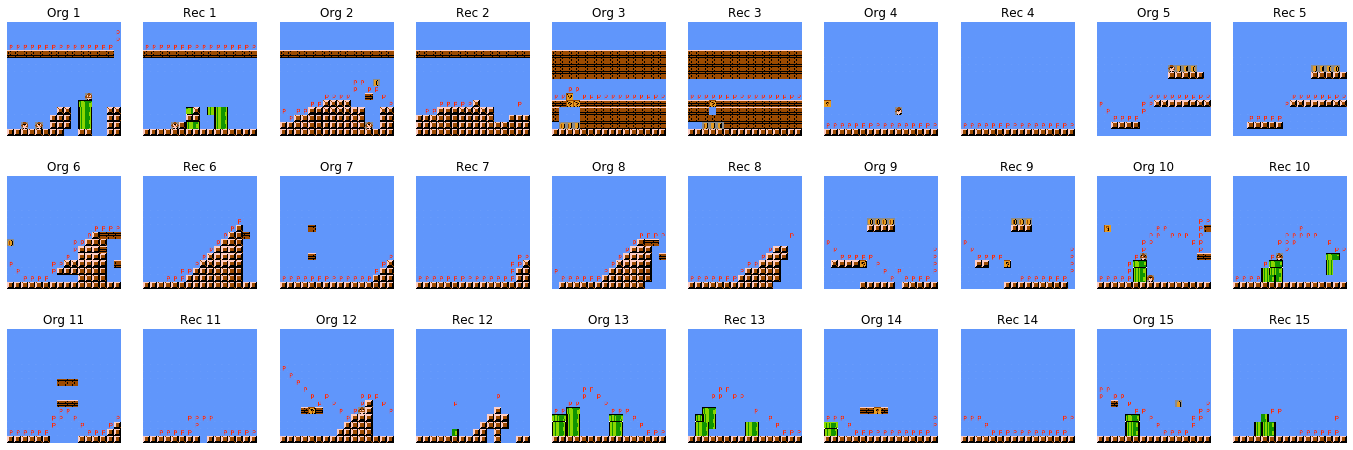

In [25]:
fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(24, 8))
axes = axes.flatten()
nrows, ncols = 3, 10

org_idxs = np.arange(0, 29, 2)
rec_idxs = org_idxs + 1

for idx in org_idxs:
        
    ax = axes[idx]

    ax.imshow(np.asarray(org_images[idx // 2]))
    ax.set_title(f'Org {idx // 2 + 1}')
    
    ax.axis('off')

for idx in rec_idxs:
        
    ax = axes[idx]

    ax.imshow(np.asarray(rec_images[idx // 2]))
    ax.set_title(f'Rec {idx // 2 + 1}')

    ax.axis('off')
    
plt.show()

## Random Generation per Category

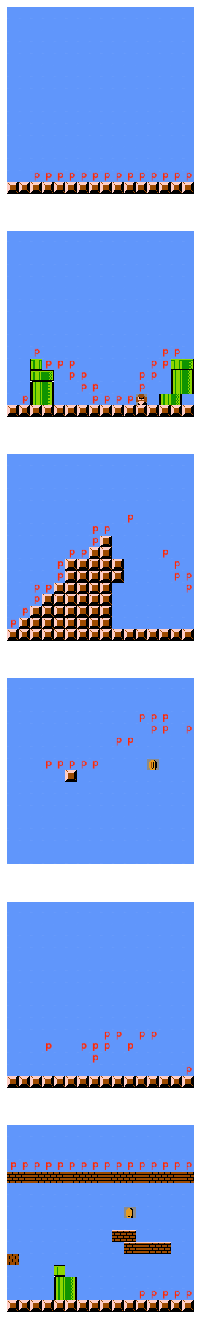

In [26]:
def display_random_generation(generated, num_classes, n=10):
    plt.figure(figsize=[24,24])
    for c in range(num_classes):
        for i in range(n):
            plt.subplot(num_classes, n, (c * n) + i + 1)
            chunk_int = generated[(c * n) + i].reshape(16, 16, 12).argmax(axis=-1)
            chunk_pix = vglc_with_path_encodings.array_to_image([chunk_int], game='smba')[0]
            plt.imshow(chunk_pix)
            plt.gray()
            plt.axis('off')
    plt.show()

elem_per_category = 1
generated = gmvae.random_generation(elem_per_category)
display_random_generation(generated, args.num_classes, elem_per_category)

In [20]:
elem_per_category = 10000 // num_components
generated = gmvae.random_generation(elem_per_category)

In [21]:
generated_int = generated.reshape(-1, 16, 16, 12).argmax(axis=-1)

In [22]:
generated_int.shape

(9996, 16, 16)

In [30]:
# since this code chunk depends on random seed, it shouldn't be run again
with open(f'../smba_generations_2_to_7/smba_gmvae_{num_components}.json', 'w+') as json_f:
    json.dump(generated_int.tolist(), json_f)

In [23]:
with open(f'../qualitative_clustering_analysis/smba_gmvae_{num_components}_{num_epochs}.json', 'w+') as json_f:
    json.dump(generated_int.tolist(), json_f)

## Visualization of the feature latent space

In [23]:
# get feature representations
test_features, test_labels = gmvae.latent_features(train_dl, return_learned_labels=True)

In [24]:
np.bincount(test_labels)

array([559, 468, 363, 364, 382, 292])

In [32]:
# import TSNE from scikit-learn library
from sklearn.manifold import TSNE

# reduce dimensionality to 2D, we consider a subset of data because TSNE
# is a slow algorithm

first_n = 1000
tsne_features = TSNE(n_components=2).fit_transform(test_features[:first_n])

In [33]:
test_labels_subset = test_labels[:first_n]

In [34]:
X_, Y_ = np.s_[:,0], np.s_[:,1]

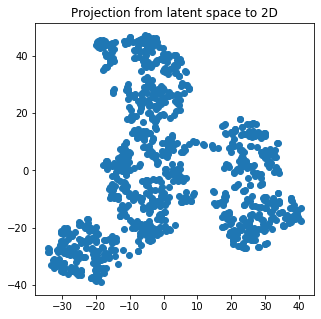

In [35]:
fig = plt.figure(figsize=(5, 5))

plt.scatter(tsne_features[X_], tsne_features[Y_])

plt.title('Projection from latent space to 2D')
plt.show()